# Homework №1 "Palm data analysis"
## Kateryna Detsyk, variant - 0 (91%7)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [3]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [4]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [5]:
production.head()

index Region  Year  Month  Production  Diff_production
0      0     JH  1998      1     118.359            0.000
1      1     JH  1998      2     147.988            0.000
2      2     JH  1998      3     145.514           29.629
3      3     JH  1998      4     154.638           -2.474
4      4     JH  1998      5     155.827            9.124

In [6]:
rainfall.head()

Region  Year  Month    Rainfall
0  Johor  1980      1  254.566667
1  Johor  1981      1   67.500000
2  Johor  1982      1  124.833333
3  Johor  1983      1  149.866667
4  Johor  1984      1  446.900000

In [7]:
area.head()

Area_New  Area_ma  Area_ma_new  Area_npa  Area_rpa Region  Year
0       0.0      0.0     0.000000       0.0       0.0     JH  1974
1      59.0    128.0   128.000000     187.0       0.0     JH  1975
2      59.0    147.0   147.000000     206.0       0.0     JH  1976
3      56.0    171.0   116.538462     227.0       0.0     JH  1977
4      59.0    191.0    93.423077     250.0       0.0     JH  1978

In [8]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [9]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [10]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)

In [11]:
DATA['Johor'][1].head()

1999-01-01    133.109
1999-02-01    147.240
1999-03-01    169.754
1999-04-01    192.155
1999-05-01    216.570
Name: Production, dtype: float64

In [12]:
data = DATA['Johor'][0]

In [13]:
data.head()

Johor_Month  Johor_Area_ma  Johor_Area_npa  Johor_Area_rpa  \
1999-01-01            1          574.0           613.0             7.0   
1999-02-01            2          574.0           613.0             7.0   
1999-03-01            3          574.0           613.0             7.0   
1999-04-01            4          574.0           613.0             7.0   
1999-05-01            5          574.0           613.0             7.0   

            Johor_Area_ma_new  Johor_Time  Johor_Rainfall_6  Johor_Rainfall_7  \
1999-01-01         403.330769          12           168.925           135.875   
1999-02-01         403.330769          13           197.300           168.925   
1999-03-01         403.330769          14           112.200           197.300   
1999-04-01         403.330769          15           186.350           112.200   
1999-05-01         403.330769          16            73.625           186.350   

            Johor_Rainfall_8  Johor_Rainfall_9  Johor_Rainfall_10  \
1999-01-01           225.725           124.025            124.775   
1999-02-01           135.875           225.725            124.025   
1999-03-01           168.925           135.875            225.725   
1999-04-01           197.300           168.925            135.875   
1999-05-01           112.200           197.300            168.925   

            Johor_Rainfall_11  Johor_Rainfall_12  Johor_Production_6  \
1999-01-01             59.050            190.900             182.535   
1999-02-01            124.775             59.050             195.686   
1999-03-01            124.025            124.775             210.113   
1999-04-01            225.725            124.025             203.115   
1999-05-01            135.875            225.725             186.055   

            Johor_Production_7  Johor_Production_8  Johor_Production_9  \
1999-01-01             163.215             155.827             154.638   
1999-02-01             182.535             163.215             155.827   
1999-03-01             195.686             182.535             163.215   
1999-04-01             210.113             195.686             182.535   
1999-05-01             203.115             210.113             195.686   

            Johor_Production_10  Johor_Production_11  Johor_Production_12  
1999-01-01              145.514              147.988              118.359  
1999-02-01              154.638              145.514              147.988  
1999-03-01              155.827              154.638              145.514  
1999-04-01              163.215              155.827              154.638  
1999-05-01              182.535              163.215              155.827

In [14]:
production = DATA['Johor'][1]

In [15]:
# describe
production.describe()

count    225.000000
mean     228.184347
std       41.617002
min      133.109000
25%      196.112000
50%      229.324000
75%      255.614000
max      329.485000
Name: Production, dtype: float64

<AxesSubplot:>

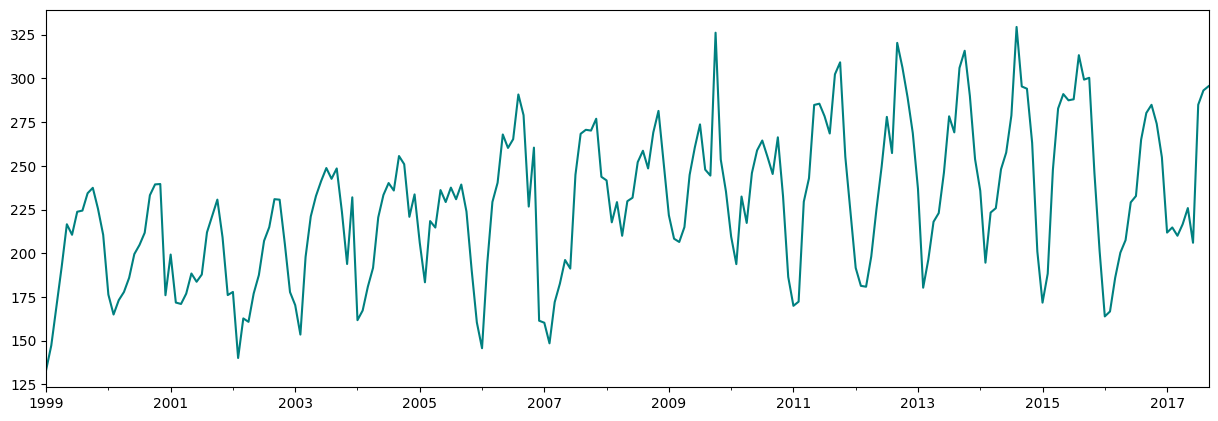

In [16]:
production.plot(figsize=(15,5), color='teal')

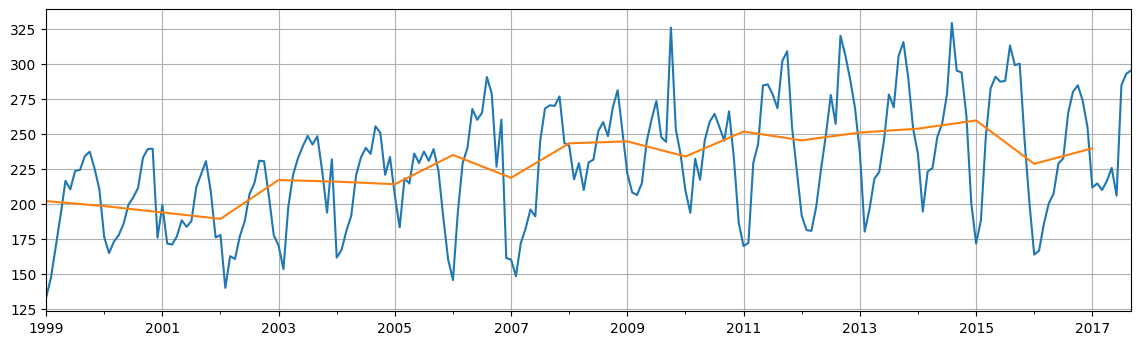

In [17]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
annual_temp = production.resample('A').mean()
production.plot(grid=True)
annual_temp.plot(grid=True);

In [18]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

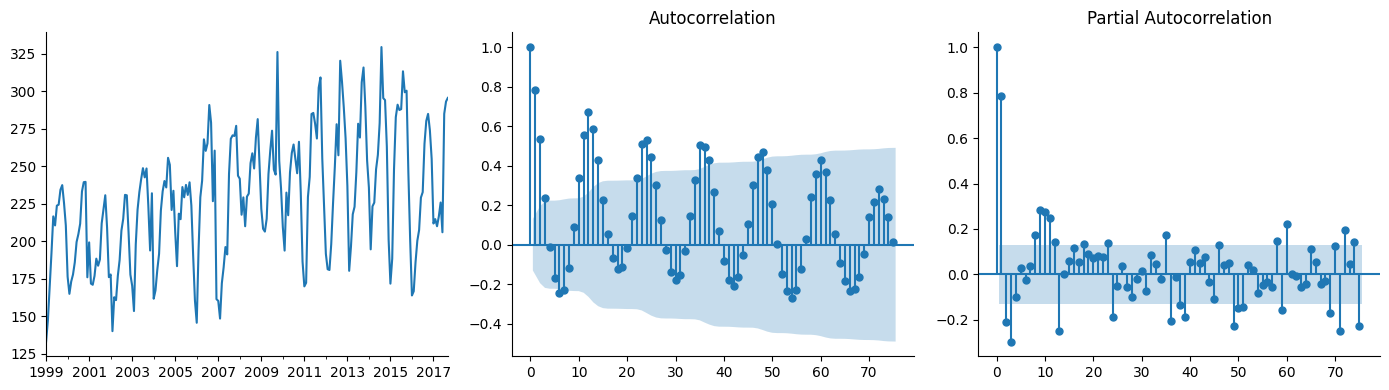

In [19]:
plots(production, lags=75);

# Additive VS Multiplicative

* **I think additive model is more suitable for this time series, as it doesn't vary very mach in frequency and amplitude over time.**

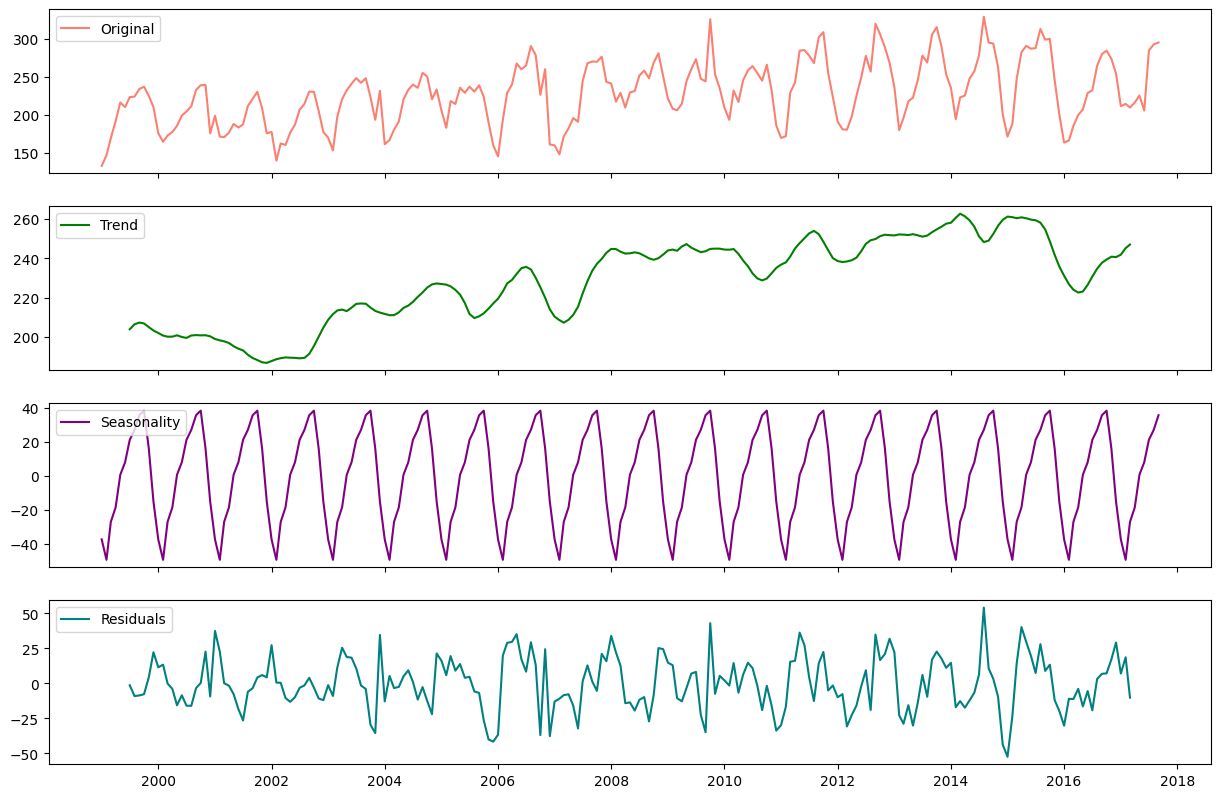

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(production, model='additive', period=12) 
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid


fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(production, label='Original', color='salmon')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend', color="green")
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality', color="purple")
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals', color="teal")
axes[3].legend(loc='upper left');

# Check if Stationary

**Chunks**

In [21]:
len(production)

225

In [22]:
chunks = np.split(production, indices_or_sections=25)

print("Means : \n", np.mean(chunks, axis=1))
print("\nVariances : \n", np.var(chunks, axis=1))

Means : 
 [194.64844444 194.54844444 205.17555556 198.43222222 184.29944444
 203.39944444 211.01422222 231.39622222 221.73255556 212.45466667
 218.25233333 238.28766667 235.48444444 239.85522222 246.31188889
 241.38411111 248.24933333 223.86244444 259.28166667 266.70011111
 254.306      247.50411111 240.53777778 247.64177778 239.84855556]

Variances : 
 [1188.80925647  565.87215558  706.42216114  362.13970951  746.23489158
  848.3535918  1109.06884017  320.67330817  298.64307891 1617.60055689
 2959.719464   1292.42986444  230.34946647  692.40665106 1291.01499721
  595.68075343 2141.30322089 1588.26624647 1997.24948756 1058.05304899
 1520.20522444 2063.06092143 3387.68678684  880.48433528 1352.52332225]


* We can see that mean is relatively constant over time, but the varience is clearly changing which means this data is not stationary.

**Histogram Plot**

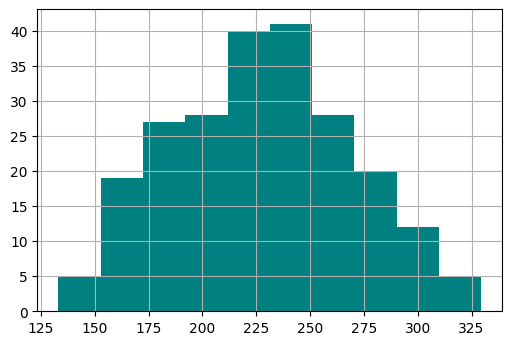

In [23]:
pd.Series(production).hist(color='teal',figsize=(6,4));

In [24]:
from scipy.stats import mstats

z,pval = mstats.normaltest(production)

if(pval < 0.055):
    print("Not normal distribution")
print(z, pval)

Not normal distribution
6.109240229440511 0.04714062539892718


* It looks close to Normal distribution, but I think hist method in this case isn't reliable enough to confirm that our time series is stationary.

**Augmented Dickey-Fuller Test**

In [25]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

    if(dftest[1] < 0.055):
        print("Stationary")
    else:
        print("Not stationary")

Results of Dickey-Fuller Test:
(-1.629673528334026, 0.46766160623822606, 15, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 1864.119597376337)
Test Statistic                  -1.629674
p-value                          0.467662
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64
Not stationary


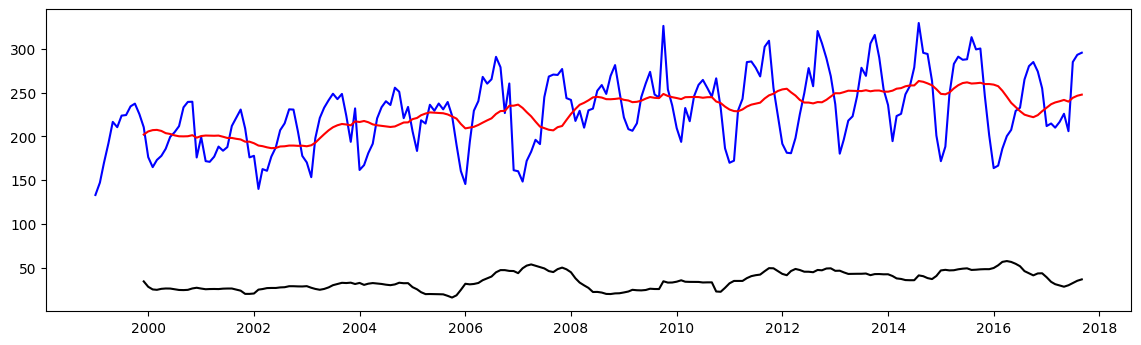

In [26]:
stationarity_test(production)

In [27]:
stationarity_test(production[12:])

Results of Dickey-Fuller Test:
(-1.784233198072541, 0.3883170898532333, 15, 197, {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}, 1761.0366656739584)
Test Statistic                  -1.784233
p-value                          0.388317
#Lags Used                      15.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64
Not stationary


* ADF confirmed that data is not stationary.

# Decomposition VS Differencing 
two ways to make time series stationary

Try differencing, it's made our data stationary. 

<AxesSubplot:>

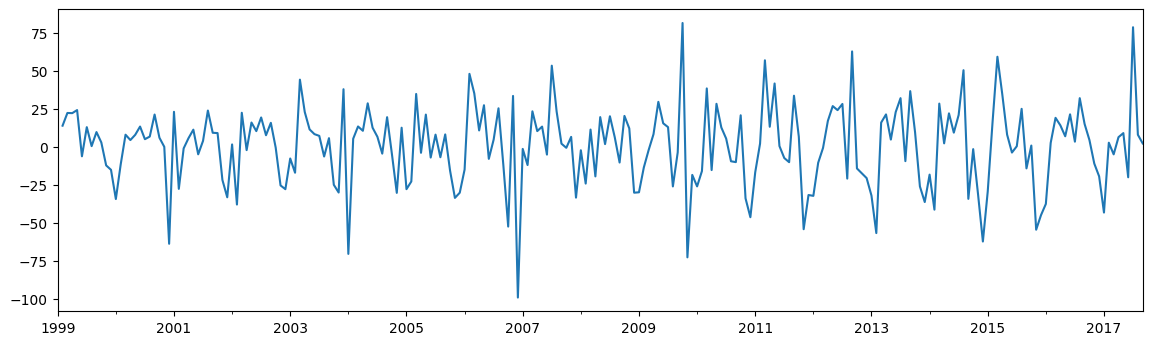

In [28]:
# Differencing
production_diff = production - production.shift(1)
production_diff.plot()

In [29]:
production_diff.dropna(inplace=True)
stationarity_test(production_diff)

Results of Dickey-Fuller Test:
(-6.460838342009544, 1.4446217234579037e-08, 14, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 1857.1871112827093)
Test Statistic                -6.460838e+00
p-value                        1.444622e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64
Stationary


Decomposition also works well and made our data stationary.

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(ts, freq):
    decomposition = seasonal_decompose(ts, period=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label='Original', color="teal")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="teal")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="teal")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="teal")
    plt.legend(loc='best')
    plt.tight_layout()
    

    return residual, trend, seasonal

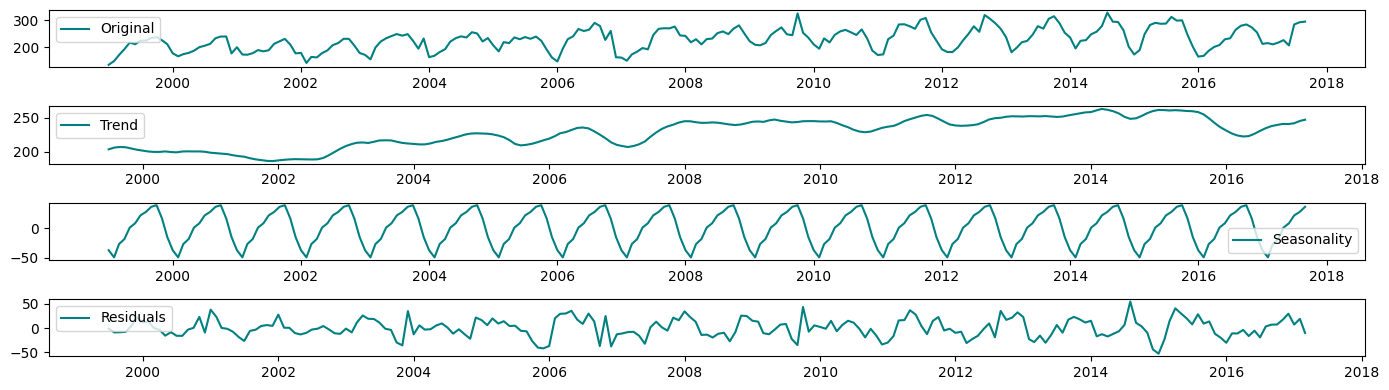

In [31]:
production_decompose, trend, seasonal = _decompose(production, 12)

In [32]:
trend.dropna(inplace=True)
seasonal.dropna(inplace=True)
seasonal = seasonal[:-6]

Results of Dickey-Fuller Test:
(-8.10946006383471, 1.2370788762178924e-12, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1635.9554679749076)
Test Statistic                -8.109460e+00
p-value                        1.237079e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64
Stationary


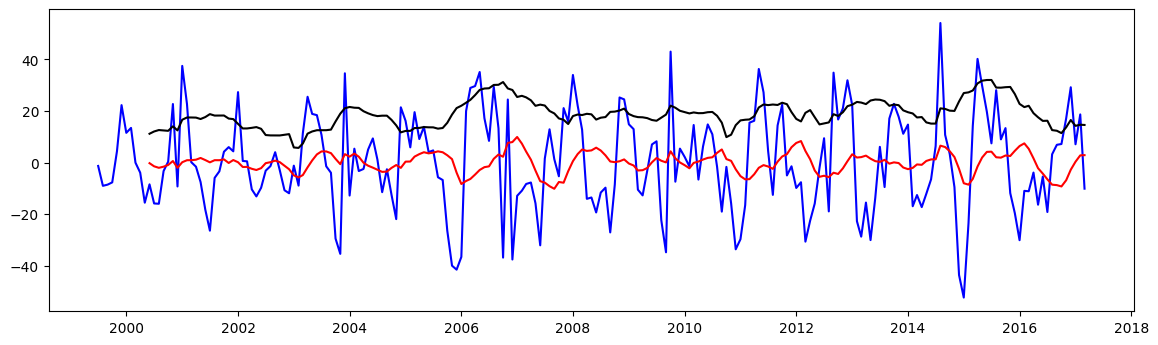

In [33]:
production_decompose.dropna(inplace=True)
stationarity_test(production_decompose)

* Decomposition gives smaller p-value than Differencing.
* Decomposition also gives smaller Test Statistic and as I understand the more negative Test Statistic value - the more confident result.

# Exponentially weighted moving average


In [34]:
expwighted_avg = production.ewm(span=12).mean()

<AxesSubplot:>

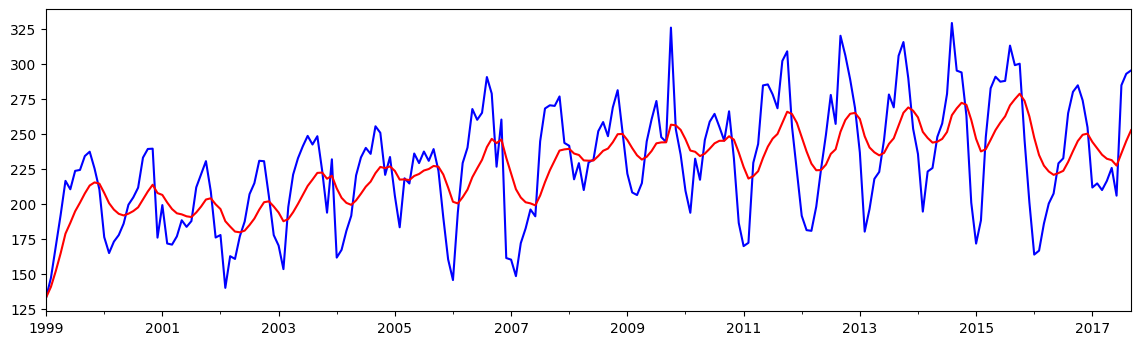

In [35]:
production.plot(color="blue", label="Original")
expwighted_avg.plot(color="red", label="EWMA")

In [36]:
print("RMSE Exponentially weighted moving average : ", np.sqrt(mean_squared_error(expwighted_avg, production)))

RMSE Exponentially weighted moving average :  31.192547048961213


<AxesSubplot:>

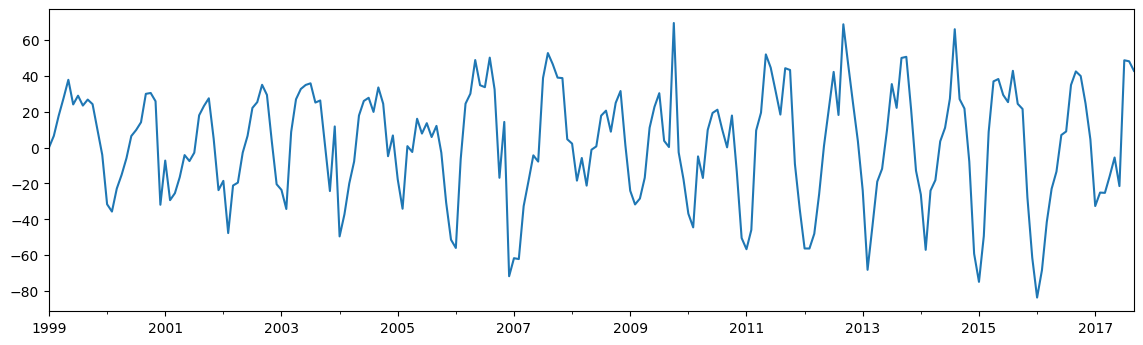

In [37]:
ts_exp_diff = production - expwighted_avg
ts_exp_diff.plot()

Results of Dickey-Fuller Test:
(-5.931278439670068, 2.3773908370630644e-07, 13, 211, {'1%': -3.46172743446274, '5%': -2.8753374677799957, '10%': -2.574124089081557}, 1787.6981357279608)
Test Statistic                -5.931278e+00
p-value                        2.377391e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64
Stationary


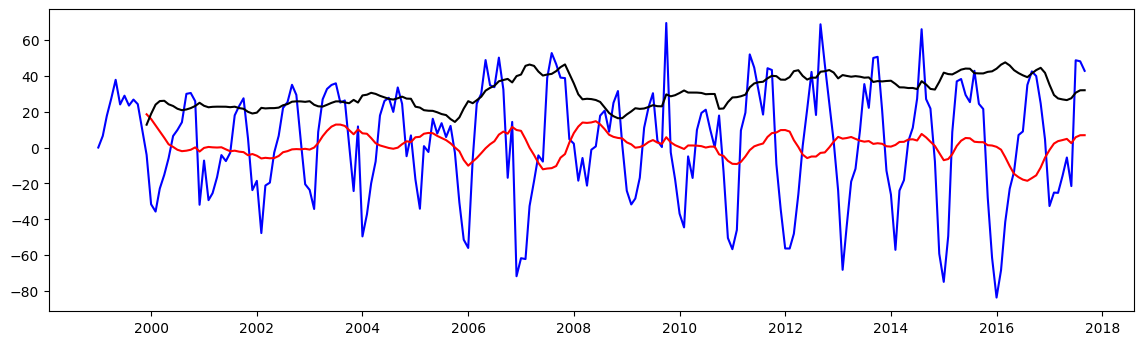

In [38]:
stationarity_test(ts_exp_diff)

# Moving Average and Exponential Smoothing

In [39]:
train = production[:-12]
test = production[-12:]

* **One last year - for test set**

# Moving Average

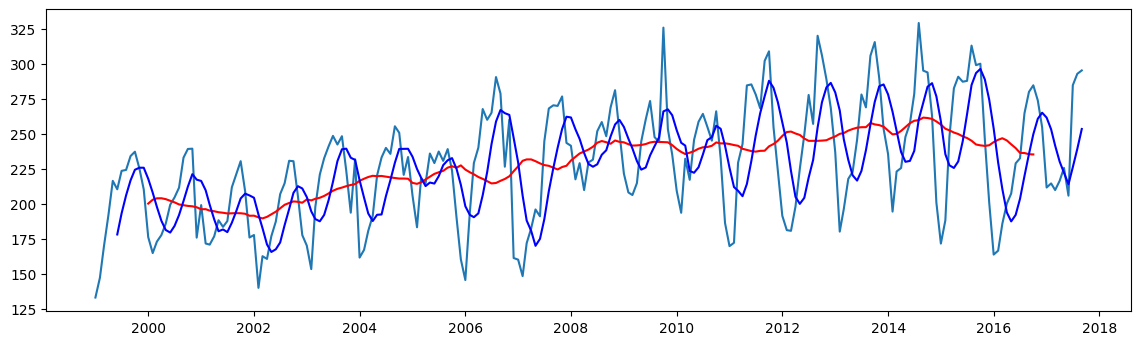

In [40]:
ts = DATA['Johor'][1]
ts_log = np.log(DATA['Johor'][1])

ts_moving_avg_center = ts.rolling(24, center=True).mean()
ts_moving_avg_right = ts.rolling(6, center=False).mean()
plt.plot(ts)
plt.plot(ts_moving_avg_center, color='red')
plt.plot(ts_moving_avg_right, color='blue')

In [41]:
m = ts_moving_avg_center.dropna()
x = ts['2000-01-01':'2016-10-01']
print("RMSE moving averge center : ", np.sqrt(mean_squared_error(m, x)))

RMSE moving averge center :  37.0978362456256


In [42]:
m = ts_moving_avg_right.dropna()
x = ts['1999-06-01':'2017-09-01']
print("RMSE moving averge center : ", np.sqrt(mean_squared_error(m, x)))

RMSE moving averge center :  35.26617872839402


<AxesSubplot:>

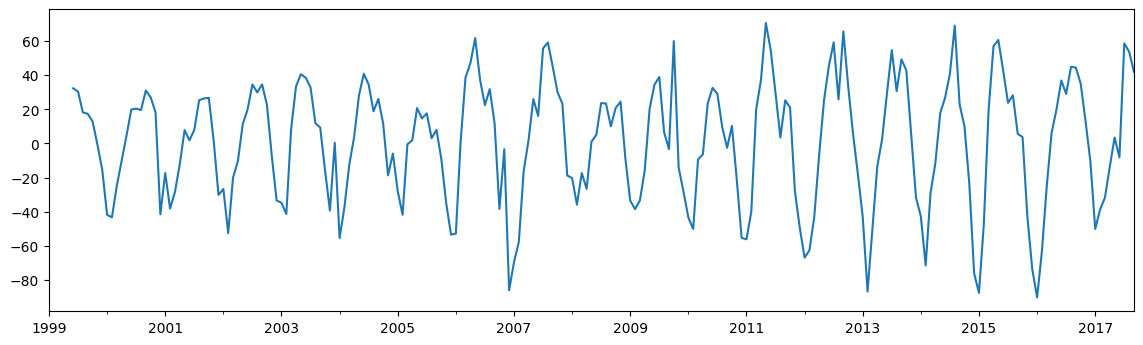

In [43]:
ts_ma_diff = ts - ts_moving_avg_right
ts_ma_diff.plot()

In [44]:
np.nanmean(ts_ma_diff)

1.0263863636364488

<AxesSubplot:>

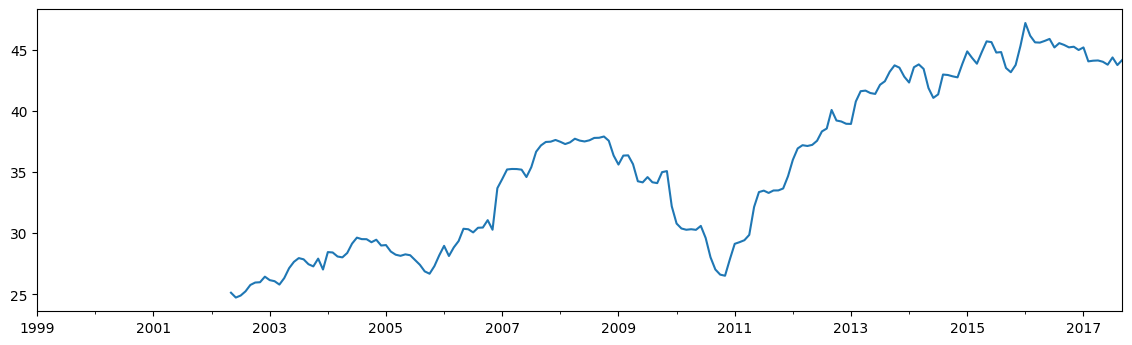

In [45]:
ts_ma_diff.rolling(36).std().plot()

# Exponential Smoothing

#### Single Exponential


In [47]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
# single_mse = mse(test, single_preds)
print("Predictions: \n", single_preds)
# print("MSE: ", single_mse)
single_rmse = np.sqrt(mean_squared_error(single_preds, test))
print('RMSE: %.4f'% single_rmse)

Predictions: 
 2016-10-01    280.248
2016-11-01    280.248
2016-12-01    280.248
2017-01-01    280.248
2017-02-01    280.248
2017-03-01    280.248
2017-04-01    280.248
2017-05-01    280.248
2017-06-01    280.248
2017-07-01    280.248
2017-08-01    280.248
2017-09-01    280.248
Freq: MS, dtype: float64
RMSE: 47.9277


c:\users\katia\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


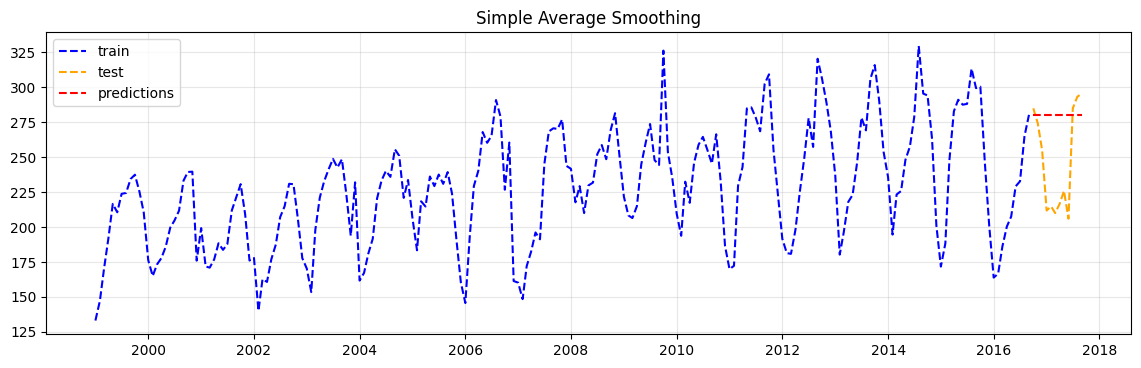

In [48]:
plt.plot(train, 'b--', label="train")
plt.plot(test, color='orange', linestyle="--", label="test")
plt.plot(single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Average Smoothing")
plt.grid(alpha=0.3);

#### Double Exponential

In [49]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
# double_mse = mse(test, double_preds)
double_rmse = np.sqrt(mean_squared_error(double_preds, test))

print("Predictions: \n", double_preds)
print("MSE: ", double_rmse)

Predictions: 
 2016-10-01    280.820837
2016-11-01    281.768574
2016-12-01    282.716312
2017-01-01    283.664049
2017-02-01    284.611786
2017-03-01    285.559524
2017-04-01    286.507261
2017-05-01    287.454999
2017-06-01    288.402736
2017-07-01    289.350473
2017-08-01    290.298211
2017-09-01    291.245948
Freq: MS, dtype: float64
MSE:  51.743985707580286


c:\users\katia\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


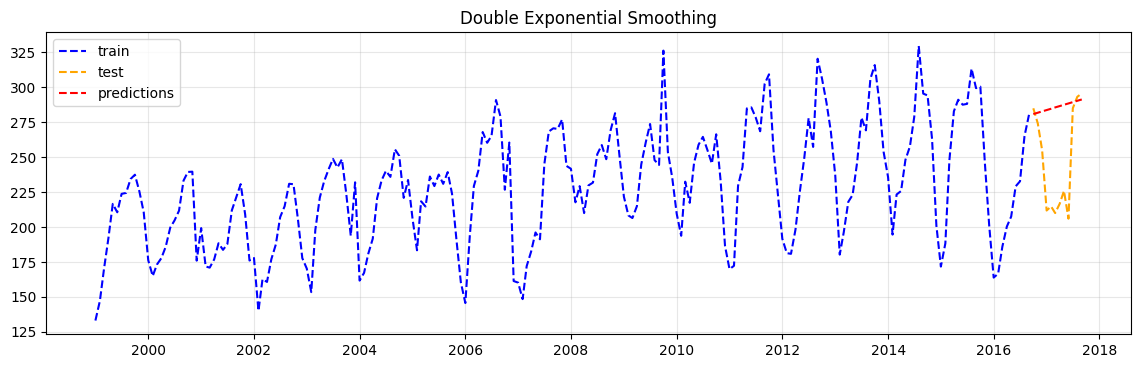

In [50]:
plt.plot(train, 'b--', label="train")
plt.plot(test, color='orange', linestyle="--", label="test")
plt.plot(double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

#### Triple Exponential

In [51]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))
# triple_mse = mse(test, triple_preds)
triple_rmse = np.sqrt(mean_squared_error(triple_preds, test))

print("Predictions: \n", triple_preds)
print("RMSE: ", triple_rmse)

c:\users\katia\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Predictions: 
 2016-10-01    279.640569
2016-11-01    254.837447
2016-12-01    223.532224
2017-01-01    202.637744
2017-02-01    192.738385
2017-03-01    217.835204
2017-04-01    226.145250
2017-05-01    245.592309
2017-06-01    252.514527
2017-07-01    265.712044
2017-08-01    271.506192
2017-09-01    278.993655
Freq: MS, dtype: float64
RMSE:  21.931919571534277


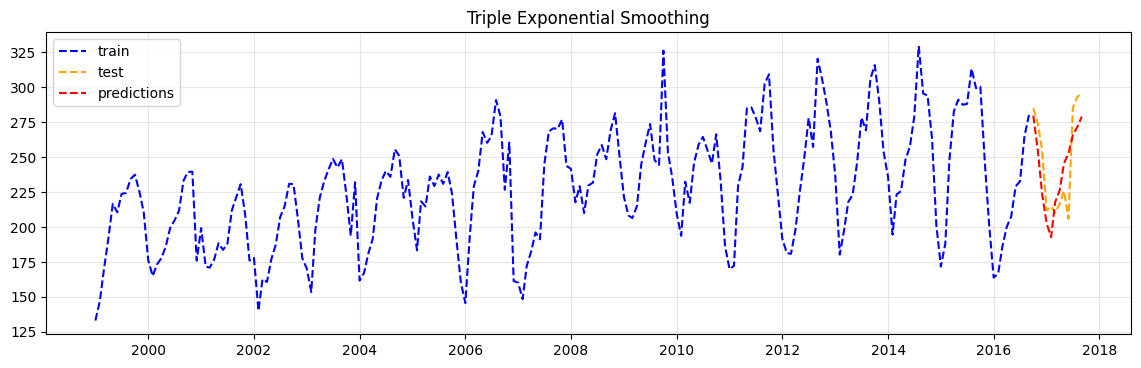

In [52]:
plt.plot(train, 'b--', label="train")
plt.plot(test, color='orange', linestyle="--", label="test")
plt.plot(triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

* **Triple exponential Smoothing shown the best result and it's suitable for us as our time series contains both trend and sesonality.**

In [53]:
data_dict = {'RMSE':[single_rmse, double_rmse, triple_rmse]}
df = pd.DataFrame(data_dict, index=['single', 'double', 'triple'])
df

RMSE
single  47.927713
double  51.743986
triple  21.931920

# MA, AR, ARMA, ARIMA models (training and validation)

I'm using stationary decomposed data for validation and forcast, but I also try to use diff data for comparison.

In [54]:
# pre_train = production_decompose[:-36]
# train = production_decompose[:-12]
# val = production_decompose[-36:-12]
# test = production_decompose[-12:]

In [55]:
# pre_train = production[:-36]
# train = production[:-12]
# val = production[-36:-12]
# test = production[-12:]

In [56]:
from statsmodels.tsa.arima_model import ARIMA
import math 
from sklearn.metrics import mean_squared_error

**ARIMA** 
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

Configure ARIMA model to perform the function of an ARMA, AR and MA models.

**MA** : p = 0, d = 0, q = n

**AR** : p = n, d = 0, q = 0

**ARMA** : p = n, d = 0, q = m


# MA

### validation

In [57]:
def run_ma(train, val, arima_order):
    history = [x for x in train.values]
    predictions = list()
    
    for t in range(len(val)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        y = model_fit.forecast()[0]
        predictions.append(y)
        history.append(val[t])  
    
    return math.sqrt(mean_squared_error(val.values, predictions))
 
def validation(train, val):
    q_values = range(0, 7)
    best_score, best_cfg = float("inf"), None
    
    for q in q_values:
        order = (0,0,q)
        try:
            rmse = run_ma(train, val, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('MA%s RMSE=%.4f' % (order,rmse))
        except:
            continue
    
    print('Best MA%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg

### test set prediction

### with decomposed time series

In [58]:
pre_train = production_decompose[:-36]
train = production_decompose[:-12]
val = production_decompose[-36:-12]
test = production_decompose[-12:]

In [59]:
warnings.filterwarnings("ignore")
params_ma = validation(pre_train, val)

MA(0, 0, 0) RMSE=24.8741
MA(0, 0, 1) RMSE=21.0235
MA(0, 0, 2) RMSE=20.0869
MA(0, 0, 3) RMSE=20.0356
MA(0, 0, 4) RMSE=20.1766
MA(0, 0, 5) RMSE=17.8269
MA(0, 0, 6) RMSE=17.1163
Best MA(0, 0, 6) RMSE=17.1163


Text(0.5, 1.0, 'RMSE: 14.9949')

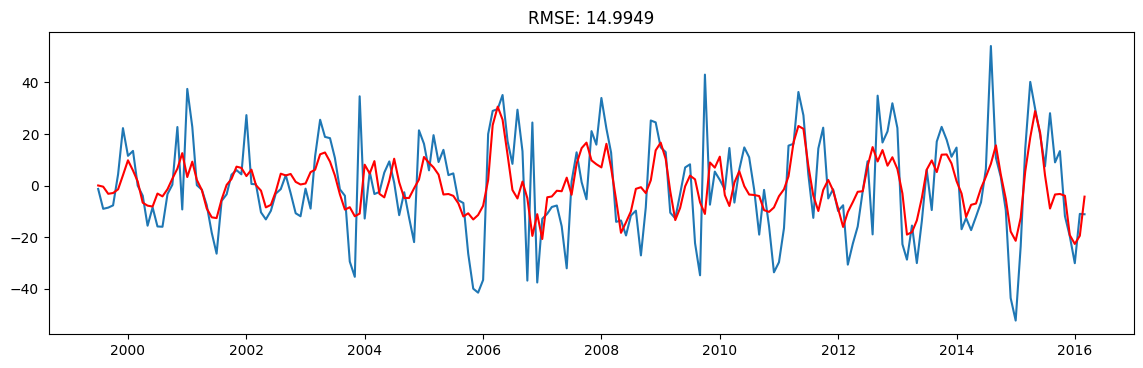

In [60]:
model = ARIMA(train, order=params_ma)
model_fit = model.fit(disp=-1)
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues,train)))
# plt.title('RMSE: %.4f'% np.sqrt(sum((model_fit.fittedvalues-train)**2)))

In [61]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  201
Model:                     ARMA(0, 6)   Log Likelihood                -830.235
Method:                       css-mle   S.D. of innovations             14.896
Date:                Thu, 08 Oct 2020   AIC                           1676.470
Time:                        21:10:31   BIC                           1702.896
Sample:                    07-01-1999   HQIC                          1687.163
                         - 03-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0297      0.091      0.328      0.743      -0.148       0.207
ma.L1.resid     0.1875      0.069      2.710      0.007       0.052       0.323
ma.L2.resid    -0.0189      0.065     -0.292    

In [62]:
# start_index = len(train)
# end_index = start_index + len(test)-1
# forecast = model_fit.predict(start=start_index, end=end_index)
# rmse_ma = np.sqrt(mean_squared_error(forecast, test))
# rmse_ma = np.sqrt(sum((forecast-test)**2))

In [63]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_ma)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_ma_decomp = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_ma_decomp)

forecast = pd.Series(predictions, index=test.index) 

predicted=-0.503799, expected=-3.886872
predicted=2.921725, expected=-16.355171
predicted=-3.007683, expected=-5.437879
predicted=1.015236, expected=-19.197029
predicted=1.069914, expected=3.212832
predicted=10.744812, expected=6.888654
predicted=11.386388, expected=7.199915
predicted=11.253305, expected=17.172524
predicted=9.139932, expected=29.223140
predicted=9.348523, expected=7.095885
predicted=1.194552, expected=18.678253
predicted=0.542681, expected=-10.142377
Test RMSE: 11.895


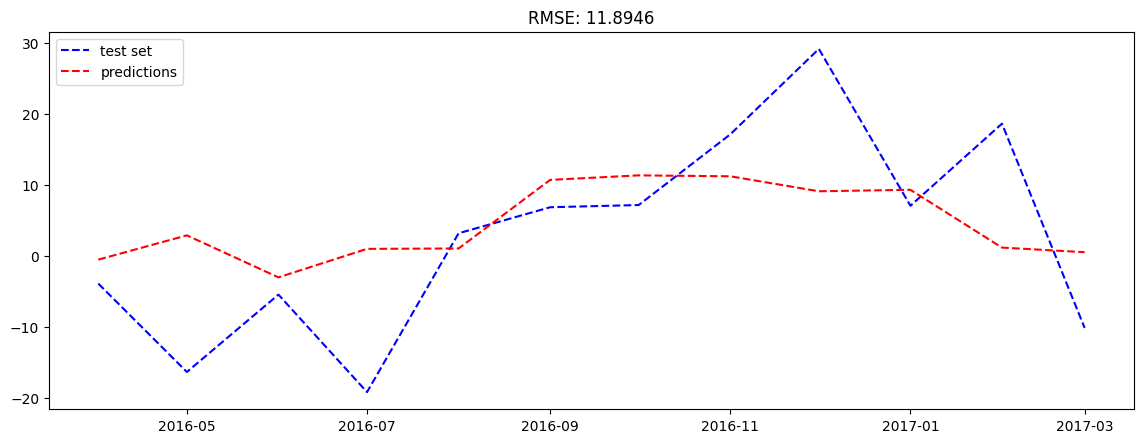

In [64]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
# plt.plot(train)
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")

plt.title('RMSE: %.4f'% rmse_ma_decomp)
plt.legend(loc='upper left')
plt.show()

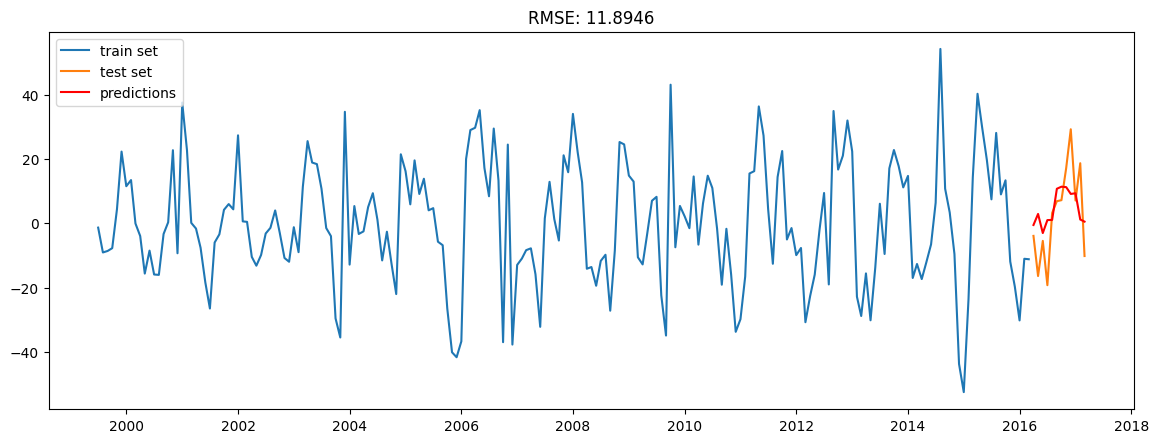

In [65]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_ma_decomp)
plt.legend(loc='upper left')
plt.show()

In [66]:
x = forecast + trend[-12:] + seasonal[-12:]
y = production[:-6]

In [67]:
np.sqrt(mean_squared_error(y[-12:], x))

11.89457527792585

* **If I add trend and seasonal to my stationary time series, I get the same RMSE.**

### with difference time series

In [68]:
pre_train = production_diff[:-36]
train = production_diff[:-12]
val = production_diff[-36:-12]
test = production_diff[-12:]

In [70]:
warnings.filterwarnings("ignore")
params_ma = validation(pre_train, val)

MA(0, 0, 0) RMSE=29.2468
MA(0, 0, 1) RMSE=28.5801
MA(0, 0, 2) RMSE=27.7769
MA(0, 0, 3) RMSE=27.9843
MA(0, 0, 4) RMSE=25.5722
MA(0, 0, 5) RMSE=24.8917
MA(0, 0, 6) RMSE=24.6240
Best MA(0, 0, 6) RMSE=24.6240


In [71]:
model = ARIMA(train, order=params_ma)
model_fit = model.fit(disp=-1)
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues,train)))

Text(0.5, 1.0, 'RMSE: 22.7696')

In [72]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             Production   No. Observations:                  212
Model:                     ARMA(0, 6)   Log Likelihood                -963.954
Method:                       css-mle   S.D. of innovations             22.609
Date:                Thu, 08 Oct 2020   AIC                           1943.908
Time:                        21:12:55   BIC                           1970.761
Sample:                    02-01-1999   HQIC                          1954.761
                         - 09-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3361      0.092      3.647      0.000       0.156       0.517
ma.L1.Production    -0.1390      0.070     -1.977      0.048      -0.277      -0.001
ma.L2.Production    -0.0058 

In [73]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_ma)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_ma_diff = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_ma_diff)

forecast = pd.Series(predictions, index=test.index)

predicted=4.038091, expected=4.674000
predicted=-2.044559, expected=-10.815000
predicted=-6.615567, expected=-19.226000
predicted=-5.545859, expected=-43.071000
predicted=2.753959, expected=2.937000
predicted=4.629163, expected=-4.745000
predicted=14.984528, expected=6.572000
predicted=17.210376, expected=9.260000
predicted=12.471936, expected=-19.845000
predicted=11.454784, expected=78.974000
predicted=-2.812095, expected=8.177000
predicted=10.977797, expected=2.438000
Test RMSE: 25.271


In [74]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_ma_diff)
plt.legend(loc='upper left')
plt.show()

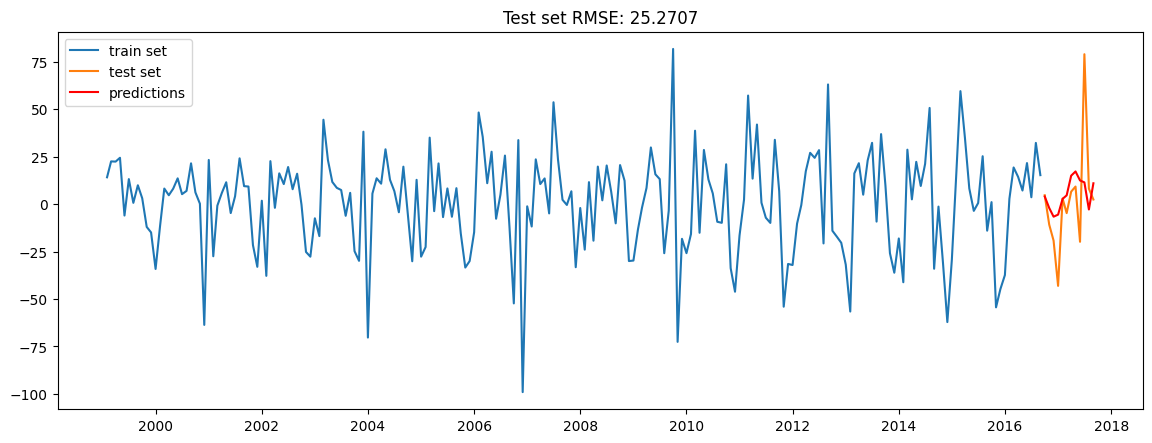

In [75]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('Test set RMSE: %.4f'% rmse_ma_diff)
plt.legend(loc='upper left')
plt.show()

In [76]:
x = forecast + production.shift(1)[-12:]

In [77]:
np.sqrt(mean_squared_error(production[-12:], x))

25.270683045299805

* **If we add shifted data back to differenced data, our RMSE doesn't change.**
* **RMSE with decomposed data is smaller.**

# AR 

### cross validation

In [81]:
def run_ar(train, val, arima_order):
    history = [x for x in train.values]
    predictions = list()
    
    for t in range(len(val)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        y = model_fit.forecast()[0]
        predictions.append(y)
        history.append(val[t])  
    
    return math.sqrt(mean_squared_error(val.values, predictions))
 
def validation(train, val):
    p_values = [0, 1, 2, 4, 6, 8]
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        order = (p,0,0)
        try:
            rmse = run_ar(train, val, order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('AR%s RMSE=%.4f' % (order,rmse))
        except:
            continue
    
    print('Best AR%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg

### test set prediction

### with decomposed time series

In [79]:
pre_train = production_decompose[:-36]
train = production_decompose[:-12]
val = production_decompose[-36:-12]
test = production_decompose[-12:]

In [82]:
warnings.filterwarnings("ignore")
params_ar = validation(pre_train, val)

AR(0, 0, 0) RMSE=24.8741
AR(1, 0, 0) RMSE=20.1691
AR(2, 0, 0) RMSE=20.4191
AR(4, 0, 0) RMSE=18.4020
AR(6, 0, 0) RMSE=18.9501
AR(8, 0, 0) RMSE=19.4164
Best AR(4, 0, 0) RMSE=18.4020


In [83]:
model = ARIMA(train, order=params_ar)
model_fit = model.fit(disp=-1)
plt.plot(train, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train)))

Text(0.5, 1.0, 'RMSE: 16.1417')

In [84]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  201
Model:                     ARMA(4, 0)   Log Likelihood                -844.550
Method:                       css-mle   S.D. of innovations             16.140
Date:                Thu, 08 Oct 2020   AIC                           1701.101
Time:                        21:14:42   BIC                           1720.920
Sample:                    07-01-1999   HQIC                          1709.121
                         - 03-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0800      1.405      0.057      0.955      -2.673       2.833
ar.L1.resid     0.3931      0.068      5.822      0.000       0.261       0.525
ar.L2.resid     0.1051      0.073      1.439    

In [ ]:
# start_index = len(train)
# end_index = start_index + len(test)-1
# forecast = model_fit.predict(start=start_index, end=end_index)
# rmse_ar = np.sqrt(mean_squared_error(forecast, test))

# rmse_ar = np.sqrt(sum((forecast-test)**2))

In [85]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_ar)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_ar_decomp = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_ar_decomp)

forecast = pd.Series(predictions, index=test.index)

predicted=1.048856, expected=-3.886872
predicted=5.980800, expected=-16.355171
predicted=-3.622482, expected=-5.437879
predicted=-0.885706, expected=-19.197029
predicted=-6.694907, expected=3.212832
predicted=3.475225, expected=6.888654
predicted=5.178965, expected=7.199915
predicted=8.380495, expected=17.172524
predicted=6.376883, expected=29.223140
predicted=11.523239, expected=7.095885
predicted=3.515695, expected=18.678253
predicted=2.662211, expected=-10.142377
Test RMSE: 12.873


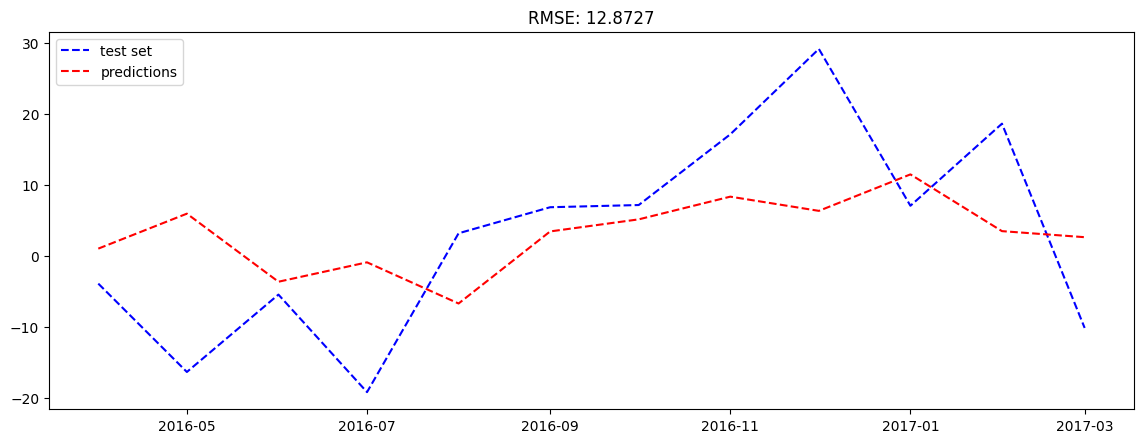

In [86]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_ar_decomp)
plt.legend(loc='upper left')
plt.show()

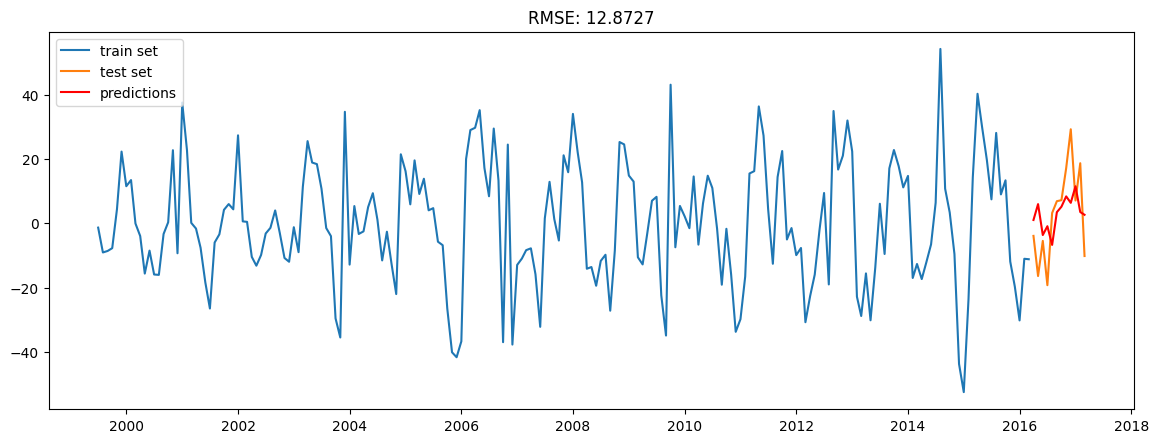

In [87]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_ar_decomp)
plt.legend(loc='upper left')
plt.show()

In [88]:
x = forecast + trend[-12:] + seasonal[-12:]
y = production[:-6]
np.sqrt(mean_squared_error(y[-12:], x))

12.872676288865438

### with differenced time series

In [89]:
pre_train = production_diff[:-36]
train = production_diff[:-12]
val = production_diff[-36:-12]
test = production_diff[-12:]

In [90]:
warnings.filterwarnings("ignore")
params_ar = validation(pre_train, val)

AR(0, 0, 0) RMSE=29.2468
AR(1, 0, 0) RMSE=28.3936
AR(2, 0, 0) RMSE=28.3312
AR(4, 0, 0) RMSE=26.1956
AR(6, 0, 0) RMSE=27.1761
AR(8, 0, 0) RMSE=24.9394
Best AR(8, 0, 0) RMSE=24.9394


Text(0.5, 1.0, 'RMSE: 22.1787')

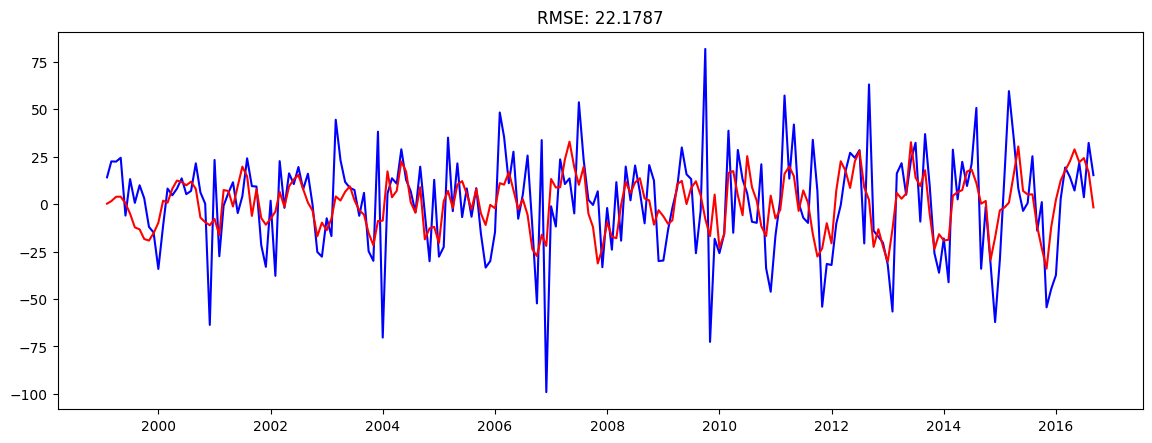

In [91]:
model = ARIMA(train, order=params_ar)
model_fit = model.fit(disp=-1)
plt.plot(train, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train)))

In [92]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             Production   No. Observations:                  212
Model:                     ARMA(8, 0)   Log Likelihood                -958.300
Method:                       css-mle   S.D. of innovations             22.121
Date:                Thu, 08 Oct 2020   AIC                           1936.601
Time:                        21:16:05   BIC                           1970.167
Sample:                    02-01-1999   HQIC                          1950.167
                         - 09-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2320      0.630      0.368      0.713      -1.003       1.467
ar.L1.Production    -0.1172      0.065     -1.816      0.069      -0.244       0.009
ar.L2.Production     0.0291 

In [93]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_ar)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_ar_differ = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_ar_differ)

forecast = pd.Series(predictions, index=test.index)

predicted=-16.627422, expected=4.674000
predicted=-20.193938, expected=-10.815000
predicted=-19.870456, expected=-19.226000
predicted=-16.715823, expected=-43.071000
predicted=-9.470342, expected=2.937000
predicted=-7.238708, expected=-4.745000
predicted=0.632882, expected=6.572000
predicted=10.767685, expected=9.260000
predicted=10.445799, expected=-19.845000
predicted=16.400174, expected=78.974000
predicted=5.222120, expected=8.177000
predicted=16.094106, expected=2.438000
Test RMSE: 23.207


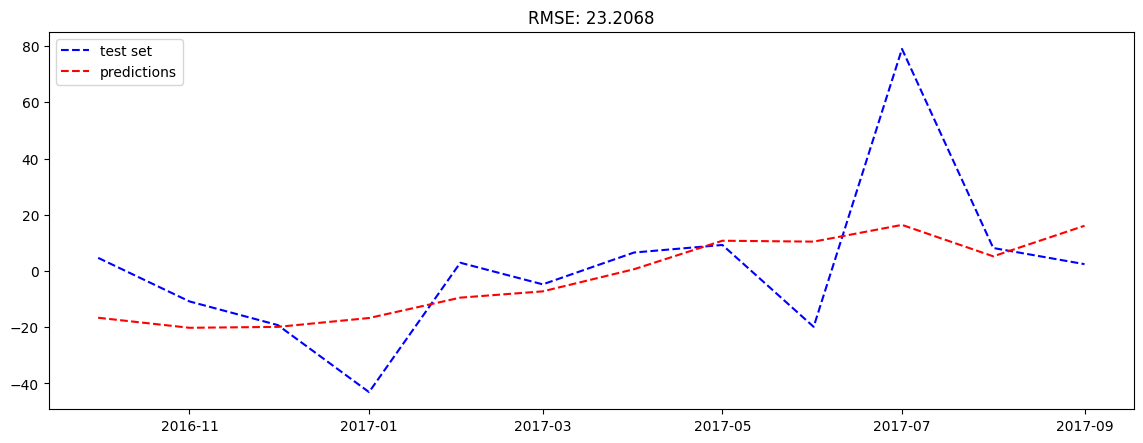

In [94]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_ar_differ)
plt.legend(loc='upper left')
plt.show()

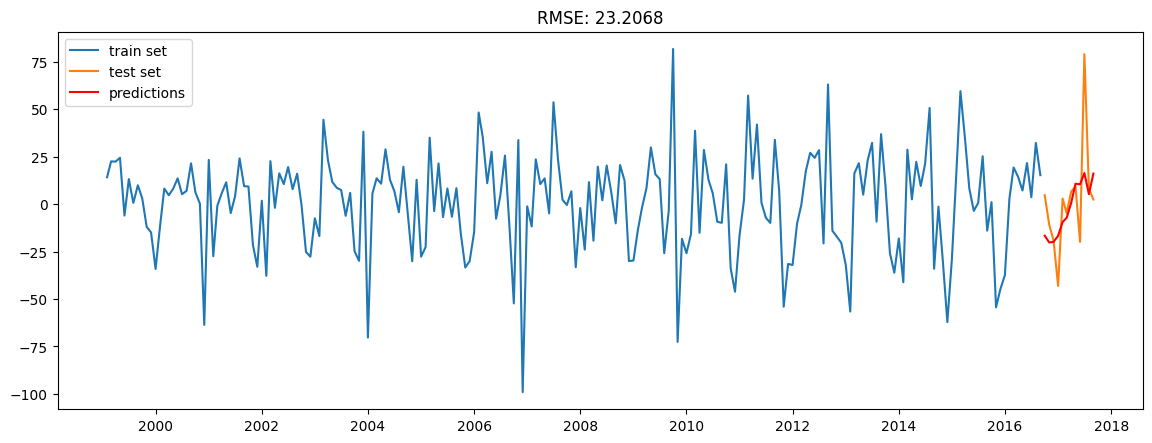

In [95]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_ar_differ)
plt.legend(loc='upper left')
plt.show()

In [96]:
x = forecast + production.shift(1)[-12:]
np.sqrt(mean_squared_error(production[-12:], x))

23.20680477944789

* **We get better results with decomposed time series.**

# ARMA

### validation

In [97]:
def run_arma(train, val, arima_order):
    history = [x for x in train.values]
    predictions = list()
    
    for t in range(len(val)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        y = model_fit.forecast()[0]
        predictions.append(y)
        history.append(val[t])  
    
    return math.sqrt(mean_squared_error(val.values, predictions))
 
def validation(train, val):
    p_values = [0, 1, 2, 4, 6, 8]
    q_values = range(0, 7)
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for q in q_values:
            order = (p,0,q)
            try:
                rmse = run_arma(train, val, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARMA%s RMSE=%.4f' % (order,rmse))
            except:
                continue
    
    print('Best ARMA%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg

### test set prediction

### with decomposed time series

In [98]:
pre_train = production_decompose[:-36]
train = production_decompose[:-12]
val = production_decompose[-36:-12]
test = production_decompose[-12:]

In [99]:
warnings.filterwarnings("ignore")
params_arma = validation(pre_train, val)

ARMA(0, 0, 0) RMSE=24.8741
ARMA(0, 0, 1) RMSE=21.0235
ARMA(0, 0, 2) RMSE=20.0869
ARMA(0, 0, 3) RMSE=20.0356
ARMA(0, 0, 4) RMSE=20.1766
ARMA(0, 0, 5) RMSE=17.8269
ARMA(0, 0, 6) RMSE=17.1163
ARMA(1, 0, 0) RMSE=20.1691
ARMA(1, 0, 1) RMSE=20.3275
ARMA(1, 0, 2) RMSE=19.9300
ARMA(2, 0, 0) RMSE=20.4191
ARMA(2, 0, 1) RMSE=16.6707
ARMA(2, 0, 2) RMSE=18.5549
ARMA(4, 0, 0) RMSE=18.4020
ARMA(4, 0, 1) RMSE=17.9763
ARMA(6, 0, 0) RMSE=18.9501
ARMA(6, 0, 1) RMSE=18.4133
ARMA(8, 0, 0) RMSE=19.4164
ARMA(8, 0, 1) RMSE=18.1774
ARMA(8, 0, 2) RMSE=18.6589
Best ARMA(2, 0, 1) RMSE=16.6707


Text(0.5, 1.0, 'RMSE: 15.1376')

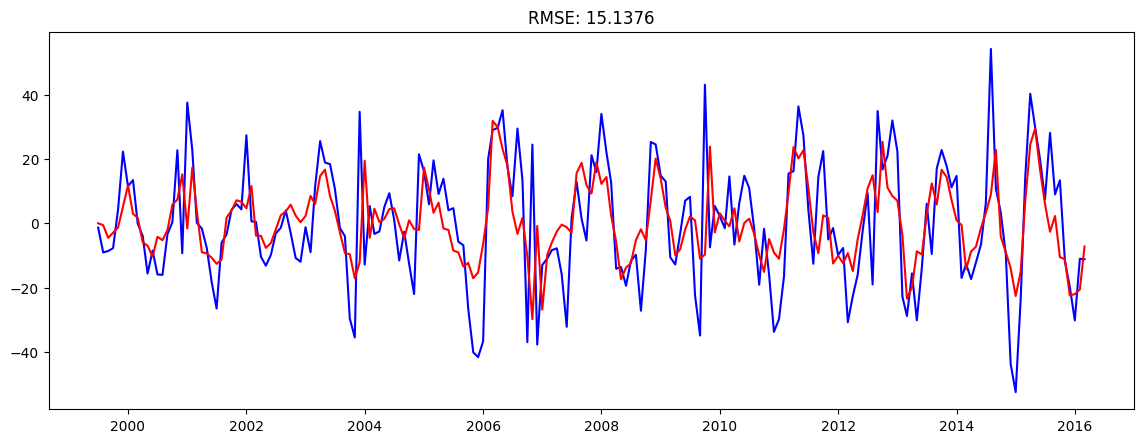

In [100]:
model = ARIMA(train, order=params_arma)
model_fit = model.fit(disp=-1)
plt.plot(train, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train)))

In [101]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  201
Model:                     ARMA(2, 1)   Log Likelihood                -832.175
Method:                       css-mle   S.D. of innovations             15.031
Date:                Thu, 08 Oct 2020   AIC                           1674.349
Time:                        21:22:27   BIC                           1690.866
Sample:                    07-01-1999   HQIC                          1681.032
                         - 03-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0273      0.074      0.367      0.713      -0.118       0.173
ar.L1.resid     1.3171      0.058     22.756      0.000       1.204       1.430
ar.L2.resid    -0.5585      0.058     -9.672    

In [102]:
# start_index = len(train)
# end_index = start_index + len(test)-1
# forecast = model_fit.predict(start=start_index, end=end_index)
# rmse_arma = np.sqrt(mean_squared_error(forecast, test))

In [103]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_arma)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_arma_decomp = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arma_decomp)

forecast = pd.Series(predictions, index=test.index)

predicted=-4.566905, expected=-3.886872
predicted=0.419786, expected=-16.355171
predicted=-2.857891, expected=-5.437879
predicted=4.430436, expected=-19.197029
predicted=0.837853, expected=3.212832
predicted=12.540042, expected=6.888654
predicted=12.841586, expected=7.199915
predicted=11.164082, expected=17.172524
predicted=12.768341, expected=29.223140
predicted=12.958466, expected=7.095885
predicted=-1.204085, expected=18.678253
predicted=1.186192, expected=-10.142377
Test RMSE: 12.183


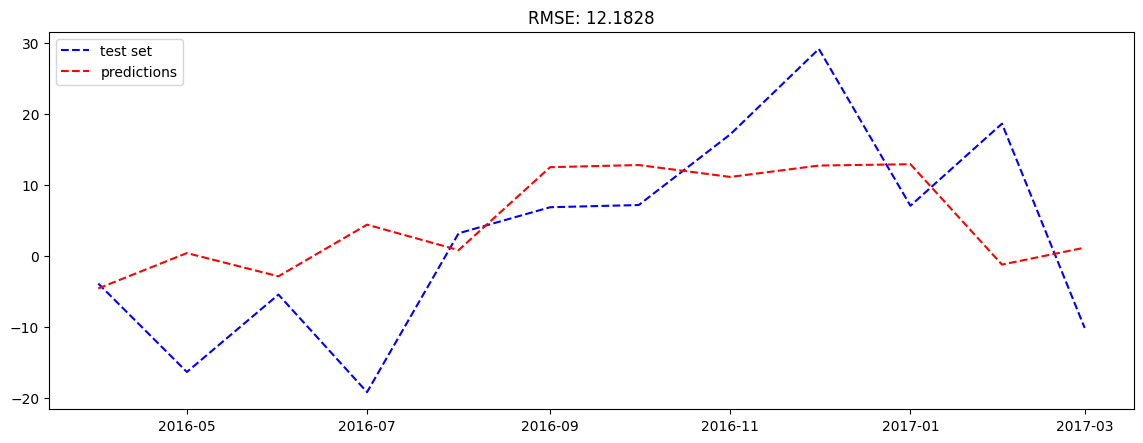

In [104]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_arma_decomp)
plt.legend(loc='upper left')
plt.show()

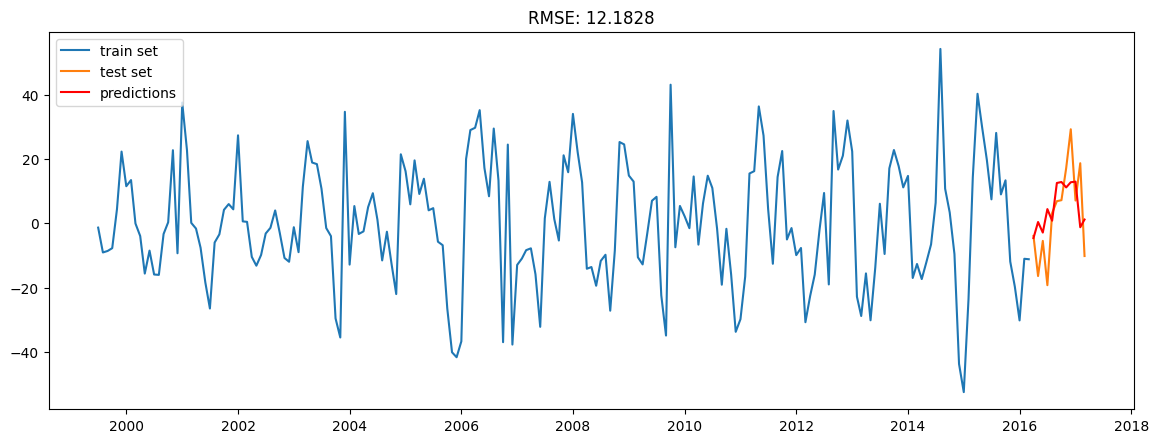

In [105]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_arma_decomp)
plt.legend(loc='upper left')
plt.show()

In [106]:
x = forecast + trend[-12:] + seasonal[-12:]
y = production[:-6]
np.sqrt(mean_squared_error(y[-12:], x))

12.182835243295145

### with differenced time series

In [107]:
pre_train = production_diff[:-36]
train = production_diff[:-12]
val = production_diff[-36:-12]
test = production_diff[-12:]

In [108]:
warnings.filterwarnings("ignore")
params_arma = validation(pre_train, val)

ARMA(0, 0, 0) RMSE=29.2468
ARMA(0, 0, 1) RMSE=28.5801
ARMA(0, 0, 2) RMSE=27.7769
ARMA(0, 0, 3) RMSE=27.9843
ARMA(0, 0, 4) RMSE=25.5722
ARMA(0, 0, 5) RMSE=24.8917
ARMA(0, 0, 6) RMSE=24.6240
ARMA(1, 0, 0) RMSE=28.3936
ARMA(1, 0, 1) RMSE=28.8805
ARMA(1, 0, 2) RMSE=27.1552
ARMA(1, 0, 3) RMSE=25.5715
ARMA(1, 0, 4) RMSE=24.9564
ARMA(2, 0, 0) RMSE=28.3312
ARMA(2, 0, 1) RMSE=25.5913
ARMA(2, 0, 2) RMSE=25.3184
ARMA(2, 0, 3) RMSE=27.9352
ARMA(2, 0, 4) RMSE=28.7665
ARMA(2, 0, 5) RMSE=27.1547
ARMA(4, 0, 0) RMSE=26.1956
ARMA(4, 0, 1) RMSE=25.7374
ARMA(6, 0, 0) RMSE=27.1761
ARMA(6, 0, 1) RMSE=26.8008
ARMA(6, 0, 2) RMSE=27.0489
ARMA(6, 0, 3) RMSE=26.7650
ARMA(8, 0, 0) RMSE=24.9394
ARMA(8, 0, 1) RMSE=24.4764
ARMA(8, 0, 2) RMSE=26.5448
Best ARMA(8, 0, 1) RMSE=24.4764


Text(0.5, 1.0, 'RMSE: 20.7229')

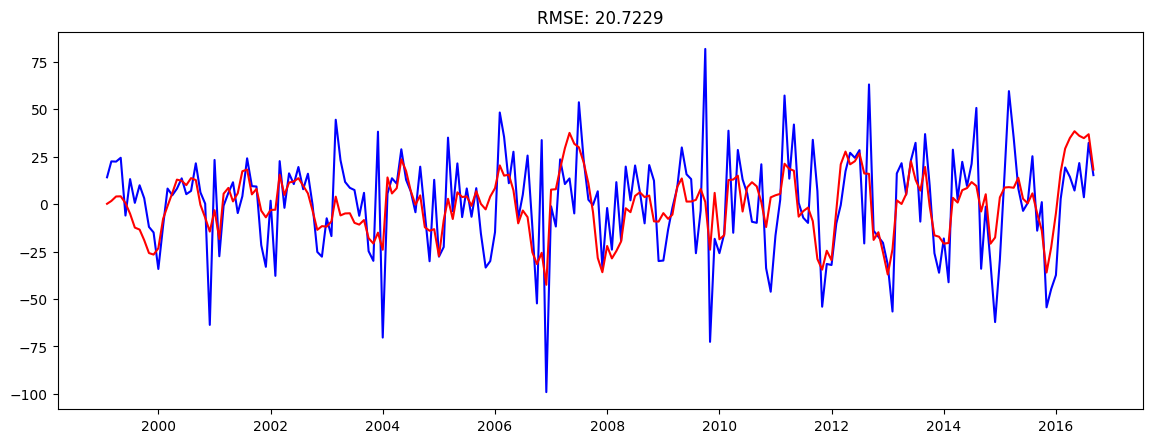

In [109]:
model = ARIMA(train, order=params_arma)
model_fit = model.fit(disp=-1)
plt.plot(train, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train)))

In [110]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             Production   No. Observations:                  212
Model:                     ARMA(8, 1)   Log Likelihood                -944.152
Method:                       css-mle   S.D. of innovations             20.623
Date:                Thu, 08 Oct 2020   AIC                           1910.303
Time:                        21:42:32   BIC                           1947.226
Sample:                    02-01-1999   HQIC                          1925.226
                         - 09-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1761      0.255      0.691      0.489      -0.323       0.676
ar.L1.Production     0.4539      0.128      3.554      0.000       0.204       0.704
ar.L2.Production     0.0444 

In [111]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params_arma)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_arma_differ = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arma_differ)

forecast = pd.Series(predictions, index=test.index)

predicted=-0.456582, expected=4.674000
predicted=-15.658401, expected=-10.815000
predicted=-24.191028, expected=-19.226000
predicted=-24.131751, expected=-43.071000
predicted=-12.779828, expected=2.937000
predicted=-12.908552, expected=-4.745000
predicted=-3.272637, expected=6.572000
predicted=2.704803, expected=9.260000
predicted=3.393935, expected=-19.845000
predicted=15.885762, expected=78.974000
predicted=-3.800154, expected=8.177000
predicted=9.802778, expected=2.438000
Test RMSE: 21.611


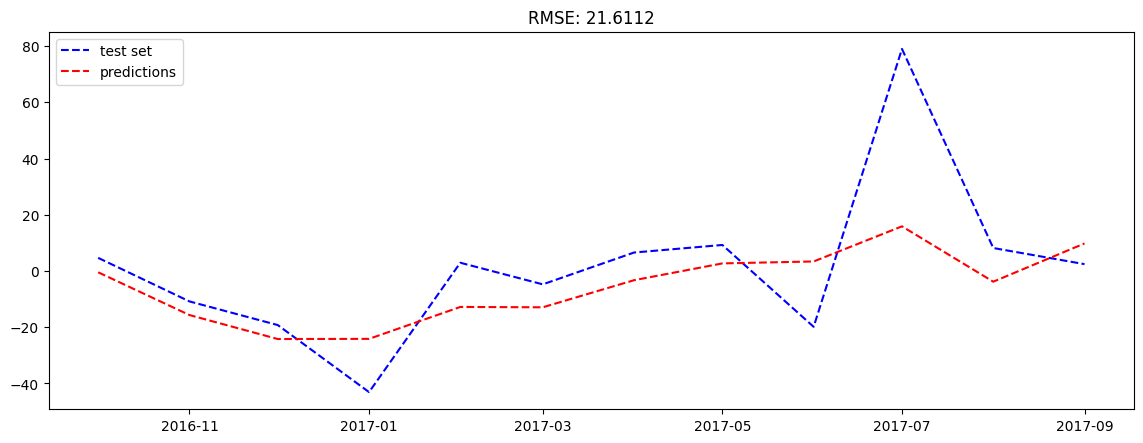

In [112]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 14, 5
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_arma_differ)
plt.legend(loc='upper left')
plt.show()

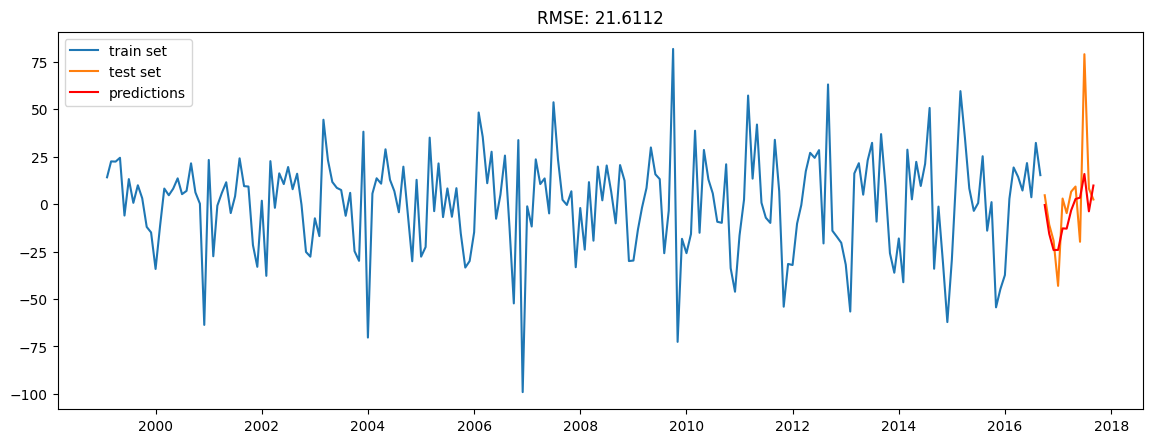

In [113]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_arma_differ)
plt.legend(loc='upper left')
plt.show()

In [114]:
x = forecast + production.shift(1)[-12:]
np.sqrt(mean_squared_error(production[-12:], x))

21.611231490967352

* **Prediction with decomposed time series gave better result.**

# ARIMA 

### validation

In [115]:
def run_arima(train, val, arima_order):
    history = [x for x in train.values]
    predictions = list()

    for t in range(len(val)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        y = model_fit.forecast()[0]
        predictions.append(y)
        history.append(val[t])
    
    return math.sqrt(mean_squared_error(val.values, predictions))
 
def validation(train, val):
    p_values = [0, 1, 2, 4, 6, 8]
    d_values = range(0, 3)
    q_values = range(0, 7)

    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = run_arima(train, val, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.4f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg

### test set prediction

### with decomposed time series

In [116]:
pre_train = production_decompose[:-36]
train = production_decompose[:-12]
val = production_decompose[-36:-12]
test = production_decompose[-12:]

In [117]:
warnings.filterwarnings("ignore")
params = validation(pre_train, val)

ARIMA(0, 0, 0) RMSE=24.8741
ARIMA(0, 0, 1) RMSE=21.0235
ARIMA(0, 0, 2) RMSE=20.0869
ARIMA(0, 0, 3) RMSE=20.0356
ARIMA(0, 0, 4) RMSE=20.1766
ARIMA(0, 0, 5) RMSE=17.8269
ARIMA(0, 0, 6) RMSE=17.1163
ARIMA(0, 1, 0) RMSE=21.6151
ARIMA(0, 1, 1) RMSE=23.6945
ARIMA(0, 1, 2) RMSE=21.2290
ARIMA(0, 1, 3) RMSE=20.2569
ARIMA(0, 1, 4) RMSE=20.1863
ARIMA(0, 1, 5) RMSE=20.3199
ARIMA(0, 1, 6) RMSE=17.8860
ARIMA(0, 2, 0) RMSE=29.5080
ARIMA(0, 2, 1) RMSE=21.7996
ARIMA(0, 2, 2) RMSE=23.8515
ARIMA(0, 2, 3) RMSE=21.2614
ARIMA(0, 2, 4) RMSE=20.2353
ARIMA(0, 2, 5) RMSE=20.1952
ARIMA(0, 2, 6) RMSE=20.3332
ARIMA(1, 0, 0) RMSE=20.1691
ARIMA(1, 0, 1) RMSE=20.3275
ARIMA(1, 0, 2) RMSE=19.9300
ARIMA(1, 1, 0) RMSE=23.2134
ARIMA(1, 1, 1) RMSE=20.3217
ARIMA(1, 1, 2) RMSE=20.5062
ARIMA(1, 2, 0) RMSE=26.6833
ARIMA(2, 0, 0) RMSE=20.4191
ARIMA(2, 0, 1) RMSE=16.6707
ARIMA(2, 0, 2) RMSE=18.5549
ARIMA(2, 1, 0) RMSE=23.7917
ARIMA(2, 1, 1) RMSE=20.6080
ARIMA(2, 2, 0) RMSE=28.4333
ARIMA(2, 2, 1) RMSE=23.9828
ARIMA(4, 0, 0) RMSE=

Text(0.5, 1.0, 'RMSE: 15.1376')

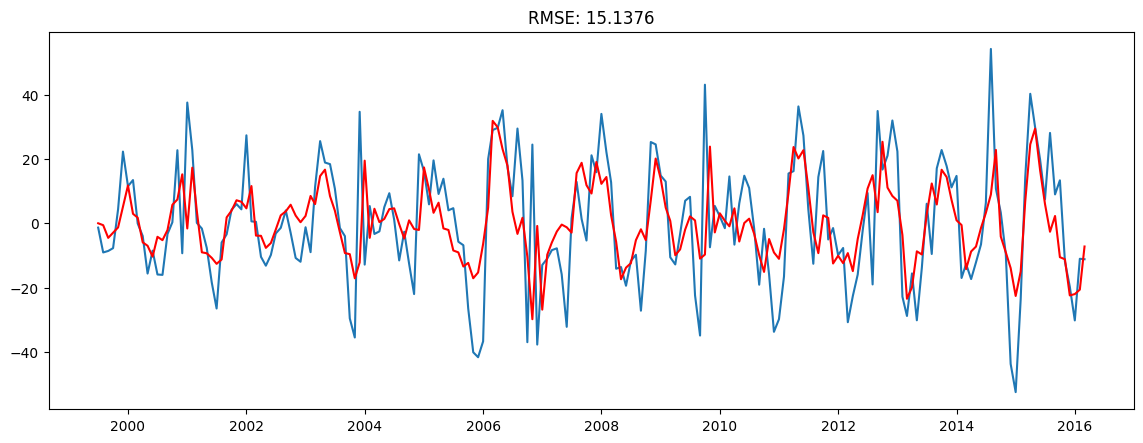

In [118]:
model = ARIMA(train, order=params)
model_fit = model.fit(disp=-1)
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train)))

In [119]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                  201
Model:                     ARMA(2, 1)   Log Likelihood                -832.175
Method:                       css-mle   S.D. of innovations             15.031
Date:                Thu, 08 Oct 2020   AIC                           1674.349
Time:                        22:49:44   BIC                           1690.866
Sample:                    07-01-1999   HQIC                          1681.032
                         - 03-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0273      0.074      0.367      0.713      -0.118       0.173
ar.L1.resid     1.3171      0.058     22.756      0.000       1.204       1.430
ar.L2.resid    -0.5585      0.058     -9.672    

In [ ]:
# start_index = len(train)
# end_index = start_index + len(test)-1
# forecast = model_fit.predict(start=start_index, end=end_index)
# rmse_arima = np.sqrt(sum((forecast-test)**2))

In [120]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_arima_decompose = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arima_decompose)

forecast = pd.Series(predictions, index=test.index)

predicted=-4.566905, expected=-3.886872
predicted=0.419786, expected=-16.355171
predicted=-2.857891, expected=-5.437879
predicted=4.430436, expected=-19.197029
predicted=0.837853, expected=3.212832
predicted=12.540042, expected=6.888654
predicted=12.841586, expected=7.199915
predicted=11.164082, expected=17.172524
predicted=12.768341, expected=29.223140
predicted=12.958466, expected=7.095885
predicted=-1.204085, expected=18.678253
predicted=1.186192, expected=-10.142377
Test RMSE: 12.183


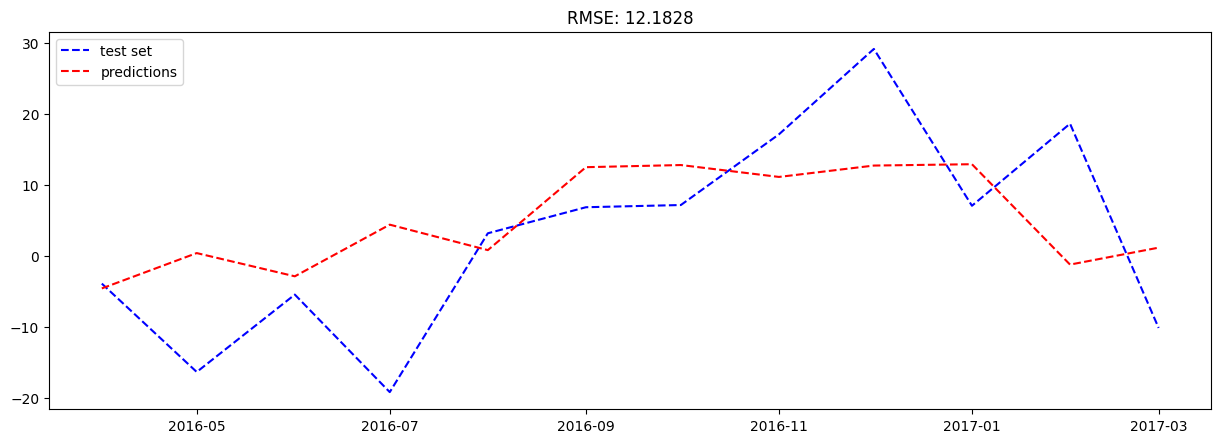

In [121]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
# plt.plot(train)
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_arima_decompose)
plt.legend(loc='upper left')
plt.show()

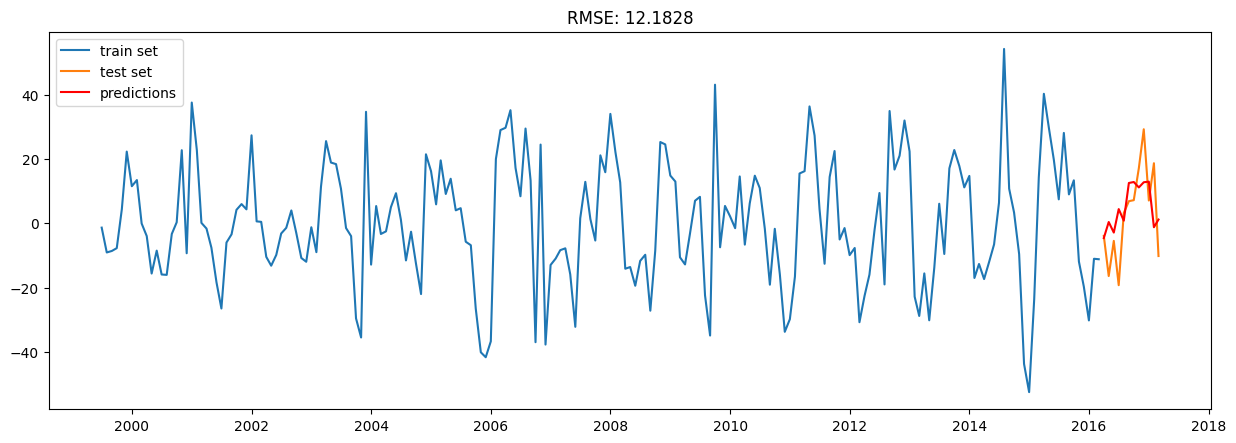

In [122]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_arima_decompose)
plt.legend(loc='upper left')
plt.show()

In [123]:
x = forecast + trend[-12:] + seasonal[-12:]
y = production[:-6]
np.sqrt(mean_squared_error(y[-12:], x))

12.182835243295145

### with differenced time series

In [138]:
pre_train = production_diff[:-36]
train = production_diff[:-12]
val = production_diff[-36:-12]
test = production_diff[-12:]

In [139]:
warnings.filterwarnings("ignore")
params = validation(pre_train, val)

ARIMA(0, 0, 0) RMSE=29.2468
ARIMA(0, 0, 1) RMSE=28.5801
ARIMA(0, 0, 2) RMSE=27.7769
ARIMA(0, 0, 3) RMSE=27.9843
ARIMA(0, 0, 4) RMSE=25.5722
ARIMA(0, 0, 5) RMSE=24.8917
ARIMA(0, 0, 6) RMSE=24.6240
ARIMA(0, 1, 0) RMSE=27.9357
ARIMA(0, 1, 1) RMSE=29.5415
ARIMA(0, 1, 2) RMSE=28.8045
ARIMA(0, 1, 3) RMSE=27.9779
ARIMA(0, 1, 4) RMSE=28.1635
ARIMA(0, 1, 5) RMSE=25.2376
ARIMA(0, 1, 6) RMSE=24.5928
ARIMA(0, 2, 0) RMSE=46.4802
ARIMA(0, 2, 1) RMSE=28.1191
ARIMA(0, 2, 2) RMSE=29.7013
ARIMA(0, 2, 3) RMSE=28.8877
ARIMA(0, 2, 4) RMSE=28.0396
ARIMA(0, 2, 5) RMSE=28.2008
ARIMA(0, 2, 6) RMSE=25.2576
ARIMA(1, 0, 0) RMSE=28.3936
ARIMA(1, 0, 1) RMSE=28.8805
ARIMA(1, 0, 2) RMSE=27.1552
ARIMA(1, 0, 3) RMSE=25.5715
ARIMA(1, 0, 4) RMSE=24.9564
ARIMA(1, 1, 0) RMSE=30.5076
ARIMA(1, 2, 0) RMSE=35.8369
ARIMA(2, 0, 0) RMSE=28.3312
ARIMA(2, 0, 1) RMSE=25.5913
ARIMA(2, 0, 2) RMSE=25.3184
ARIMA(2, 0, 3) RMSE=27.9352
ARIMA(2, 0, 4) RMSE=28.7665
ARIMA(2, 0, 5) RMSE=27.1547
ARIMA(2, 1, 0) RMSE=32.7432
ARIMA(2, 2, 0) RMSE=

In [140]:
train

1999-02-01    14.131
1999-03-01    22.514
1999-04-01    22.401
1999-05-01    24.415
1999-06-01    -6.017
               ...  
2016-05-01     7.164
2016-06-01    21.620
2016-07-01     3.621
2016-08-01    32.255
2016-09-01    15.267
Name: Production, Length: 212, dtype: float64

In [141]:
model_fit.fittedvalues

1999-03-01    -0.006556
1999-04-01    -4.352597
1999-05-01    -1.453653
1999-06-01    -1.715210
1999-07-01    17.222212
                ...    
2016-05-01    13.333406
2016-06-01     9.507162
2016-07-01    -8.045478
2016-08-01    17.717927
2016-09-01   -25.331299
Length: 211, dtype: float64

Text(0.5, 1.0, 'RMSE: 33.2672')

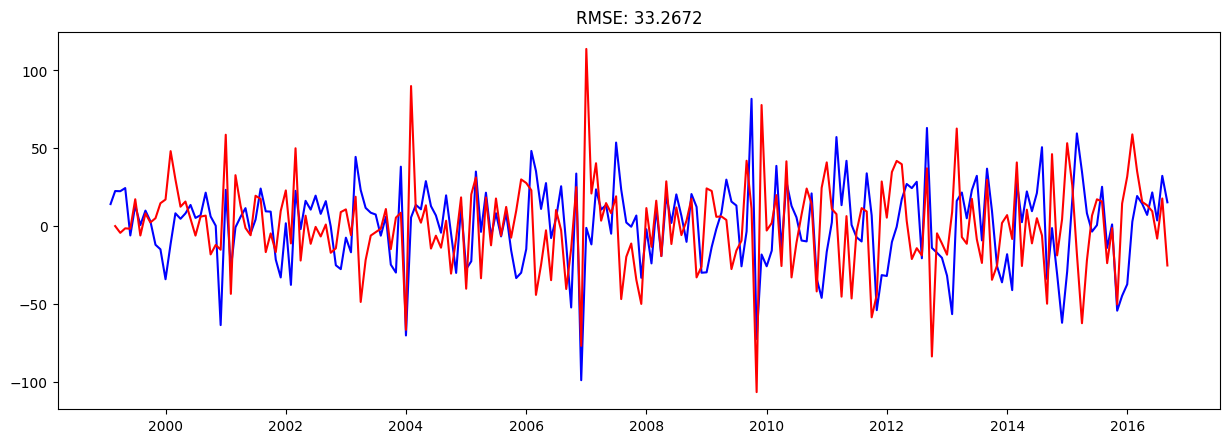

In [142]:
model = ARIMA(train, order=params)
model_fit = model.fit(disp=-1)
plt.plot(train, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(mean_squared_error(model_fit.fittedvalues, train[1:])))

In [143]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Production   No. Observations:                  211
Model:                 ARIMA(8, 1, 3)   Log Likelihood                -939.266
Method:                       css-mle   S.D. of innovations             20.203
Date:                Fri, 09 Oct 2020   AIC                           1904.533
Time:                        13:38:30   BIC                           1948.107
Sample:                    03-01-1999   HQIC                          1922.146
                         - 09-01-2016                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0066      0.008     -0.786      0.432      -0.023       0.010
ar.L1.D.Production     0.8080      0.108      7.473      0.000       0.596       1.020
ar.L2.D.Production  

In [144]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=params)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_arima_differ = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_arima_differ)

forecast = pd.Series(predictions, index=test.index)

predicted=-12.576117, expected=4.674000
predicted=-31.889272, expected=-10.815000
predicted=-38.791470, expected=-19.226000
predicted=-29.002647, expected=-43.071000
predicted=-7.710730, expected=2.937000
predicted=-2.400771, expected=-4.745000
predicted=6.583912, expected=6.572000
predicted=7.642198, expected=9.260000
predicted=5.418776, expected=-19.845000
predicted=16.637374, expected=78.974000
predicted=-4.298888, expected=8.177000
predicted=16.839101, expected=2.438000
Test RMSE: 22.969


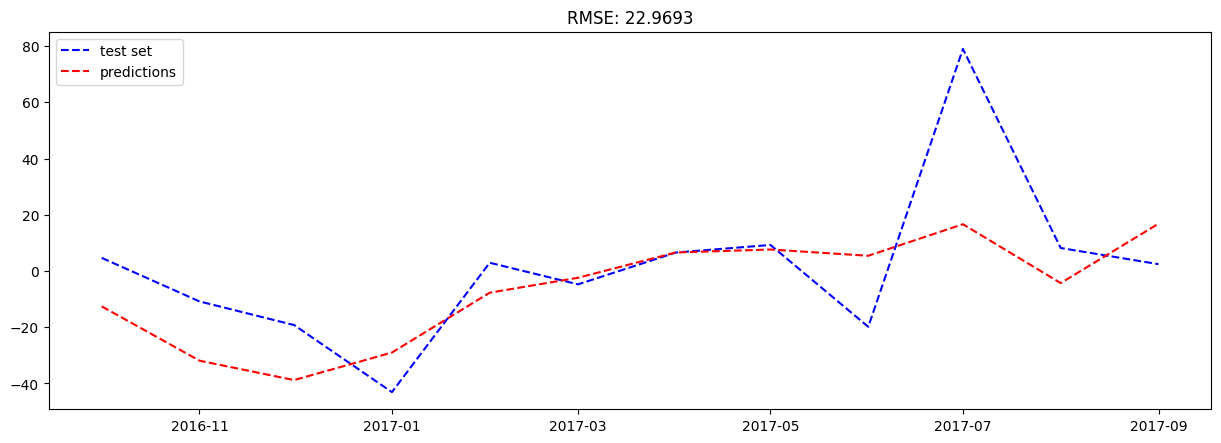

In [145]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
# plt.plot(train)
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_arima_differ)
plt.legend(loc='upper left')
plt.show()

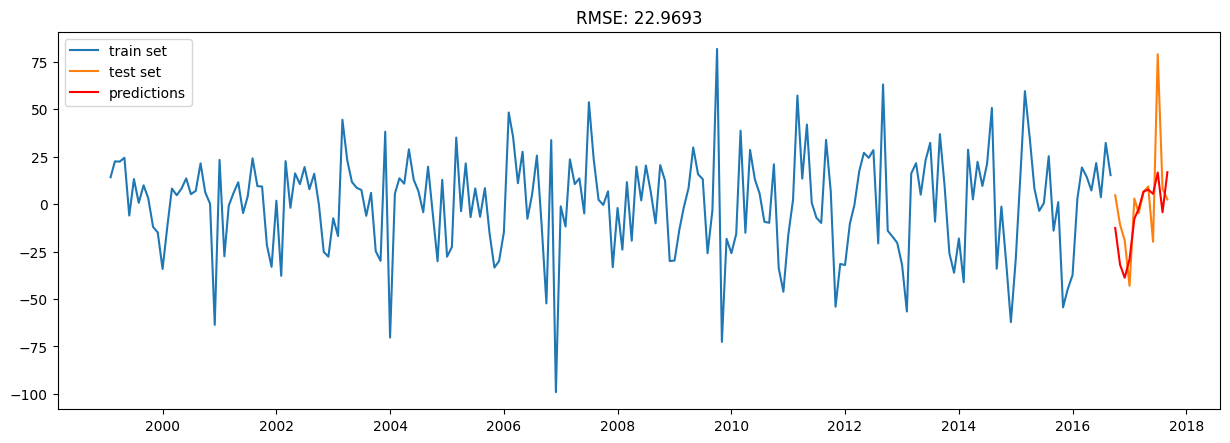

In [146]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_arima_differ)
plt.legend(loc='upper left')
plt.show()

In [147]:
x = forecast + production.shift(1)[-12:]
np.sqrt(mean_squared_error(production[-12:], x))

22.969286337936214

* **The smaller RMSE with decomposed time series.**

# SARIMA

SARIMA(p,d,q)(P,D,Q)m

In [148]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

### validation     

In [149]:
# SETUP (using itertools to gridsearch solutions)
import itertools

#set parameter range; feel free to update these!
p = q = range(0, 3)
d = range(0, 2)
season = 12

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = [(x[0], x[1], x[2], season) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} , {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} , {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) , (0, 0, 1, 12)
SARIMAX: (0, 0, 1) , (0, 0, 2, 12)
SARIMAX: (0, 0, 2) , (0, 1, 0, 12)
SARIMAX: (0, 0, 2) , (0, 1, 1, 12)


In [150]:
# APPLY (find optimal ARIMA for annual_
def validate(train, pdq, seasonal_pdq):
    trend = ['t', 'c', 'n', 'ct']
# UNCOMMENT THE FOLLOWING TO RUN (note: this can take awhile)
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    best_score, best_cfg = float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            for t in trend:
                try:
                    mod = SARIMAX(train,
                                order=param,
                                seasonal_order=param_seasonal,
                                trend=t,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

                    results = mod.fit()
                    if(results.aic < best_score):
                        best_score = results.aic
                        best_cfg = [param, param_seasonal, t]

                    print('ARIMA{},{}12, {}5 - AIC:{}'.format(param, param_seasonal, t, results.aic))
                except:
                    continue
    print('Best SARIMA%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg

### One more way to validate (WARNING!! It works for a very long time)

In [151]:
from math import sqrt

from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

 
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
def run_sarima(train, val, n_test, cfg, debug=False):
    result = None
    key = str(cfg)
    
    predictions = list()
    history = [x for x in train]

    for i in range(len(val)):
        order, sorder, trend = cfgii
        model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, 
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        yhat = model_fit.predict(len(history), len(history))[0]
        predictions.append(yhat)
        history.append(val[i])

    return sqrt(mean_squared_error(val, predictions))
 

def validation(pre_train, val, cfg_list, n_test, parallel=True):
    best_score, best_cfg = float("inf"), None
    for cfg in cfg_list:
        try :
            rmse = run_sarima(pre_train, val, n_test, cfg)
            if rmse < best_score:
                best_score, best_cfg = rmse, cfg
            print('SARIMA%s RMSE=%.4f' % (cfg, rmse))
        except:
            continue
    print('Best SARIMA%s RMSE=%.4f' % (best_cfg, best_score))

    return best_cfg,

def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2, 4]
    d_params = [0, 1]
    q_params = [0, 1, 2, 4]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models
# n_test =12
# cfg_list = sarima_configs(seasonal=[0, 12])
# warnings.filterwarnings("ignore")
# params_sarima = validation(pre_train, val, cfg_list, n_test)
# print(params_sarima)

### test set prediction

### with decomposed time-series

In [152]:
pre_train = production_decompose[:-36]
train = production_decompose[:-12]
val = production_decompose[-36:-12]
test = production_decompose[-12:]

In [153]:
params = validate(train, pdq, seasonal_pdq)

ARIMA(0, 0, 0),(0, 0, 0, 12)12, t5 - AIC:1749.8921105887782
ARIMA(0, 0, 0),(0, 0, 0, 12)12, c5 - AIC:1749.8892119239827
ARIMA(0, 0, 0),(0, 0, 0, 12)12, n5 - AIC:1747.8903256399294
ARIMA(0, 0, 0),(0, 0, 0, 12)12, ct5 - AIC:1751.8917287502745
ARIMA(0, 0, 0),(0, 0, 1, 12)12, t5 - AIC:1638.6209247749107
ARIMA(0, 0, 0),(0, 0, 1, 12)12, c5 - AIC:1638.6228697148294
ARIMA(0, 0, 0),(0, 0, 1, 12)12, n5 - AIC:1636.6373741731004
ARIMA(0, 0, 0),(0, 0, 1, 12)12, ct5 - AIC:1640.6207040010459
ARIMA(0, 0, 0),(0, 0, 2, 12)12, t5 - AIC:1536.5269036838135
ARIMA(0, 0, 0),(0, 0, 2, 12)12, c5 - AIC:1536.531600842608
ARIMA(0, 0, 0),(0, 0, 2, 12)12, n5 - AIC:1534.5339085265994
ARIMA(0, 0, 0),(0, 0, 2, 12)12, ct5 - AIC:1538.5238378746212
ARIMA(0, 0, 0),(0, 1, 0, 12)12, t5 - AIC:1724.5677344012063
ARIMA(0, 0, 0),(0, 1, 0, 12)12, c5 - AIC:1724.6138149109545
ARIMA(0, 0, 0),(0, 1, 0, 12)12, n5 - AIC:1722.6776906187924
ARIMA(0, 0, 0),(0, 1, 0, 12)12, ct5 - AIC:1726.5588971576683
ARIMA(0, 0, 0),(0, 1, 1, 12)12, t5 - 

ARIMA(0, 0, 1),(2, 1, 1, 12)12, c5 - AIC:1452.2252069111069
ARIMA(0, 0, 1),(2, 1, 1, 12)12, n5 - AIC:1450.268374043275
ARIMA(0, 0, 1),(2, 1, 1, 12)12, ct5 - AIC:1454.2235683726267
ARIMA(0, 0, 1),(2, 1, 2, 12)12, t5 - AIC:1435.5298723392907
ARIMA(0, 0, 1),(2, 1, 2, 12)12, c5 - AIC:1435.5283334863916
ARIMA(0, 0, 1),(2, 1, 2, 12)12, n5 - AIC:1433.5519429316837
ARIMA(0, 0, 1),(2, 1, 2, 12)12, ct5 - AIC:1437.5283436131226
ARIMA(0, 0, 2),(0, 0, 0, 12)12, t5 - AIC:1695.3698757039674
ARIMA(0, 0, 2),(0, 0, 0, 12)12, c5 - AIC:1695.371117026937
ARIMA(0, 0, 2),(0, 0, 0, 12)12, n5 - AIC:1693.371147950971
ARIMA(0, 0, 2),(0, 0, 0, 12)12, ct5 - AIC:1697.3716141594746
ARIMA(0, 0, 2),(0, 0, 1, 12)12, t5 - AIC:1589.934500853576
ARIMA(0, 0, 2),(0, 0, 1, 12)12, c5 - AIC:1589.9251654289953
ARIMA(0, 0, 2),(0, 0, 1, 12)12, n5 - AIC:1587.9362317924592
ARIMA(0, 0, 2),(0, 0, 1, 12)12, ct5 - AIC:1591.9370776966255
ARIMA(0, 0, 2),(0, 0, 2, 12)12, t5 - AIC:1491.4504335790934
ARIMA(0, 0, 2),(0, 0, 2, 12)12, c5 - AIC

ARIMA(0, 1, 0),(2, 0, 2, 12)12, n5 - AIC:1534.793912336511
ARIMA(0, 1, 0),(2, 0, 2, 12)12, ct5 - AIC:1538.7544752297854
ARIMA(0, 1, 0),(2, 1, 0, 12)12, t5 - AIC:1529.722572593958
ARIMA(0, 1, 0),(2, 1, 0, 12)12, c5 - AIC:1529.7203282758474
ARIMA(0, 1, 0),(2, 1, 0, 12)12, n5 - AIC:1527.7306051634105
ARIMA(0, 1, 0),(2, 1, 0, 12)12, ct5 - AIC:1531.7201818833669
ARIMA(0, 1, 0),(2, 1, 1, 12)12, t5 - AIC:1491.8844195232302
ARIMA(0, 1, 0),(2, 1, 1, 12)12, c5 - AIC:1491.876806093219
ARIMA(0, 1, 0),(2, 1, 1, 12)12, n5 - AIC:1489.9582694211451
ARIMA(0, 1, 0),(2, 1, 1, 12)12, ct5 - AIC:1493.8748708123276
ARIMA(0, 1, 0),(2, 1, 2, 12)12, t5 - AIC:1484.1549811622108
ARIMA(0, 1, 0),(2, 1, 2, 12)12, c5 - AIC:1484.153608674726
ARIMA(0, 1, 0),(2, 1, 2, 12)12, n5 - AIC:1482.234072317238
ARIMA(0, 1, 0),(2, 1, 2, 12)12, ct5 - AIC:1486.1782818988372
ARIMA(0, 1, 1),(0, 0, 0, 12)12, t5 - AIC:1737.3785215028065
ARIMA(0, 1, 1),(0, 0, 0, 12)12, c5 - AIC:1737.3934255099102
ARIMA(0, 1, 1),(0, 0, 0, 12)12, n5 - AIC:

ARIMA(0, 1, 2),(2, 0, 0, 12)12, ct5 - AIC:1516.1964870960787
ARIMA(0, 1, 2),(2, 0, 1, 12)12, t5 - AIC:1513.1596645486318
ARIMA(0, 1, 2),(2, 0, 1, 12)12, c5 - AIC:1506.0030211101762
ARIMA(0, 1, 2),(2, 0, 1, 12)12, n5 - AIC:1504.0324405399717
ARIMA(0, 1, 2),(2, 0, 1, 12)12, ct5 - AIC:1515.1379356103853
ARIMA(0, 1, 2),(2, 0, 2, 12)12, t5 - AIC:1487.6335920188078
ARIMA(0, 1, 2),(2, 0, 2, 12)12, c5 - AIC:1481.178163619098
ARIMA(0, 1, 2),(2, 0, 2, 12)12, n5 - AIC:1479.178596430855
ARIMA(0, 1, 2),(2, 0, 2, 12)12, ct5 - AIC:1490.2003965833344
ARIMA(0, 1, 2),(2, 1, 0, 12)12, t5 - AIC:1488.7312101454536
ARIMA(0, 1, 2),(2, 1, 0, 12)12, c5 - AIC:1487.8624835648989
ARIMA(0, 1, 2),(2, 1, 0, 12)12, n5 - AIC:1485.862617620618
ARIMA(0, 1, 2),(2, 1, 0, 12)12, ct5 - AIC:1492.8753532296532
ARIMA(0, 1, 2),(2, 1, 1, 12)12, t5 - AIC:1471.4788693798268
ARIMA(0, 1, 2),(2, 1, 1, 12)12, c5 - AIC:1453.877950367129
ARIMA(0, 1, 2),(2, 1, 1, 12)12, n5 - AIC:1451.8898912004288
ARIMA(0, 1, 2),(2, 1, 1, 12)12, ct5 - AI

ARIMA(1, 0, 1),(1, 1, 2, 12)12, t5 - AIC:1437.114290589228
ARIMA(1, 0, 1),(1, 1, 2, 12)12, c5 - AIC:1437.1012172688847
ARIMA(1, 0, 1),(1, 1, 2, 12)12, n5 - AIC:1435.1186780093167
ARIMA(1, 0, 1),(1, 1, 2, 12)12, ct5 - AIC:1439.3393241777562
ARIMA(1, 0, 1),(2, 0, 0, 12)12, t5 - AIC:1496.359477982406
ARIMA(1, 0, 1),(2, 0, 0, 12)12, c5 - AIC:1496.355111374777
ARIMA(1, 0, 1),(2, 0, 0, 12)12, n5 - AIC:1494.3603158429044
ARIMA(1, 0, 1),(2, 0, 0, 12)12, ct5 - AIC:1498.347174033552
ARIMA(1, 0, 1),(2, 0, 1, 12)12, t5 - AIC:1493.797813080756
ARIMA(1, 0, 1),(2, 0, 1, 12)12, c5 - AIC:1493.7966224947925
ARIMA(1, 0, 1),(2, 0, 1, 12)12, n5 - AIC:1491.7978385487872
ARIMA(1, 0, 1),(2, 0, 1, 12)12, ct5 - AIC:1495.7941435684718
ARIMA(1, 0, 1),(2, 0, 2, 12)12, t5 - AIC:1485.7835384354794
ARIMA(1, 0, 1),(2, 0, 2, 12)12, c5 - AIC:1485.782468275228
ARIMA(1, 0, 1),(2, 0, 2, 12)12, n5 - AIC:1483.7838332863557
ARIMA(1, 0, 1),(2, 0, 2, 12)12, ct5 - AIC:1487.7836044286587
ARIMA(1, 0, 1),(2, 1, 0, 12)12, t5 - AIC:1

ARIMA(1, 1, 0),(1, 1, 0, 12)12, c5 - AIC:1610.636811357123
ARIMA(1, 1, 0),(1, 1, 0, 12)12, n5 - AIC:1608.640493721654
ARIMA(1, 1, 0),(1, 1, 0, 12)12, ct5 - AIC:1612.632343971334
ARIMA(1, 1, 0),(1, 1, 1, 12)12, t5 - AIC:1582.3304155399512
ARIMA(1, 1, 0),(1, 1, 1, 12)12, c5 - AIC:1582.64697107657
ARIMA(1, 1, 0),(1, 1, 1, 12)12, n5 - AIC:1580.3508246861397
ARIMA(1, 1, 0),(1, 1, 1, 12)12, ct5 - AIC:1584.6438233966605
ARIMA(1, 1, 0),(1, 1, 2, 12)12, t5 - AIC:1473.246038133973
ARIMA(1, 1, 0),(1, 1, 2, 12)12, c5 - AIC:1473.2447398821719
ARIMA(1, 1, 0),(1, 1, 2, 12)12, n5 - AIC:1471.284370345863
ARIMA(1, 1, 0),(1, 1, 2, 12)12, ct5 - AIC:1475.270937148636
ARIMA(1, 1, 0),(2, 0, 0, 12)12, t5 - AIC:1529.4615086580066
ARIMA(1, 1, 0),(2, 0, 0, 12)12, c5 - AIC:1529.4772424003543
ARIMA(1, 1, 0),(2, 0, 0, 12)12, n5 - AIC:1527.4790502182136
ARIMA(1, 1, 0),(2, 0, 0, 12)12, ct5 - AIC:1531.426269685668
ARIMA(1, 1, 0),(2, 0, 1, 12)12, t5 - AIC:1527.2475206371175
ARIMA(1, 1, 0),(2, 0, 1, 12)12, c5 - AIC:1527

ARIMA(1, 1, 2),(1, 0, 1, 12)12, n5 - AIC:1588.5304951493795
ARIMA(1, 1, 2),(1, 0, 1, 12)12, ct5 - AIC:1597.2440264748393
ARIMA(1, 1, 2),(1, 0, 2, 12)12, t5 - AIC:1497.2237936485967
ARIMA(1, 1, 2),(1, 0, 2, 12)12, c5 - AIC:1488.997902536631
ARIMA(1, 1, 2),(1, 0, 2, 12)12, n5 - AIC:1486.9979705673352
ARIMA(1, 1, 2),(1, 0, 2, 12)12, ct5 - AIC:1496.9179971215895
ARIMA(1, 1, 2),(1, 1, 0, 12)12, t5 - AIC:1582.9756297435774
ARIMA(1, 1, 2),(1, 1, 0, 12)12, c5 - AIC:1578.7935082939593
ARIMA(1, 1, 2),(1, 1, 0, 12)12, n5 - AIC:1576.8194790370203
ARIMA(1, 1, 2),(1, 1, 0, 12)12, ct5 - AIC:1585.3268300185327
ARIMA(1, 1, 2),(1, 1, 1, 12)12, t5 - AIC:1550.898584127498
ARIMA(1, 1, 2),(1, 1, 1, 12)12, c5 - AIC:1535.130584394772
ARIMA(1, 1, 2),(1, 1, 1, 12)12, n5 - AIC:1533.1322030845135
ARIMA(1, 1, 2),(1, 1, 1, 12)12, ct5 - AIC:1563.2553132920618
ARIMA(1, 1, 2),(1, 1, 2, 12)12, t5 - AIC:1443.4888703325614
ARIMA(1, 1, 2),(1, 1, 2, 12)12, c5 - AIC:1428.425971141833
ARIMA(1, 1, 2),(1, 1, 2, 12)12, n5 - AIC

ARIMA(2, 0, 1),(0, 1, 2, 12)12, ct5 - AIC:1438.3262981421894
ARIMA(2, 0, 1),(1, 0, 0, 12)12, t5 - AIC:1601.9819628574705
ARIMA(2, 0, 1),(1, 0, 0, 12)12, c5 - AIC:1601.9726585413487
ARIMA(2, 0, 1),(1, 0, 0, 12)12, n5 - AIC:1599.982108328959
ARIMA(2, 0, 1),(1, 0, 0, 12)12, ct5 - AIC:1603.945620945853
ARIMA(2, 0, 1),(1, 0, 1, 12)12, t5 - AIC:1600.9711503742424
ARIMA(2, 0, 1),(1, 0, 1, 12)12, c5 - AIC:1600.963651777885
ARIMA(2, 0, 1),(1, 0, 1, 12)12, n5 - AIC:1598.971567528342
ARIMA(2, 0, 1),(1, 0, 1, 12)12, ct5 - AIC:1602.9481291307509
ARIMA(2, 0, 1),(1, 0, 2, 12)12, t5 - AIC:1498.7966949309475
ARIMA(2, 0, 1),(1, 0, 2, 12)12, c5 - AIC:1498.5389209936577
ARIMA(2, 0, 1),(1, 0, 2, 12)12, n5 - AIC:1496.353758490178
ARIMA(2, 0, 1),(1, 0, 2, 12)12, ct5 - AIC:1500.7865435743538
ARIMA(2, 0, 1),(1, 1, 0, 12)12, t5 - AIC:1574.299148142943
ARIMA(2, 0, 1),(1, 1, 0, 12)12, c5 - AIC:1576.0891289120464
ARIMA(2, 0, 1),(1, 1, 0, 12)12, n5 - AIC:1574.0900888742922
ARIMA(2, 0, 1),(1, 1, 0, 12)12, ct5 - AIC:

ARIMA(2, 1, 0),(0, 1, 1, 12)12, t5 - AIC:1581.6202648294538
ARIMA(2, 1, 0),(0, 1, 1, 12)12, c5 - AIC:1581.6211028639761
ARIMA(2, 1, 0),(0, 1, 1, 12)12, n5 - AIC:1579.6440923418882
ARIMA(2, 1, 0),(0, 1, 1, 12)12, ct5 - AIC:1583.6214370424764
ARIMA(2, 1, 0),(0, 1, 2, 12)12, t5 - AIC:1471.9687960976064
ARIMA(2, 1, 0),(0, 1, 2, 12)12, c5 - AIC:1471.966918917802
ARIMA(2, 1, 0),(0, 1, 2, 12)12, n5 - AIC:1470.0144509490217
ARIMA(2, 1, 0),(0, 1, 2, 12)12, ct5 - AIC:1473.9728523915132
ARIMA(2, 1, 0),(1, 0, 0, 12)12, t5 - AIC:1635.4305746771652
ARIMA(2, 1, 0),(1, 0, 0, 12)12, c5 - AIC:1635.4418605286264
ARIMA(2, 1, 0),(1, 0, 0, 12)12, n5 - AIC:1633.4434669304333
ARIMA(2, 1, 0),(1, 0, 0, 12)12, ct5 - AIC:1637.4120231976885
ARIMA(2, 1, 0),(1, 0, 1, 12)12, t5 - AIC:1634.1101846578208
ARIMA(2, 1, 0),(1, 0, 1, 12)12, c5 - AIC:1634.122025387263
ARIMA(2, 1, 0),(1, 0, 1, 12)12, n5 - AIC:1632.1254154824433
ARIMA(2, 1, 0),(1, 0, 1, 12)12, ct5 - AIC:1636.097329896722
ARIMA(2, 1, 0),(1, 0, 2, 12)12, t5 - AI

ARIMA(2, 1, 2),(0, 0, 2, 12)12, c5 - AIC:1491.4285262855194
ARIMA(2, 1, 2),(0, 0, 2, 12)12, n5 - AIC:1489.4337153195665
ARIMA(2, 1, 2),(0, 0, 2, 12)12, ct5 - AIC:1497.631030141954
ARIMA(2, 1, 2),(0, 1, 0, 12)12, t5 - AIC:1679.6524933084747
ARIMA(2, 1, 2),(0, 1, 0, 12)12, c5 - AIC:1677.1555169886474
ARIMA(2, 1, 2),(0, 1, 0, 12)12, n5 - AIC:1675.1812422717403
ARIMA(2, 1, 2),(0, 1, 0, 12)12, ct5 - AIC:1681.6066418272405
ARIMA(2, 1, 2),(0, 1, 1, 12)12, t5 - AIC:1549.5520860445163
ARIMA(2, 1, 2),(0, 1, 1, 12)12, c5 - AIC:1535.026547398545
ARIMA(2, 1, 2),(0, 1, 1, 12)12, n5 - AIC:1533.027948270963
ARIMA(2, 1, 2),(0, 1, 1, 12)12, ct5 - AIC:1552.2523123393441
ARIMA(2, 1, 2),(0, 1, 2, 12)12, t5 - AIC:1456.9587324882896
ARIMA(2, 1, 2),(0, 1, 2, 12)12, c5 - AIC:1427.2936547627014
ARIMA(2, 1, 2),(0, 1, 2, 12)12, n5 - AIC:1425.316695853936
ARIMA(2, 1, 2),(0, 1, 2, 12)12, ct5 - AIC:1446.360177544055
ARIMA(2, 1, 2),(1, 0, 0, 12)12, t5 - AIC:1605.6693496984176
ARIMA(2, 1, 2),(1, 0, 0, 12)12, c5 - AIC:

Text(0.5, 1.0, 'RMSE: 15.2193')

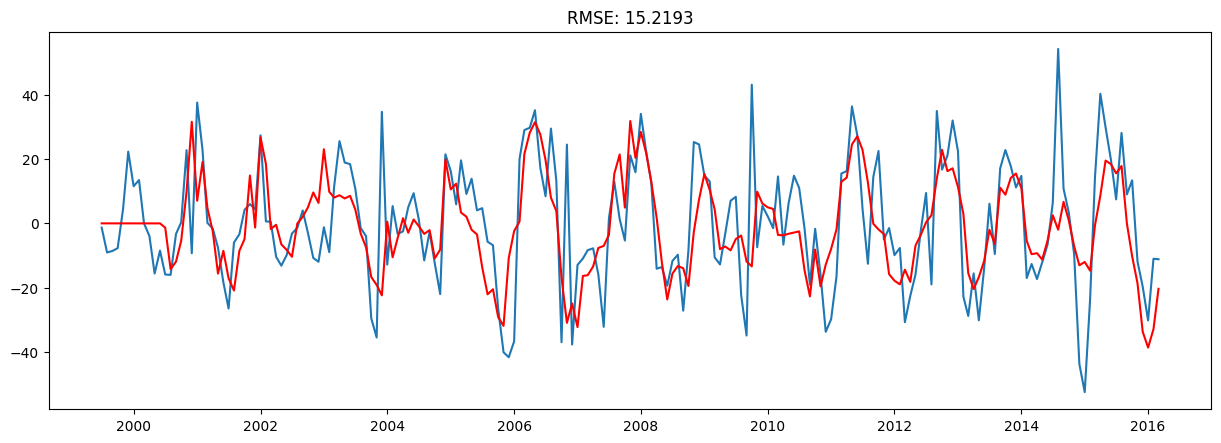

In [154]:
# ARIMA(2, 0, 2),(2, 1, 2, 12)12 - AIC:1380.7838523975797
# order, sorder, t = [(2,0,2), (2,1,2,12), 'c']
order, sorder, t = params

model = SARIMAX(train, 
            order=order, 
            seasonal_order=sorder, 
            trend=t)
# model_fit.summary()
model_fit = model.fit(disp=0)
rmse_sarima = np.sqrt(mean_squared_error(model_fit.fittedvalues, train))
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% rmse_sarima)

In [155]:
# order, sorder, trend = params_sarima
# model = SARIMAX(history, order=order, 
#                 seasonal_order=sorder, 
#                 trend=trend, 
#                 enforce_stationarity=False, 
#                 enforce_invertibility=False)
# model_fit = model.fit(disp=-1)
# plt.plot(train)
# plt.plot(model_fit.fittedvalues, color='red')
# plt.title('RMSE: %.4f'% np.sqrt(sum((model_fit.fittedvalues-train)**2)))

In [156]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              resid   No. Observations:                  201
Model:             SARIMAX(2, 0, 2)x(0, 1, 2, 12)   Log Likelihood                -787.915
Date:                            Fri, 09 Oct 2020   AIC                           1589.830
Time:                                    14:11:10   BIC                           1612.523
Sample:                                07-01-1999   HQIC                          1599.024
                                     - 03-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7312      0.040     42.772      0.000       1.652       1.810
ar.L2         -0.8908      0.039   

In [ ]:
# start_index = len(train)
# end_index = start_index + len(test)-1
# forecast = model_fit.predict(start=start_index, end=end_index)
# rmse_sarima = np.sqrt(mean_squared_error(forecast, test))
# rmse_sarima = np.sqrt(sum((forecast-test)**2))

In [158]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, 
            order=order, 
            seasonal_order=sorder, 
            trend=params[2])
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_sarima_decomp = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_sarima_decomp)

forecast = pd.Series(predictions, index=test.index)

predicted=-11.915041, expected=-3.886872
predicted=-9.378336, expected=-16.355171
predicted=-7.826104, expected=-5.437879
predicted=-2.685370, expected=-19.197029
predicted=4.840464, expected=3.212832
predicted=11.740468, expected=6.888654
predicted=20.233054, expected=7.199915
predicted=17.971058, expected=17.172524
predicted=20.365223, expected=29.223140
predicted=17.960359, expected=7.095885
predicted=14.728717, expected=18.678253
predicted=7.386900, expected=-10.142377
Test RMSE: 9.607


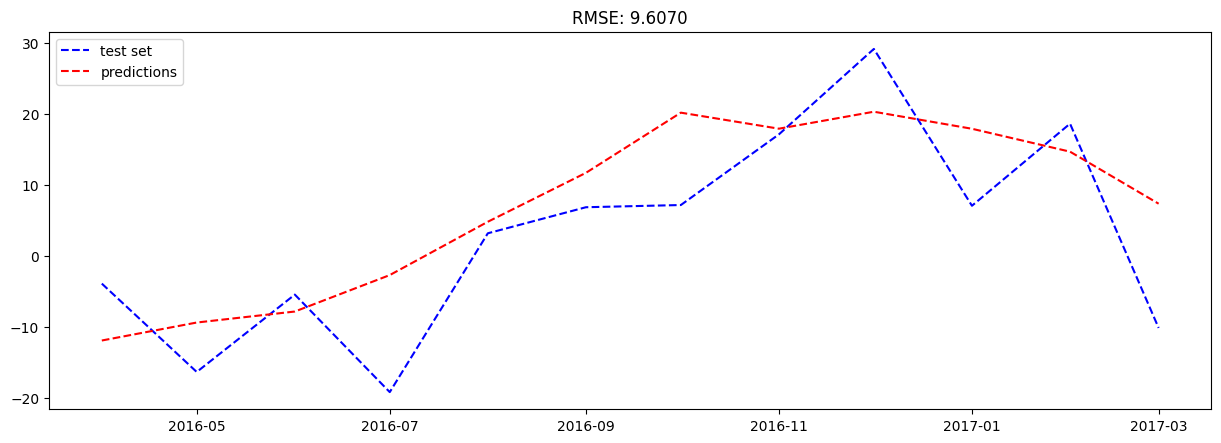

In [159]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
# plt.plot(train)
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_decomp)
plt.legend(loc='upper left')
plt.show()

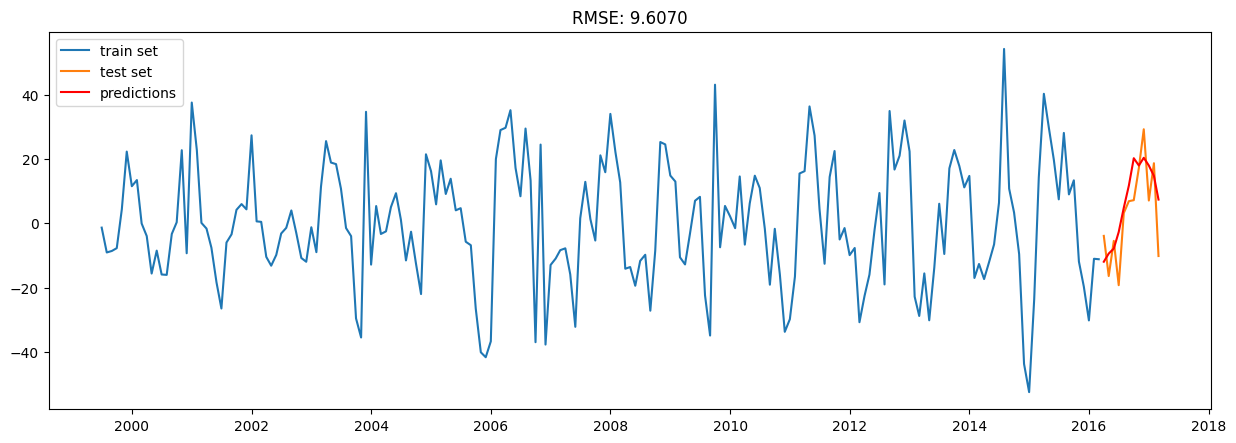

In [160]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_decomp)
plt.legend(loc='upper left')
plt.show()

In [161]:
print(forecast.values)
print(test.values)

[-11.91504142  -9.37833609  -7.82610355  -2.68537031   4.84046391
  11.74046791  20.23305369  17.97105832  20.36522302  17.96035947
  14.72871685   7.38690018]
[ -3.88687154 -16.35517056  -5.43787889 -19.19702936   3.21283176
   6.88865352   7.19991509  17.17252389  29.22313963   7.095885
  18.67825305 -10.14237658]


In [162]:
x = forecast + trend[-12:] + seasonal[-12:]
y = production[:-6]
np.sqrt(mean_squared_error(y[-12:], x))

9.606984234056196

### with differenced time series

In [163]:
pre_train = production_diff[:-36]
train = production_diff[:-12]
val = production_diff[-36:-12]
test = production_diff[-12:]

In [164]:
params = validate(train, pdq, seasonal_pdq)

ARIMA(0, 0, 0),(0, 0, 0, 12)12, t5 - AIC:1981.4869902464873
ARIMA(0, 0, 0),(0, 0, 0, 12)12, c5 - AIC:1981.4215209315003
ARIMA(0, 0, 0),(0, 0, 0, 12)12, n5 - AIC:1979.5433523333747
ARIMA(0, 0, 0),(0, 0, 0, 12)12, ct5 - AIC:1983.4056665057933
ARIMA(0, 0, 0),(0, 0, 1, 12)12, t5 - AIC:1832.0719740952713
ARIMA(0, 0, 0),(0, 0, 1, 12)12, c5 - AIC:1832.0409632578662
ARIMA(0, 0, 0),(0, 0, 1, 12)12, n5 - AIC:1830.0994188030209
ARIMA(0, 0, 0),(0, 0, 1, 12)12, ct5 - AIC:1834.0330858073423
ARIMA(0, 0, 0),(0, 0, 2, 12)12, t5 - AIC:1709.514277852401
ARIMA(0, 0, 0),(0, 0, 2, 12)12, c5 - AIC:1709.5127367346086
ARIMA(0, 0, 0),(0, 0, 2, 12)12, n5 - AIC:1707.5230324937047
ARIMA(0, 0, 0),(0, 0, 2, 12)12, ct5 - AIC:1711.5126979130014
ARIMA(0, 0, 0),(0, 1, 0, 12)12, t5 - AIC:1860.5670932433663
ARIMA(0, 0, 0),(0, 1, 0, 12)12, c5 - AIC:1860.5663998803093
ARIMA(0, 0, 0),(0, 1, 0, 12)12, n5 - AIC:1858.5766992333142
ARIMA(0, 0, 0),(0, 1, 0, 12)12, ct5 - AIC:1862.5661121833157
ARIMA(0, 0, 0),(0, 1, 1, 12)12, t5 - 

ARIMA(0, 0, 1),(2, 1, 1, 12)12, c5 - AIC:1589.4841528842137
ARIMA(0, 0, 1),(2, 1, 1, 12)12, n5 - AIC:1587.485088205372
ARIMA(0, 0, 1),(2, 1, 1, 12)12, ct5 - AIC:1591.2639283064686
ARIMA(0, 0, 1),(2, 1, 2, 12)12, t5 - AIC:1573.6332266719571
ARIMA(0, 0, 1),(2, 1, 2, 12)12, c5 - AIC:1573.6209813784171
ARIMA(0, 0, 1),(2, 1, 2, 12)12, n5 - AIC:1571.6210047248978
ARIMA(0, 0, 1),(2, 1, 2, 12)12, ct5 - AIC:1575.4437462798414
ARIMA(0, 0, 2),(0, 0, 0, 12)12, t5 - AIC:1959.0160528454498
ARIMA(0, 0, 2),(0, 0, 0, 12)12, c5 - AIC:1959.019839746055
ARIMA(0, 0, 2),(0, 0, 0, 12)12, n5 - AIC:1957.0651512655863
ARIMA(0, 0, 2),(0, 0, 0, 12)12, ct5 - AIC:1961.014399558233
ARIMA(0, 0, 2),(0, 0, 1, 12)12, t5 - AIC:1815.0400190125351
ARIMA(0, 0, 2),(0, 0, 1, 12)12, c5 - AIC:1815.0243119204933
ARIMA(0, 0, 2),(0, 0, 1, 12)12, n5 - AIC:1813.07018390451
ARIMA(0, 0, 2),(0, 0, 1, 12)12, ct5 - AIC:1817.0230921530328
ARIMA(0, 0, 2),(0, 0, 2, 12)12, t5 - AIC:1692.5134253899193
ARIMA(0, 0, 2),(0, 0, 2, 12)12, c5 - AIC:

ARIMA(0, 1, 0),(2, 0, 2, 12)12, n5 - AIC:1835.1925416549943
ARIMA(0, 1, 0),(2, 0, 2, 12)12, ct5 - AIC:1839.179128614282
ARIMA(0, 1, 0),(2, 1, 0, 12)12, t5 - AIC:1793.907101575296
ARIMA(0, 1, 0),(2, 1, 0, 12)12, c5 - AIC:1793.9082128773166
ARIMA(0, 1, 0),(2, 1, 0, 12)12, n5 - AIC:1791.9157182141637
ARIMA(0, 1, 0),(2, 1, 0, 12)12, ct5 - AIC:1795.907611617175
ARIMA(0, 1, 0),(2, 1, 1, 12)12, t5 - AIC:1750.9531129590346
ARIMA(0, 1, 0),(2, 1, 1, 12)12, c5 - AIC:1750.9531854465338
ARIMA(0, 1, 0),(2, 1, 1, 12)12, n5 - AIC:1748.9531855297998
ARIMA(0, 1, 0),(2, 1, 1, 12)12, ct5 - AIC:1752.9556244989094
ARIMA(0, 1, 0),(2, 1, 2, 12)12, t5 - AIC:1741.713065595563
ARIMA(0, 1, 0),(2, 1, 2, 12)12, c5 - AIC:1741.7122584991703
ARIMA(0, 1, 0),(2, 1, 2, 12)12, n5 - AIC:1739.7131697027426
ARIMA(0, 1, 0),(2, 1, 2, 12)12, ct5 - AIC:1743.674294106616
ARIMA(0, 1, 1),(0, 0, 0, 12)12, t5 - AIC:1971.327048917703
ARIMA(0, 1, 1),(0, 0, 0, 12)12, c5 - AIC:1971.3114366943041
ARIMA(0, 1, 1),(0, 0, 0, 12)12, n5 - AIC:1

ARIMA(0, 1, 2),(2, 0, 0, 12)12, ct5 - AIC:1735.3641128972488
ARIMA(0, 1, 2),(2, 0, 1, 12)12, t5 - AIC:1736.2398472683342
ARIMA(0, 1, 2),(2, 0, 1, 12)12, c5 - AIC:1704.4886371240186
ARIMA(0, 1, 2),(2, 0, 1, 12)12, n5 - AIC:1710.769349376916
ARIMA(0, 1, 2),(2, 0, 1, 12)12, ct5 - AIC:1737.0057961666328
ARIMA(0, 1, 2),(2, 0, 2, 12)12, t5 - AIC:1708.557494202364
ARIMA(0, 1, 2),(2, 0, 2, 12)12, c5 - AIC:1673.0932271066806
ARIMA(0, 1, 2),(2, 0, 2, 12)12, n5 - AIC:1668.5239707348928
ARIMA(0, 1, 2),(2, 0, 2, 12)12, ct5 - AIC:1712.8926676177925
ARIMA(0, 1, 2),(2, 1, 0, 12)12, t5 - AIC:1634.949627749238
ARIMA(0, 1, 2),(2, 1, 0, 12)12, c5 - AIC:1626.0407702172251
ARIMA(0, 1, 2),(2, 1, 0, 12)12, n5 - AIC:1624.1476246791694
ARIMA(0, 1, 2),(2, 1, 0, 12)12, ct5 - AIC:1637.0203223464928
ARIMA(0, 1, 2),(2, 1, 1, 12)12, t5 - AIC:1632.8537354053967
ARIMA(0, 1, 2),(2, 1, 1, 12)12, c5 - AIC:1591.9492695691
ARIMA(0, 1, 2),(2, 1, 1, 12)12, n5 - AIC:1590.157725435037
ARIMA(0, 1, 2),(2, 1, 1, 12)12, ct5 - AIC:1

ARIMA(1, 0, 1),(1, 1, 2, 12)12, t5 - AIC:1577.454421381014
ARIMA(1, 0, 1),(1, 1, 2, 12)12, c5 - AIC:1576.356045966586
ARIMA(1, 0, 1),(1, 1, 2, 12)12, n5 - AIC:1574.37330071093
ARIMA(1, 0, 1),(1, 1, 2, 12)12, ct5 - AIC:1579.4154022081432
ARIMA(1, 0, 1),(2, 0, 0, 12)12, t5 - AIC:1704.8722809148762
ARIMA(1, 0, 1),(2, 0, 0, 12)12, c5 - AIC:1704.8700292973886
ARIMA(1, 0, 1),(2, 0, 0, 12)12, n5 - AIC:1702.8727629206949
ARIMA(1, 0, 1),(2, 0, 0, 12)12, ct5 - AIC:1706.8679533503482
ARIMA(1, 0, 1),(2, 0, 1, 12)12, t5 - AIC:1706.8229198102094
ARIMA(1, 0, 1),(2, 0, 1, 12)12, c5 - AIC:1706.8196224330663
ARIMA(1, 0, 1),(2, 0, 1, 12)12, n5 - AIC:1704.8233299461738
ARIMA(1, 0, 1),(2, 0, 1, 12)12, ct5 - AIC:1708.8160771272833
ARIMA(1, 0, 1),(2, 0, 2, 12)12, t5 - AIC:1683.041826523504
ARIMA(1, 0, 1),(2, 0, 2, 12)12, c5 - AIC:1678.7349515523927
ARIMA(1, 0, 1),(2, 0, 2, 12)12, n5 - AIC:1676.8206884915405
ARIMA(1, 0, 1),(2, 0, 2, 12)12, ct5 - AIC:1680.978566204209
ARIMA(1, 0, 1),(2, 1, 0, 12)12, t5 - AIC:1

ARIMA(1, 1, 0),(1, 1, 0, 12)12, c5 - AIC:1807.4640772778832
ARIMA(1, 1, 0),(1, 1, 0, 12)12, n5 - AIC:1805.4865460596156
ARIMA(1, 1, 0),(1, 1, 0, 12)12, ct5 - AIC:1809.463162058812
ARIMA(1, 1, 0),(1, 1, 1, 12)12, t5 - AIC:1774.999420591381
ARIMA(1, 1, 0),(1, 1, 1, 12)12, c5 - AIC:1775.004400803849
ARIMA(1, 1, 0),(1, 1, 1, 12)12, n5 - AIC:1773.0280236134104
ARIMA(1, 1, 0),(1, 1, 1, 12)12, ct5 - AIC:1777.2280085649368
ARIMA(1, 1, 0),(1, 1, 2, 12)12, t5 - AIC:1660.708531622849
ARIMA(1, 1, 0),(1, 1, 2, 12)12, c5 - AIC:1660.7163508051055
ARIMA(1, 1, 0),(1, 1, 2, 12)12, n5 - AIC:1658.7199325450931
ARIMA(1, 1, 0),(1, 1, 2, 12)12, ct5 - AIC:1662.6896127922778
ARIMA(1, 1, 0),(2, 0, 0, 12)12, t5 - AIC:1768.8320788925826
ARIMA(1, 1, 0),(2, 0, 0, 12)12, c5 - AIC:1768.8373148914075
ARIMA(1, 1, 0),(2, 0, 0, 12)12, n5 - AIC:1766.8563683980458
ARIMA(1, 1, 0),(2, 0, 0, 12)12, ct5 - AIC:1770.83198996333
ARIMA(1, 1, 0),(2, 0, 1, 12)12, t5 - AIC:1770.8306758479066
ARIMA(1, 1, 0),(2, 0, 1, 12)12, c5 - AIC:1

ARIMA(1, 1, 2),(1, 0, 1, 12)12, n5 - AIC:1767.7650048382175
ARIMA(1, 1, 2),(1, 0, 1, 12)12, ct5 - AIC:1818.5880092720272
ARIMA(1, 1, 2),(1, 0, 2, 12)12, t5 - AIC:1701.4418097807052
ARIMA(1, 1, 2),(1, 0, 2, 12)12, c5 - AIC:1666.4211883711687
ARIMA(1, 1, 2),(1, 0, 2, 12)12, n5 - AIC:1659.3891317162784
ARIMA(1, 1, 2),(1, 0, 2, 12)12, ct5 - AIC:1711.7211031450877
ARIMA(1, 1, 2),(1, 1, 0, 12)12, t5 - AIC:1735.2305310627805
ARIMA(1, 1, 2),(1, 1, 0, 12)12, c5 - AIC:1711.920293383925
ARIMA(1, 1, 2),(1, 1, 0, 12)12, n5 - AIC:1724.929141141693
ARIMA(1, 1, 2),(1, 1, 0, 12)12, ct5 - AIC:1736.819909741601
ARIMA(1, 1, 2),(1, 1, 1, 12)12, t5 - AIC:1703.3678391057663
ARIMA(1, 1, 2),(1, 1, 1, 12)12, c5 - AIC:1667.1641737303132
ARIMA(1, 1, 2),(1, 1, 1, 12)12, n5 - AIC:1662.1369801912956
ARIMA(1, 1, 2),(1, 1, 1, 12)12, ct5 - AIC:1702.1212925413874
ARIMA(1, 1, 2),(1, 1, 2, 12)12, t5 - AIC:1591.3814590170157
ARIMA(1, 1, 2),(1, 1, 2, 12)12, c5 - AIC:1568.1658660845515
ARIMA(1, 1, 2),(1, 1, 2, 12)12, n5 - AI

ARIMA(2, 0, 1),(0, 1, 2, 12)12, ct5 - AIC:1609.9407968769233
ARIMA(2, 0, 1),(1, 0, 0, 12)12, t5 - AIC:1803.9843475584921
ARIMA(2, 0, 1),(1, 0, 0, 12)12, c5 - AIC:1803.9747937201864
ARIMA(2, 0, 1),(1, 0, 0, 12)12, n5 - AIC:1801.9874587771394
ARIMA(2, 0, 1),(1, 0, 0, 12)12, ct5 - AIC:1805.96507836149
ARIMA(2, 0, 1),(1, 0, 1, 12)12, t5 - AIC:1775.0489055513015
ARIMA(2, 0, 1),(1, 0, 1, 12)12, c5 - AIC:1782.42004799595
ARIMA(2, 0, 1),(1, 0, 1, 12)12, n5 - AIC:1772.5681383904664
ARIMA(2, 0, 1),(1, 0, 1, 12)12, ct5 - AIC:1792.114224864292
ARIMA(2, 0, 1),(1, 0, 2, 12)12, t5 - AIC:1680.7169555707783
ARIMA(2, 0, 1),(1, 0, 2, 12)12, c5 - AIC:1680.6496095596913
ARIMA(2, 0, 1),(1, 0, 2, 12)12, n5 - AIC:1678.6957211181493
ARIMA(2, 0, 1),(1, 0, 2, 12)12, ct5 - AIC:1682.628416461851
ARIMA(2, 0, 1),(1, 1, 0, 12)12, t5 - AIC:1720.2045280636685
ARIMA(2, 0, 1),(1, 1, 0, 12)12, c5 - AIC:1720.2255537827555
ARIMA(2, 0, 1),(1, 1, 0, 12)12, n5 - AIC:1718.2378774506692
ARIMA(2, 0, 1),(1, 1, 0, 12)12, ct5 - AIC:

ARIMA(2, 1, 0),(0, 1, 1, 12)12, t5 - AIC:1740.1541827260664
ARIMA(2, 1, 0),(0, 1, 1, 12)12, c5 - AIC:1740.159158325865
ARIMA(2, 1, 0),(0, 1, 1, 12)12, n5 - AIC:1738.215321528195
ARIMA(2, 1, 0),(0, 1, 1, 12)12, ct5 - AIC:1742.1549085907864
ARIMA(2, 1, 0),(0, 1, 2, 12)12, t5 - AIC:1626.128416784606
ARIMA(2, 1, 0),(0, 1, 2, 12)12, c5 - AIC:1626.142106616345
ARIMA(2, 1, 0),(0, 1, 2, 12)12, n5 - AIC:1624.154834358018
ARIMA(2, 1, 0),(0, 1, 2, 12)12, ct5 - AIC:1628.122016440231
ARIMA(2, 1, 0),(1, 0, 0, 12)12, t5 - AIC:1847.012090055373
ARIMA(2, 1, 0),(1, 0, 0, 12)12, c5 - AIC:1847.021159112282
ARIMA(2, 1, 0),(1, 0, 0, 12)12, n5 - AIC:1845.0478016368904
ARIMA(2, 1, 0),(1, 0, 0, 12)12, ct5 - AIC:1849.011936638979
ARIMA(2, 1, 0),(1, 0, 1, 12)12, t5 - AIC:1844.987658602969
ARIMA(2, 1, 0),(1, 0, 1, 12)12, c5 - AIC:1848.8273775062003
ARIMA(2, 1, 0),(1, 0, 1, 12)12, n5 - AIC:1846.8565814030346
ARIMA(2, 1, 0),(1, 0, 1, 12)12, ct5 - AIC:1846.9822528032107
ARIMA(2, 1, 0),(1, 0, 2, 12)12, t5 - AIC:1735.

ARIMA(2, 1, 2),(0, 0, 2, 12)12, c5 - AIC:1692.949508522552
ARIMA(2, 1, 2),(0, 0, 2, 12)12, n5 - AIC:1690.9538359399612
ARIMA(2, 1, 2),(0, 0, 2, 12)12, ct5 - AIC:1715.0957303476891
ARIMA(2, 1, 2),(0, 1, 0, 12)12, t5 - AIC:1831.791379478021
ARIMA(2, 1, 2),(0, 1, 0, 12)12, c5 - AIC:1828.1443195025872
ARIMA(2, 1, 2),(0, 1, 0, 12)12, n5 - AIC:1826.1448147731408
ARIMA(2, 1, 2),(0, 1, 0, 12)12, ct5 - AIC:1836.8854238039567
ARIMA(2, 1, 2),(0, 1, 1, 12)12, t5 - AIC:1694.8444884530463
ARIMA(2, 1, 2),(0, 1, 1, 12)12, c5 - AIC:1673.3811919779955
ARIMA(2, 1, 2),(0, 1, 1, 12)12, n5 - AIC:1671.3989742402296
ARIMA(2, 1, 2),(0, 1, 1, 12)12, ct5 - AIC:1696.5531346895216
ARIMA(2, 1, 2),(0, 1, 2, 12)12, t5 - AIC:1588.456831411846
ARIMA(2, 1, 2),(0, 1, 2, 12)12, c5 - AIC:1566.9921780381842
ARIMA(2, 1, 2),(0, 1, 2, 12)12, n5 - AIC:1565.0605049241362
ARIMA(2, 1, 2),(0, 1, 2, 12)12, ct5 - AIC:1589.521947579196
ARIMA(2, 1, 2),(1, 0, 0, 12)12, t5 - AIC:1827.542400117287
ARIMA(2, 1, 2),(1, 0, 0, 12)12, c5 - AIC:

Text(0.5, 1.0, 'RMSE: 20.7891')

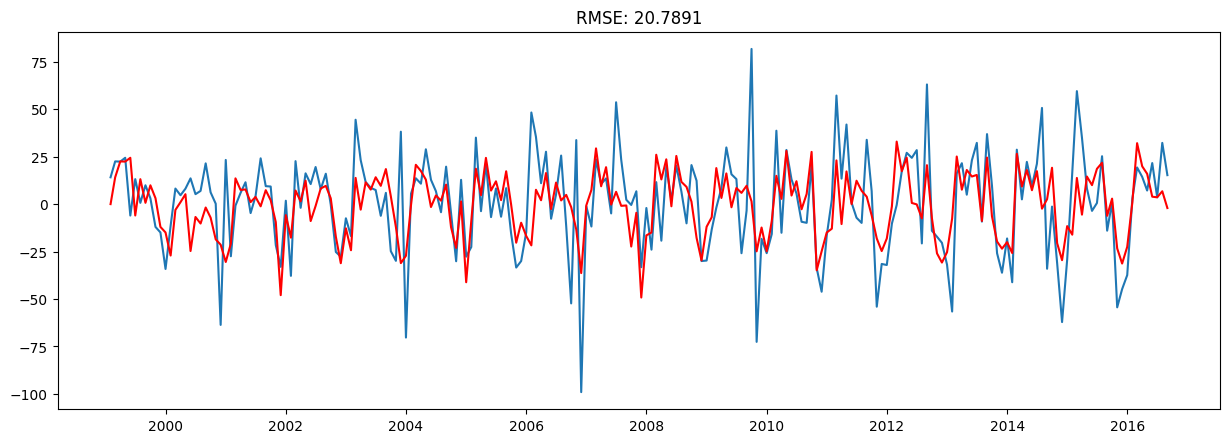

In [165]:
# order, sorder, t = [(2,0,2), (2,1,2,12), 'c']
order, sorder, t = params

model = SARIMAX(train, 
            order=order, 
            seasonal_order=sorder, 
            trend=t)
# model_fit.summary()
model_fit = model.fit(disp=0)
rmse_sarima = np.sqrt(mean_squared_error(model_fit.fittedvalues, train))
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% rmse_sarima)

In [166]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, 
            order=order, 
            seasonal_order=sorder, 
            trend=params[2])
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_sarima_diff = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_sarima_diff)

forecast = pd.Series(predictions, index=test.index)

predicted=-0.827935, expected=4.674000
predicted=-32.768464, expected=-10.815000
predicted=-38.695175, expected=-19.226000
predicted=-29.255500, expected=-43.071000
predicted=-5.152541, expected=2.937000
predicted=16.819067, expected=-4.745000
predicted=14.453502, expected=6.572000
predicted=17.299031, expected=9.260000
predicted=13.216270, expected=-19.845000
predicted=19.166065, expected=78.974000
predicted=-5.918704, expected=8.177000
predicted=11.666978, expected=2.438000
Test RMSE: 23.617


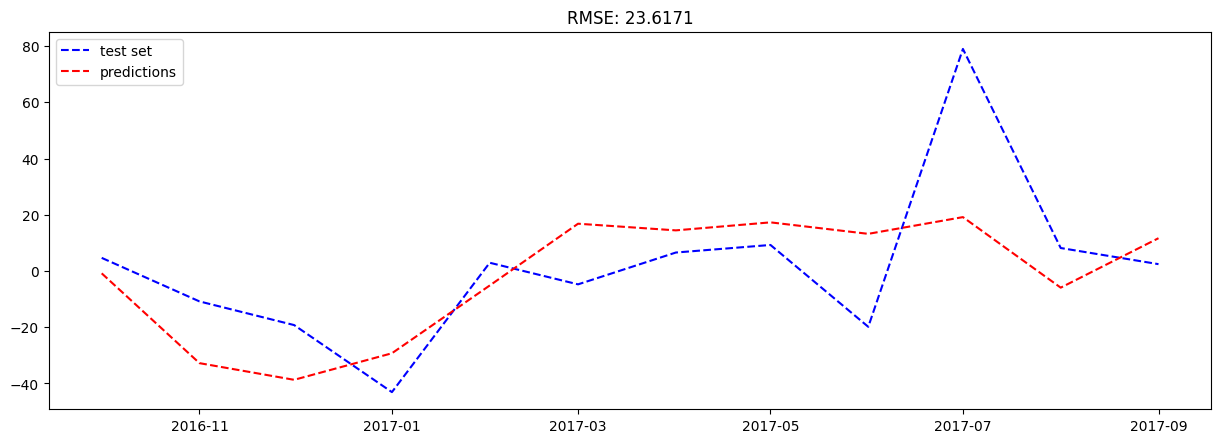

In [167]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
# plt.plot(train)
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_diff)
plt.legend(loc='upper left')
plt.show()

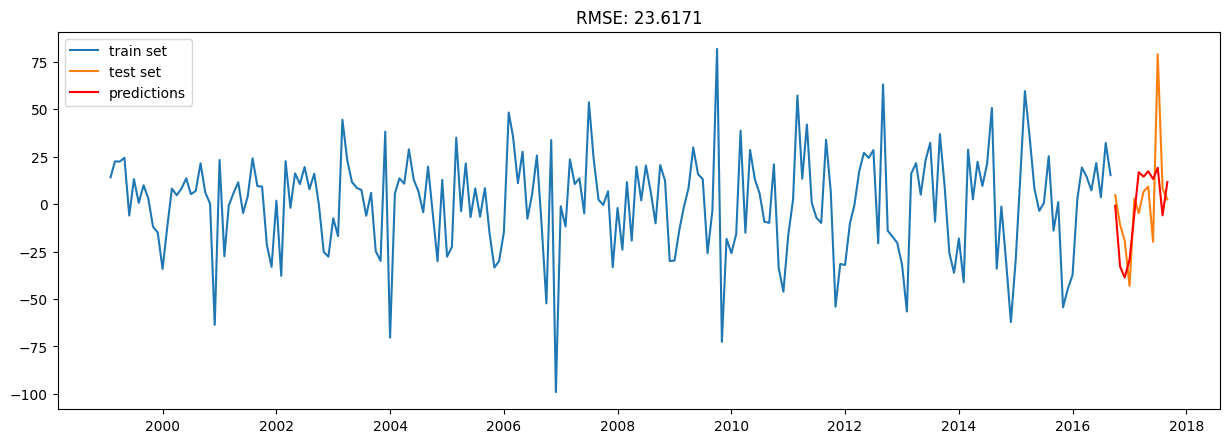

In [168]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_diff)
plt.legend(loc='upper left')
plt.show()

In [169]:
x = forecast + production.shift(1)[-12:]
np.sqrt(mean_squared_error(production[-12:], x))

23.6171477952306

### with non-stationary (raw time-series)

In [170]:
pre_train = production[:-36]
train = production[:-12]
val = production[-36:-12]
test = production[-12:]

In [171]:
params = validate(train, pdq, seasonal_pdq)

ARIMA(0, 0, 0),(0, 0, 0, 12)12, t5 - AIC:2574.126916611728
ARIMA(0, 0, 0),(0, 0, 0, 12)12, c5 - AIC:2181.974427609265
ARIMA(0, 0, 0),(0, 0, 0, 12)12, n5 - AIC:2911.6238616168166
ARIMA(0, 0, 0),(0, 0, 0, 12)12, ct5 - AIC:2134.8788849475495
ARIMA(0, 0, 0),(0, 0, 1, 12)12, t5 - AIC:2238.011637080207
ARIMA(0, 0, 0),(0, 0, 1, 12)12, c5 - AIC:1980.9716310177225
ARIMA(0, 0, 0),(0, 0, 1, 12)12, n5 - AIC:2527.6812232788984
ARIMA(0, 0, 0),(0, 0, 1, 12)12, ct5 - AIC:1958.6447048054306
ARIMA(0, 0, 0),(0, 0, 2, 12)12, t5 - AIC:2033.2398357893262
ARIMA(0, 0, 0),(0, 0, 2, 12)12, c5 - AIC:1851.413168683854
ARIMA(0, 0, 0),(0, 0, 2, 12)12, n5 - AIC:2260.3406955255195
ARIMA(0, 0, 0),(0, 0, 2, 12)12, ct5 - AIC:1838.7312337366961
ARIMA(0, 0, 0),(0, 1, 0, 12)12, t5 - AIC:1950.3168988678285
ARIMA(0, 0, 0),(0, 1, 0, 12)12, c5 - AIC:1950.1221102810125
ARIMA(0, 0, 0),(0, 1, 0, 12)12, n5 - AIC:1948.3470591893715
ARIMA(0, 0, 0),(0, 1, 0, 12)12, ct5 - AIC:1950.411755617269
ARIMA(0, 0, 0),(0, 1, 1, 12)12, t5 - AIC:

ARIMA(0, 0, 1),(2, 1, 1, 12)12, c5 - AIC:1615.1079511370313
ARIMA(0, 0, 1),(2, 1, 1, 12)12, n5 - AIC:1636.2226203812584
ARIMA(0, 0, 1),(2, 1, 1, 12)12, ct5 - AIC:1609.9177946527761
ARIMA(0, 0, 1),(2, 1, 2, 12)12, t5 - AIC:1609.0794517798035
ARIMA(0, 0, 1),(2, 1, 2, 12)12, c5 - AIC:1599.4239936366496
ARIMA(0, 0, 1),(2, 1, 2, 12)12, n5 - AIC:1621.0659195829242
ARIMA(0, 0, 1),(2, 1, 2, 12)12, ct5 - AIC:1596.5253971483123
ARIMA(0, 0, 2),(0, 0, 0, 12)12, t5 - AIC:2202.1681011052597
ARIMA(0, 0, 2),(0, 0, 0, 12)12, c5 - AIC:1975.9573681473917
ARIMA(0, 0, 2),(0, 0, 0, 12)12, n5 - AIC:2448.5602935482866
ARIMA(0, 0, 2),(0, 0, 0, 12)12, ct5 - AIC:1955.0214864164996
ARIMA(0, 0, 2),(0, 0, 1, 12)12, t5 - AIC:1986.2115155044107
ARIMA(0, 0, 2),(0, 0, 1, 12)12, c5 - AIC:1824.6439277486766
ARIMA(0, 0, 2),(0, 0, 1, 12)12, n5 - AIC:2195.922737929257
ARIMA(0, 0, 2),(0, 0, 1, 12)12, ct5 - AIC:1813.1163936397902
ARIMA(0, 0, 2),(0, 0, 2, 12)12, t5 - AIC:1807.615411760395
ARIMA(0, 0, 2),(0, 0, 2, 12)12, c5 - A

ARIMA(0, 1, 0),(2, 0, 2, 12)12, n5 - AIC:1695.879283555625
ARIMA(0, 1, 0),(2, 0, 2, 12)12, ct5 - AIC:1699.9621069075442
ARIMA(0, 1, 0),(2, 1, 0, 12)12, t5 - AIC:1638.9684015082444
ARIMA(0, 1, 0),(2, 1, 0, 12)12, c5 - AIC:1638.9779357040472
ARIMA(0, 1, 0),(2, 1, 0, 12)12, n5 - AIC:1636.9795421586475
ARIMA(0, 1, 0),(2, 1, 0, 12)12, ct5 - AIC:1640.9451215362978
ARIMA(0, 1, 0),(2, 1, 1, 12)12, t5 - AIC:1599.0233742487344
ARIMA(0, 1, 0),(2, 1, 1, 12)12, c5 - AIC:1599.019944970632
ARIMA(0, 1, 0),(2, 1, 1, 12)12, n5 - AIC:1597.0234188426748
ARIMA(0, 1, 0),(2, 1, 1, 12)12, ct5 - AIC:1600.905994271252
ARIMA(0, 1, 0),(2, 1, 2, 12)12, t5 - AIC:1591.8200102011097
ARIMA(0, 1, 0),(2, 1, 2, 12)12, c5 - AIC:1594.662401451616
ARIMA(0, 1, 0),(2, 1, 2, 12)12, n5 - AIC:1589.8200759119882
ARIMA(0, 1, 0),(2, 1, 2, 12)12, ct5 - AIC:1593.708725551485
ARIMA(0, 1, 1),(0, 0, 0, 12)12, t5 - AIC:1972.8651257771457
ARIMA(0, 1, 1),(0, 0, 0, 12)12, c5 - AIC:1972.8446387741205
ARIMA(0, 1, 1),(0, 0, 0, 12)12, n5 - AIC:

ARIMA(0, 1, 2),(2, 0, 0, 12)12, ct5 - AIC:1714.9134487161368
ARIMA(0, 1, 2),(2, 0, 1, 12)12, t5 - AIC:1714.3111790673497
ARIMA(0, 1, 2),(2, 0, 1, 12)12, c5 - AIC:1714.3100198658958
ARIMA(0, 1, 2),(2, 0, 1, 12)12, n5 - AIC:1712.311850027732
ARIMA(0, 1, 2),(2, 0, 1, 12)12, ct5 - AIC:1716.337100408999
ARIMA(0, 1, 2),(2, 0, 2, 12)12, t5 - AIC:1670.5110475781037
ARIMA(0, 1, 2),(2, 0, 2, 12)12, c5 - AIC:1670.5250946473038
ARIMA(0, 1, 2),(2, 0, 2, 12)12, n5 - AIC:1668.6089387041475
ARIMA(0, 1, 2),(2, 0, 2, 12)12, ct5 - AIC:1672.7563359638352
ARIMA(0, 1, 2),(2, 1, 0, 12)12, t5 - AIC:1627.7006313766788
ARIMA(0, 1, 2),(2, 1, 0, 12)12, c5 - AIC:1627.7249536262061
ARIMA(0, 1, 2),(2, 1, 0, 12)12, n5 - AIC:1625.7292034064076
ARIMA(0, 1, 2),(2, 1, 0, 12)12, ct5 - AIC:1629.6420003683643
ARIMA(0, 1, 2),(2, 1, 1, 12)12, t5 - AIC:1591.3062928285813
ARIMA(0, 1, 2),(2, 1, 1, 12)12, c5 - AIC:1591.303510182407
ARIMA(0, 1, 2),(2, 1, 1, 12)12, n5 - AIC:1589.305829126094
ARIMA(0, 1, 2),(2, 1, 1, 12)12, ct5 - AI

ARIMA(1, 0, 1),(1, 1, 2, 12)12, t5 - AIC:1565.487789383229
ARIMA(1, 0, 1),(1, 1, 2, 12)12, c5 - AIC:1562.9200811082296
ARIMA(1, 0, 1),(1, 1, 2, 12)12, n5 - AIC:1568.250703240708
ARIMA(1, 0, 1),(1, 1, 2, 12)12, ct5 - AIC:1562.0568204960668
ARIMA(1, 0, 1),(2, 0, 0, 12)12, t5 - AIC:1703.3764582328874
ARIMA(1, 0, 1),(2, 0, 0, 12)12, c5 - AIC:1689.4762598218526
ARIMA(1, 0, 1),(2, 0, 0, 12)12, n5 - AIC:1710.3723189490197
ARIMA(1, 0, 1),(2, 0, 0, 12)12, ct5 - AIC:1695.5119885282775
ARIMA(1, 0, 1),(2, 0, 1, 12)12, t5 - AIC:1680.2507229818693
ARIMA(1, 0, 1),(2, 0, 1, 12)12, c5 - AIC:1692.8298048852234
ARIMA(1, 0, 1),(2, 0, 1, 12)12, n5 - AIC:1679.6450529195
ARIMA(1, 0, 1),(2, 0, 1, 12)12, ct5 - AIC:1697.2601575378312
ARIMA(1, 0, 1),(2, 0, 2, 12)12, t5 - AIC:1665.8713110097447
ARIMA(1, 0, 1),(2, 0, 2, 12)12, c5 - AIC:1688.302079562175
ARIMA(1, 0, 1),(2, 0, 2, 12)12, n5 - AIC:1663.3931916853348
ARIMA(1, 0, 1),(2, 0, 2, 12)12, ct5 - AIC:1690.06376581991
ARIMA(1, 0, 1),(2, 1, 0, 12)12, t5 - AIC:160

ARIMA(1, 1, 0),(1, 1, 0, 12)12, c5 - AIC:1725.745345258993
ARIMA(1, 1, 0),(1, 1, 0, 12)12, n5 - AIC:1723.7703295754136
ARIMA(1, 1, 0),(1, 1, 0, 12)12, ct5 - AIC:1727.7410628553448
ARIMA(1, 1, 0),(1, 1, 1, 12)12, t5 - AIC:1688.4253002799383
ARIMA(1, 1, 0),(1, 1, 1, 12)12, c5 - AIC:1688.4348366431248
ARIMA(1, 1, 0),(1, 1, 1, 12)12, n5 - AIC:1686.4523782851156
ARIMA(1, 1, 0),(1, 1, 1, 12)12, ct5 - AIC:1690.4111289624834
ARIMA(1, 1, 0),(1, 1, 2, 12)12, t5 - AIC:1582.4071588473873
ARIMA(1, 1, 0),(1, 1, 2, 12)12, c5 - AIC:1582.421187333874
ARIMA(1, 1, 0),(1, 1, 2, 12)12, n5 - AIC:1580.4238201888759
ARIMA(1, 1, 0),(1, 1, 2, 12)12, ct5 - AIC:1584.2933896028608
ARIMA(1, 1, 0),(2, 0, 0, 12)12, t5 - AIC:1702.987304507917
ARIMA(1, 1, 0),(2, 0, 0, 12)12, c5 - AIC:1702.9842192197957
ARIMA(1, 1, 0),(2, 0, 0, 12)12, n5 - AIC:1700.9876859212372
ARIMA(1, 1, 0),(2, 0, 0, 12)12, ct5 - AIC:1704.9901910501844
ARIMA(1, 1, 0),(2, 0, 1, 12)12, t5 - AIC:1704.9873038227981
ARIMA(1, 1, 0),(2, 0, 1, 12)12, c5 - AI

ARIMA(1, 1, 2),(1, 0, 1, 12)12, n5 - AIC:1764.4271793718538
ARIMA(1, 1, 2),(1, 0, 1, 12)12, ct5 - AIC:1790.7788930129495
ARIMA(1, 1, 2),(1, 0, 2, 12)12, t5 - AIC:1684.95984252877
ARIMA(1, 1, 2),(1, 0, 2, 12)12, c5 - AIC:1656.4262581779503
ARIMA(1, 1, 2),(1, 0, 2, 12)12, n5 - AIC:1657.3087526762965
ARIMA(1, 1, 2),(1, 0, 2, 12)12, ct5 - AIC:1684.5969577218393
ARIMA(1, 1, 2),(1, 1, 0, 12)12, t5 - AIC:1729.557566766287
ARIMA(1, 1, 2),(1, 1, 0, 12)12, c5 - AIC:1729.5637438624244
ARIMA(1, 1, 2),(1, 1, 0, 12)12, n5 - AIC:1727.5859483563795
ARIMA(1, 1, 2),(1, 1, 0, 12)12, ct5 - AIC:1731.5912657079632
ARIMA(1, 1, 2),(1, 1, 1, 12)12, t5 - AIC:1676.082675244103
ARIMA(1, 1, 2),(1, 1, 1, 12)12, c5 - AIC:1675.9353147842694
ARIMA(1, 1, 2),(1, 1, 1, 12)12, n5 - AIC:1673.9484042574627
ARIMA(1, 1, 2),(1, 1, 1, 12)12, ct5 - AIC:1680.997175349236
ARIMA(1, 1, 2),(1, 1, 2, 12)12, t5 - AIC:1570.0704167675665
ARIMA(1, 1, 2),(1, 1, 2, 12)12, c5 - AIC:1570.065763285904
ARIMA(1, 1, 2),(1, 1, 2, 12)12, n5 - AIC:1

ARIMA(2, 0, 1),(0, 1, 2, 12)12, ct5 - AIC:1561.9076204844837
ARIMA(2, 0, 1),(1, 0, 0, 12)12, t5 - AIC:1807.635700311153
ARIMA(2, 0, 1),(1, 0, 0, 12)12, c5 - AIC:1829.4323066338793
ARIMA(2, 0, 1),(1, 0, 0, 12)12, n5 - AIC:1805.8776560349372
ARIMA(2, 0, 1),(1, 0, 0, 12)12, ct5 - AIC:1856.5849699109408
ARIMA(2, 0, 1),(1, 0, 1, 12)12, t5 - AIC:1808.345927659643
ARIMA(2, 0, 1),(1, 0, 1, 12)12, c5 - AIC:1827.8284579313818
ARIMA(2, 0, 1),(1, 0, 1, 12)12, n5 - AIC:1771.5023617869288
ARIMA(2, 0, 1),(1, 0, 1, 12)12, ct5 - AIC:1830.9326472476728
ARIMA(2, 0, 1),(1, 0, 2, 12)12, t5 - AIC:1696.292392281523
ARIMA(2, 0, 1),(1, 0, 2, 12)12, c5 - AIC:1695.7746184886573
ARIMA(2, 0, 1),(1, 0, 2, 12)12, n5 - AIC:1671.8544906028287
ARIMA(2, 0, 1),(1, 0, 2, 12)12, ct5 - AIC:1727.3774616315004
ARIMA(2, 0, 1),(1, 1, 0, 12)12, t5 - AIC:1711.2746648713878
ARIMA(2, 0, 1),(1, 1, 0, 12)12, c5 - AIC:1711.1187752728865
ARIMA(2, 0, 1),(1, 1, 0, 12)12, n5 - AIC:1709.276325441947
ARIMA(2, 0, 1),(1, 1, 0, 12)12, ct5 - AI

ARIMA(2, 1, 0),(0, 1, 1, 12)12, t5 - AIC:1688.5368818699496
ARIMA(2, 1, 0),(0, 1, 1, 12)12, c5 - AIC:1688.5483992230677
ARIMA(2, 1, 0),(0, 1, 1, 12)12, n5 - AIC:1686.5697954216498
ARIMA(2, 1, 0),(0, 1, 1, 12)12, ct5 - AIC:1690.5207809818771
ARIMA(2, 1, 0),(0, 1, 2, 12)12, t5 - AIC:1582.6348499207775
ARIMA(2, 1, 0),(0, 1, 2, 12)12, c5 - AIC:1582.6473274668897
ARIMA(2, 1, 0),(0, 1, 2, 12)12, n5 - AIC:1580.6480182208065
ARIMA(2, 1, 0),(0, 1, 2, 12)12, ct5 - AIC:1584.4894127575105
ARIMA(2, 1, 0),(1, 0, 0, 12)12, t5 - AIC:1802.0571249862223
ARIMA(2, 1, 0),(1, 0, 0, 12)12, c5 - AIC:1802.0489398493091
ARIMA(2, 1, 0),(1, 0, 0, 12)12, n5 - AIC:1800.060061098388
ARIMA(2, 1, 0),(1, 0, 0, 12)12, ct5 - AIC:1804.0427526447297
ARIMA(2, 1, 0),(1, 0, 1, 12)12, t5 - AIC:1787.8572500282296
ARIMA(2, 1, 0),(1, 0, 1, 12)12, c5 - AIC:1787.8754793847559
ARIMA(2, 1, 0),(1, 0, 1, 12)12, n5 - AIC:1785.9925767669542
ARIMA(2, 1, 0),(1, 0, 1, 12)12, ct5 - AIC:1789.8839039575382
ARIMA(2, 1, 0),(1, 0, 2, 12)12, t5 - 

ARIMA(2, 1, 2),(0, 0, 2, 12)12, c5 - AIC:1660.8490765353824
ARIMA(2, 1, 2),(0, 0, 2, 12)12, n5 - AIC:1659.7755497535406
ARIMA(2, 1, 2),(0, 0, 2, 12)12, ct5 - AIC:1691.1051997644815
ARIMA(2, 1, 2),(0, 1, 0, 12)12, t5 - AIC:1832.123117423524
ARIMA(2, 1, 2),(0, 1, 0, 12)12, c5 - AIC:1832.1423719624945
ARIMA(2, 1, 2),(0, 1, 0, 12)12, n5 - AIC:1830.1430809892702
ARIMA(2, 1, 2),(0, 1, 0, 12)12, ct5 - AIC:1834.0900893960265
ARIMA(2, 1, 2),(0, 1, 1, 12)12, t5 - AIC:1673.6268044467456
ARIMA(2, 1, 2),(0, 1, 1, 12)12, c5 - AIC:1673.6369712607805
ARIMA(2, 1, 2),(0, 1, 1, 12)12, n5 - AIC:1671.6664857600508
ARIMA(2, 1, 2),(0, 1, 1, 12)12, ct5 - AIC:1676.1842529738228
ARIMA(2, 1, 2),(0, 1, 2, 12)12, t5 - AIC:1568.1959933413018
ARIMA(2, 1, 2),(0, 1, 2, 12)12, c5 - AIC:1568.1249027733427
ARIMA(2, 1, 2),(0, 1, 2, 12)12, n5 - AIC:1566.1276535805266
ARIMA(2, 1, 2),(0, 1, 2, 12)12, ct5 - AIC:1570.1788489224969
ARIMA(2, 1, 2),(1, 0, 0, 12)12, t5 - AIC:1791.4049408508056
ARIMA(2, 1, 2),(1, 0, 0, 12)12, c5 - 

Text(0.5, 1.0, 'RMSE: 51.0766')

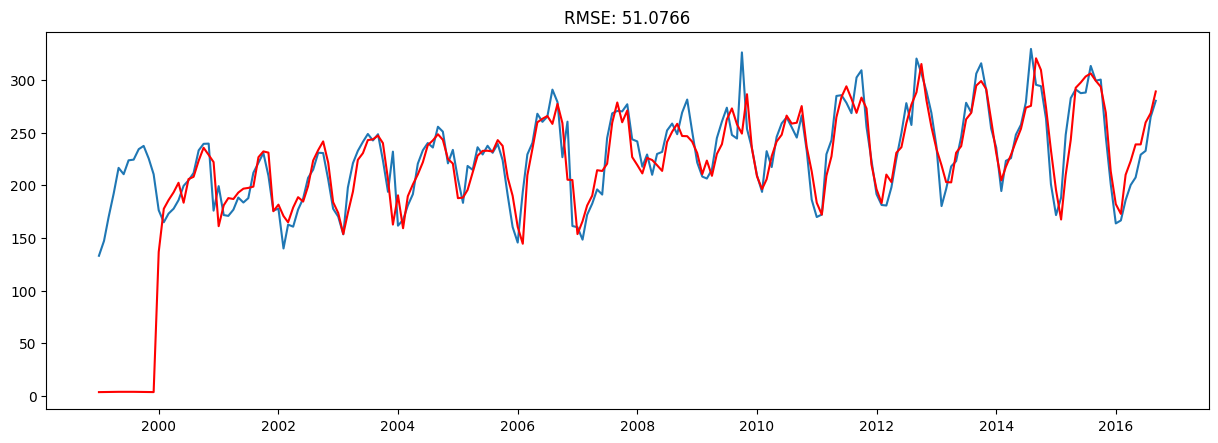

In [172]:
# order, sorder, t = [(2,1,2), (0,1,2,12), 'c']
order, sorder, t = params
model = SARIMAX(train, 
            order=order, 
            seasonal_order=sorder, 
            trend=t)
# model_fit.summary()
model_fit = model.fit(disp=0)
rmse_sarima = np.sqrt(mean_squared_error(model_fit.fittedvalues, train))
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% rmse_sarima)

In [173]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, 
            order=order, 
            seasonal_order=sorder, 
            trend=params[2])
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    print('predicted=%f, expected=%f' % (yhat, test[t]))
rmse_sarima_raw = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse_sarima_raw)

forecast = pd.Series(predictions, index=test.index)

predicted=302.088146, expected=284.922000
predicted=272.373340, expected=274.107000
predicted=249.470450, expected=254.881000
predicted=232.870123, expected=211.810000
predicted=212.775491, expected=214.747000
predicted=233.319758, expected=210.002000
predicted=225.851228, expected=216.574000
predicted=235.556297, expected=225.834000
predicted=241.127215, expected=205.989000
predicted=234.071860, expected=284.963000
predicted=279.851706, expected=293.140000
predicted=303.284218, expected=295.578000
Test RMSE: 21.524


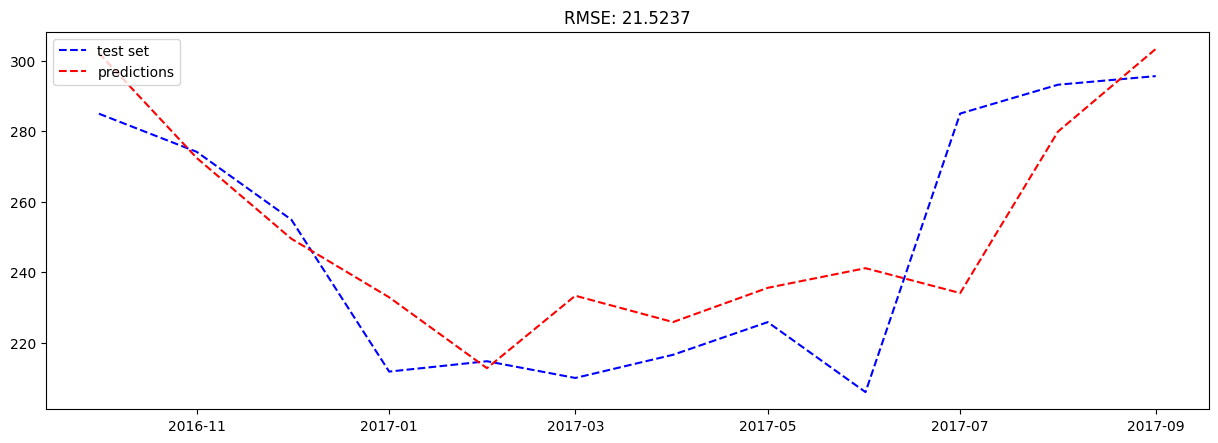

In [174]:
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
# rmse_sarima_raw = np.sqrt(mean_squared_error(test, predictions))
plt.plot(test, '--b', label="test set")
plt.plot(forecast, '--r', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_raw)
plt.legend(loc='upper left')
plt.show()

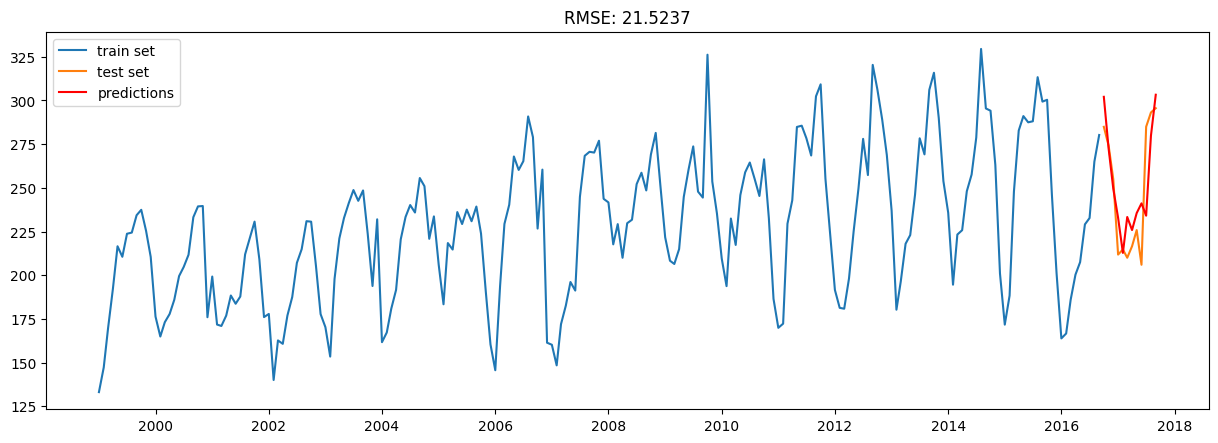

In [175]:
plt.plot(train, label="train set")
plt.plot(test, label="test set")
plt.plot(forecast, color='red', label="predictions")
plt.title('RMSE: %.4f'% rmse_sarima_raw)
plt.legend(loc='upper left')
plt.show()

* **Decomposed data gives the best RMSE.**

# Generation of features and validation of ML models

In [176]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [177]:
pre_train = values[:-36, :]
val = values[-36:-12, :]

# split into input and outputs
pre_train_X, pre_train_y = pre_train[:, :-1], pre_train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

In [178]:
VALIDATION_SHIFT = 12
train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

## LinearRegression

### validation

In [179]:
# from sklearn.model_selection import RepeatedStratifiedKFold 
# Doesen't work with continuous val
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [180]:
def validation(pre_train_X, pre_train_y, val_X, val_y):
    copy_X = [True, False]
    fit_intercept = [True, False]
    normalize = [True, False]

    best_score, best_cfg = float("inf"), None
    for c in copy_X:
        for f in fit_intercept:
            for n in normalize:
                model = LinearRegression(copy_X=c, fit_intercept=f, normalize=n)
                model.fit(pre_train_X, pre_train_y)

                y_hat = model.predict(val_X)
                x = y_hat.shape[0]
                y_hat.shape = [x,1]

                # invert scaling for forecast
                inv_yhat = np.concatenate((val_X, y_hat), axis=1)
                inv_yhat = scaler.inverse_transform(inv_yhat)
                inv_yhat = inv_yhat[:,-1]
                # invert scaling for actual
                val_y = val_y.reshape((len(val_y), 1))
                inv_y = np.concatenate((val_X, val_y), axis=1)
                inv_y = scaler.inverse_transform(inv_y)
                inv_y = inv_y[:,-1]

                # calculate RMSE
                rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

                if rmse < best_score:
                    best_score, best_cfg = rmse, (c, f, n)
                print('Linear Regression%s RMSE=%.4f' % ((c, f, n),rmse))
               
    
    print('Best Linear Regression%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg


warnings.filterwarnings("ignore")
params = validation(pre_train_X, pre_train_y, val_X, val_y)

Linear Regression(True, True, True) RMSE=82.4429
Linear Regression(True, True, False) RMSE=82.4429
Linear Regression(True, False, True) RMSE=82.3835
Linear Regression(True, False, False) RMSE=82.3835
Linear Regression(False, True, True) RMSE=82.4429
Linear Regression(False, True, False) RMSE=421.7997
Linear Regression(False, False, True) RMSE=331.9916
Linear Regression(False, False, False) RMSE=331.9916
Best Linear Regression(True, False, True) RMSE=82.3835


In [181]:
# params = validation(train_X, train_y, test_X, test_y)

### test set prediction

In [182]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
VALIDATION_SHIFT = 12
train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [183]:
lr_model = LinearRegression(copy_X=params[0], fit_intercept=params[1], normalize=params[2])
lr_model.fit(train_X, train_y)

LinearRegression(fit_intercept=False, normalize=True)

In [184]:
# lr_model = LinearRegression()
# lr_model.fit(train_X, train_y)

In [185]:
yhat_train = lr_model.predict(train_X)
x = yhat_train.shape[0]
yhat_train.shape = [x, 1]

y_hat = lr_model.predict(test_X)
y_hat.shape = [12,1]

In [186]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, y_hat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse_lg = np.sqrt(mean_squared_error(inv_y, inv_yhat))

In [187]:
print('Test RMSE: %.3f' % rmse_lg)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

Test RMSE: 35.856
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [287.05436176 262.51243795 238.66673278 173.9382297  173.83229414
 177.98099453 182.19656473 188.92808816 202.0786021  222.18806868
 242.25962677 253.11059777]


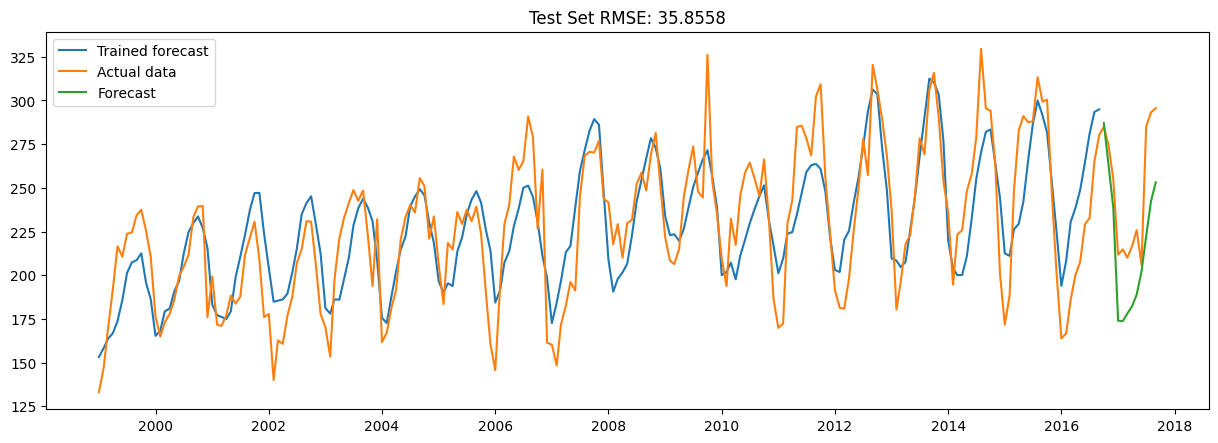

In [188]:
plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.title('Test Set RMSE: %.4f'% rmse_lg)
plt.legend()

## Rigle

In [189]:
from sklearn.linear_model import Ridge

In [190]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [191]:
VALIDATION_SHIFT = 12

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

pre_train = values[:-36, :]
val = values[-36:-12, :]
# split into input and outputs
pre_train_X, pre_train_y = pre_train[:, :-1], pre_train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

### validation

In [192]:
def validation(pre_train_X, pre_train_y, val_X, val_y):
    alpha = [0.1, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
    copy_X = [True, False]
    fit_intercept = [True, False]
    normalize = [True, False]
    solver = ['sparse_cg', 'cholesky', 'svd', 'sag', 'saga', 'lsqr', 'auto']

    best_score, best_cfg = float("inf"), None
    for a in alpha:
        for c in copy_X:
            for f in fit_intercept:
                for n in normalize:
                    for s in solver:
                        model = Ridge(alpha=a, copy_X=c, fit_intercept=f, normalize=n, solver=s)
                        model.fit(pre_train_X, pre_train_y)

                        y_hat = model.predict(val_X)
                        x = y_hat.shape[0]
                        y_hat.shape = [x,1]

                        # invert scaling for forecast
                        inv_yhat = np.concatenate((val_X, y_hat), axis=1)
                        inv_yhat = scaler.inverse_transform(inv_yhat)
                        inv_yhat = inv_yhat[:,-1]
                        # invert scaling for actual
                        val_y = val_y.reshape((len(val_y), 1))
                        inv_y = np.concatenate((val_X, val_y), axis=1)
                        inv_y = scaler.inverse_transform(inv_y)
                        inv_y = inv_y[:,-1]

                        # calculate RMSE
                        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
                        params = (a, c, f, n, s)
                        if rmse < best_score:
                            best_score, best_cfg = rmse, params
                        print('Rigle Regression%s RMSE=%.4f' % (params,rmse))
               
    print('Best Rigle Regression%s RMSE=%.4f' % (best_cfg, best_score))
    return best_cfg


warnings.filterwarnings("ignore")
params = validation(pre_train_X, pre_train_y, val_X, val_y)

Rigle Regression(0.1, True, True, True, 'sparse_cg') RMSE=58.3243
Rigle Regression(0.1, True, True, True, 'cholesky') RMSE=58.3756
Rigle Regression(0.1, True, True, True, 'svd') RMSE=58.3756
Rigle Regression(0.1, True, True, True, 'sag') RMSE=58.3837
Rigle Regression(0.1, True, True, True, 'saga') RMSE=58.3438
Rigle Regression(0.1, True, True, True, 'lsqr') RMSE=58.3243
Rigle Regression(0.1, True, True, True, 'auto') RMSE=58.3756
Rigle Regression(0.1, True, True, False, 'sparse_cg') RMSE=73.2104
Rigle Regression(0.1, True, True, False, 'cholesky') RMSE=73.2375
Rigle Regression(0.1, True, True, False, 'svd') RMSE=73.2375
Rigle Regression(0.1, True, True, False, 'sag') RMSE=73.1296
Rigle Regression(0.1, True, True, False, 'saga') RMSE=72.9945
Rigle Regression(0.1, True, True, False, 'lsqr') RMSE=73.2106
Rigle Regression(0.1, True, True, False, 'auto') RMSE=73.2375
Rigle Regression(0.1, True, False, True, 'sparse_cg') RMSE=65.5072
Rigle Regression(0.1, True, False, True, 'cholesky') RMSE=

Rigle Regression(3.0, False, True, False, 'auto') RMSE=191.4157
Rigle Regression(3.0, False, False, True, 'sparse_cg') RMSE=102.2466
Rigle Regression(3.0, False, False, True, 'cholesky') RMSE=102.2114
Rigle Regression(3.0, False, False, True, 'svd') RMSE=102.2114
Rigle Regression(3.0, False, False, True, 'sag') RMSE=102.2020
Rigle Regression(3.0, False, False, True, 'saga') RMSE=102.2474
Rigle Regression(3.0, False, False, True, 'lsqr') RMSE=102.1366
Rigle Regression(3.0, False, False, True, 'auto') RMSE=102.2114
Rigle Regression(3.0, False, False, False, 'sparse_cg') RMSE=102.2466
Rigle Regression(3.0, False, False, False, 'cholesky') RMSE=102.2114
Rigle Regression(3.0, False, False, False, 'svd') RMSE=102.2114
Rigle Regression(3.0, False, False, False, 'sag') RMSE=102.2132
Rigle Regression(3.0, False, False, False, 'saga') RMSE=102.2811
Rigle Regression(3.0, False, False, False, 'lsqr') RMSE=102.1366
Rigle Regression(3.0, False, False, False, 'auto') RMSE=102.2114
Rigle Regression(5.

Rigle Regression(15.0, False, False, True, 'svd') RMSE=47.3286
Rigle Regression(15.0, False, False, True, 'sag') RMSE=47.3328
Rigle Regression(15.0, False, False, True, 'saga') RMSE=47.3297
Rigle Regression(15.0, False, False, True, 'lsqr') RMSE=47.4835
Rigle Regression(15.0, False, False, True, 'auto') RMSE=47.3286
Rigle Regression(15.0, False, False, False, 'sparse_cg') RMSE=47.3281
Rigle Regression(15.0, False, False, False, 'cholesky') RMSE=47.3286
Rigle Regression(15.0, False, False, False, 'svd') RMSE=47.3286
Rigle Regression(15.0, False, False, False, 'sag') RMSE=47.2953
Rigle Regression(15.0, False, False, False, 'saga') RMSE=47.3199
Rigle Regression(15.0, False, False, False, 'lsqr') RMSE=47.4835
Rigle Regression(15.0, False, False, False, 'auto') RMSE=47.3286
Best Rigle Regression(10.0, True, False, True, 'sag') RMSE=35.4172


In [193]:
# params = validation(train_X, train_y, test_X, test_y)

### test set prediction

In [194]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [195]:
ridge_regression = Ridge(alpha=params[0], copy_X=params[1], 
                         fit_intercept=params[2], normalize=params[3], solver=params[4])

In [196]:
# ridge_regression = Ridge(alpha=0.3, normalize=True)

In [197]:
ridge_regression.fit(train_X, train_y)

Ridge(alpha=10.0, fit_intercept=False, normalize=True, solver='sag')

In [198]:
yhat_train = ridge_regression.predict(train_X)
x = yhat_train.shape[0]
yhat_train.shape = [x, 1]

y_hat = ridge_regression.predict(test_X)
y_hat.shape = [12,1]

In [199]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, y_hat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse_rigle = np.sqrt(mean_squared_error(inv_y, inv_yhat))

In [200]:
print('Test RMSE: %.3f' % rmse_rigle)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

Test RMSE: 25.631
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [272.45528879 255.10032892 241.37362179 185.48495518 190.36073183
 197.1950353  203.84705139 212.22984225 223.79659863 237.99566191
 252.91492207 260.29782062]


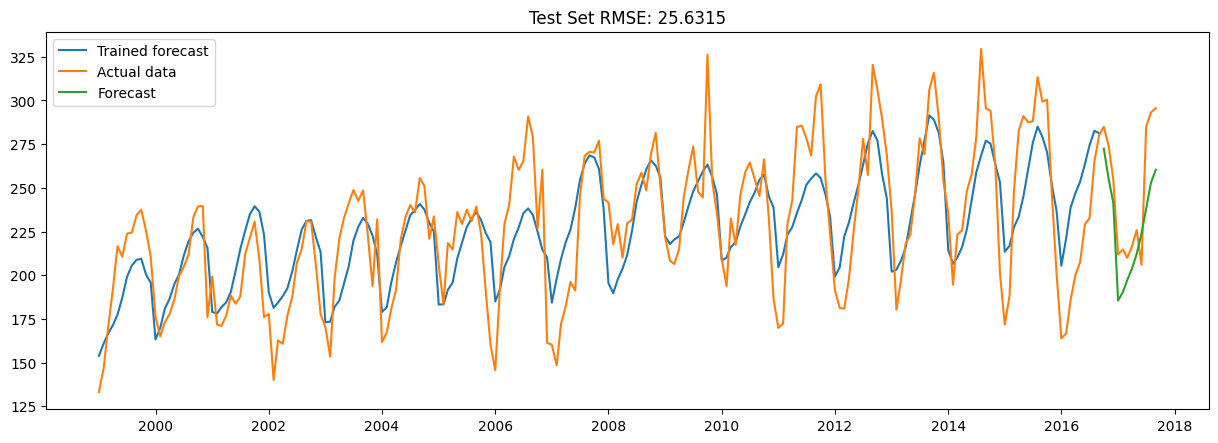

In [201]:
plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.title('Test Set RMSE: %.4f'% rmse_rigle)
plt.legend()

* **RMSE with Rigle regression is smaller.**

# DL Models

In [202]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector, Conv2D, ReLU
from keras.layers import LSTM
from keras.optimizers import Adam, Adagrad

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe, rand
from keras.layers import Dense, SimpleRNN, LSTM

### CNN

In [208]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

In [209]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(ReLU())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                     input_shape=(train_X.shape[1], train_X.shape[2])))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizer)

history = model_cnn.fit(train_X, train_y, 
                        epochs=EPOCHS, batch_size=64, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)

Epoch 1/200
4/4 - 0s - loss: 0.2072 - val_loss: 0.1418
Epoch 2/200
4/4 - 0s - loss: 0.0860 - val_loss: 0.0672
Epoch 3/200
4/4 - 0s - loss: 0.0499 - val_loss: 0.0430
Epoch 4/200
4/4 - 0s - loss: 0.0410 - val_loss: 0.0360
Epoch 5/200
4/4 - 0s - loss: 0.0392 - val_loss: 0.0337
Epoch 6/200
4/4 - 0s - loss: 0.0386 - val_loss: 0.0327
Epoch 7/200
4/4 - 0s - loss: 0.0382 - val_loss: 0.0322
Epoch 8/200
4/4 - 0s - loss: 0.0379 - val_loss: 0.0318
Epoch 9/200
4/4 - 0s - loss: 0.0376 - val_loss: 0.0314
Epoch 10/200
4/4 - 0s - loss: 0.0373 - val_loss: 0.0311
Epoch 11/200
4/4 - 0s - loss: 0.0370 - val_loss: 0.0308
Epoch 12/200
4/4 - 0s - loss: 0.0367 - val_loss: 0.0306
Epoch 13/200
4/4 - 0s - loss: 0.0364 - val_loss: 0.0304
Epoch 14/200
4/4 - 0s - loss: 0.0361 - val_loss: 0.0303
Epoch 15/200
4/4 - 0s - loss: 0.0358 - val_loss: 0.0302
Epoch 16/200
4/4 - 0s - loss: 0.0355 - val_loss: 0.0300
Epoch 17/200
4/4 - 0s - loss: 0.0352 - val_loss: 0.0299
Epoch 18/200
4/4 - 0s - loss: 0.0349 - val_loss: 0.0297
E

Epoch 147/200
4/4 - 0s - loss: 0.0218 - val_loss: 0.0188
Epoch 148/200
4/4 - 0s - loss: 0.0217 - val_loss: 0.0188
Epoch 149/200
4/4 - 0s - loss: 0.0217 - val_loss: 0.0187
Epoch 150/200
4/4 - 0s - loss: 0.0216 - val_loss: 0.0187
Epoch 151/200
4/4 - 0s - loss: 0.0216 - val_loss: 0.0186
Epoch 152/200
4/4 - 0s - loss: 0.0216 - val_loss: 0.0186
Epoch 153/200
4/4 - 0s - loss: 0.0215 - val_loss: 0.0185
Epoch 154/200
4/4 - 0s - loss: 0.0215 - val_loss: 0.0185
Epoch 155/200
4/4 - 0s - loss: 0.0214 - val_loss: 0.0184
Epoch 156/200
4/4 - 0s - loss: 0.0214 - val_loss: 0.0184
Epoch 157/200
4/4 - 0s - loss: 0.0214 - val_loss: 0.0184
Epoch 158/200
4/4 - 0s - loss: 0.0213 - val_loss: 0.0183
Epoch 159/200
4/4 - 0s - loss: 0.0213 - val_loss: 0.0183
Epoch 160/200
4/4 - 0s - loss: 0.0212 - val_loss: 0.0183
Epoch 161/200
4/4 - 0s - loss: 0.0212 - val_loss: 0.0182
Epoch 162/200
4/4 - 0s - loss: 0.0211 - val_loss: 0.0182
Epoch 163/200
4/4 - 0s - loss: 0.0211 - val_loss: 0.0182
Epoch 164/200
4/4 - 0s - loss: 

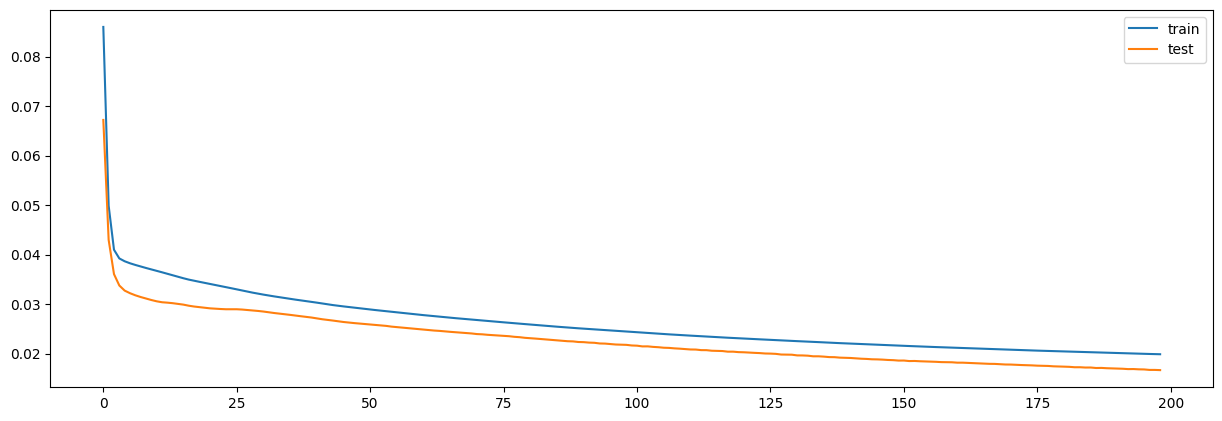

In [210]:
# plot history
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

In [211]:
# make a prediction
yhat = model_cnn.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model_cnn.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))

Test RMSE: 25.340
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [273.28289366 273.0097242  245.18785097 211.0462564  212.29816801
 213.94916478 218.73688743 223.0942845  228.96955825 238.52474234
 242.38719094 248.89098387]


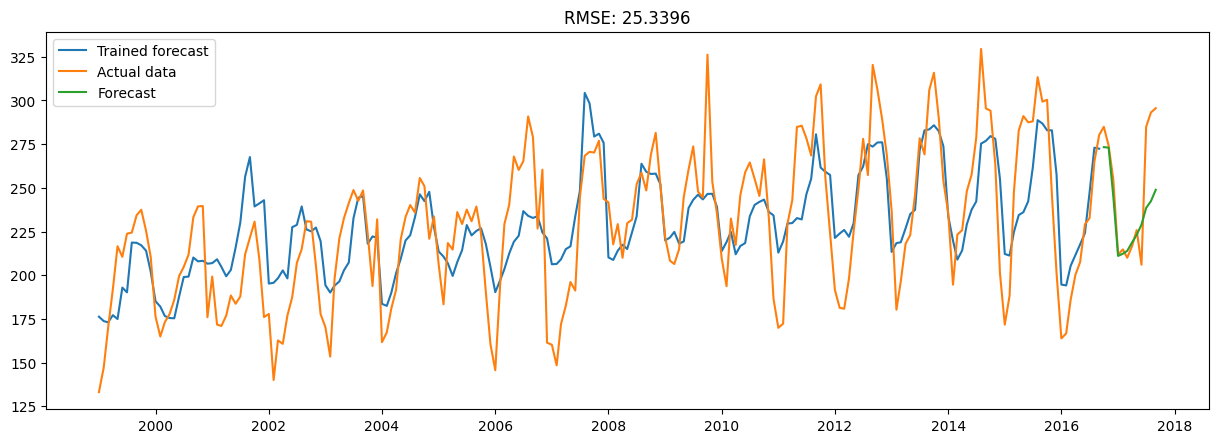

In [212]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse_cnn = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse_cnn)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.title('RMSE: %.4f'% rmse_cnn)
plt.legend()

### RNN

In [213]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

In [214]:
VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

In [215]:
# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# model, history = fit_SimpleRNN(train_X, train_y, cell_units=20, epochs=200)

model = Sequential() 
model.add(SimpleRNN(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64,
                    validation_data=(test_X, test_y),  
                    verbose=2, shuffle=False)

Epoch 1/200
4/4 - 0s - loss: 0.6469 - val_loss: 0.7799
Epoch 2/200
4/4 - 0s - loss: 0.4611 - val_loss: 0.5529
Epoch 3/200
4/4 - 0s - loss: 0.2807 - val_loss: 0.3751
Epoch 4/200
4/4 - 0s - loss: 0.2074 - val_loss: 0.2434
Epoch 5/200
4/4 - 0s - loss: 0.1420 - val_loss: 0.1532
Epoch 6/200
4/4 - 0s - loss: 0.1125 - val_loss: 0.0967
Epoch 7/200
4/4 - 0s - loss: 0.1029 - val_loss: 0.0641
Epoch 8/200
4/4 - 0s - loss: 0.1076 - val_loss: 0.0477
Epoch 9/200
4/4 - 0s - loss: 0.0899 - val_loss: 0.0408
Epoch 10/200
4/4 - 0s - loss: 0.1090 - val_loss: 0.0391
Epoch 11/200
4/4 - 0s - loss: 0.1206 - val_loss: 0.0406
Epoch 12/200
4/4 - 0s - loss: 0.1156 - val_loss: 0.0444
Epoch 13/200
4/4 - 0s - loss: 0.0907 - val_loss: 0.0491
Epoch 14/200
4/4 - 0s - loss: 0.0884 - val_loss: 0.0535
Epoch 15/200
4/4 - 0s - loss: 0.1016 - val_loss: 0.0571
Epoch 16/200
4/4 - 0s - loss: 0.0926 - val_loss: 0.0587
Epoch 17/200
4/4 - 0s - loss: 0.0884 - val_loss: 0.0594
Epoch 18/200
4/4 - 0s - loss: 0.0850 - val_loss: 0.0595
E

Epoch 147/200
4/4 - 0s - loss: 0.0319 - val_loss: 0.0368
Epoch 148/200
4/4 - 0s - loss: 0.0256 - val_loss: 0.0372
Epoch 149/200
4/4 - 0s - loss: 0.0276 - val_loss: 0.0362
Epoch 150/200
4/4 - 0s - loss: 0.0300 - val_loss: 0.0353
Epoch 151/200
4/4 - 0s - loss: 0.0239 - val_loss: 0.0335
Epoch 152/200
4/4 - 0s - loss: 0.0346 - val_loss: 0.0329
Epoch 153/200
4/4 - 0s - loss: 0.0315 - val_loss: 0.0327
Epoch 154/200
4/4 - 0s - loss: 0.0266 - val_loss: 0.0329
Epoch 155/200
4/4 - 0s - loss: 0.0278 - val_loss: 0.0344
Epoch 156/200
4/4 - 0s - loss: 0.0295 - val_loss: 0.0366
Epoch 157/200
4/4 - 0s - loss: 0.0303 - val_loss: 0.0365
Epoch 158/200
4/4 - 0s - loss: 0.0277 - val_loss: 0.0352
Epoch 159/200
4/4 - 0s - loss: 0.0255 - val_loss: 0.0334
Epoch 160/200
4/4 - 0s - loss: 0.0320 - val_loss: 0.0327
Epoch 161/200
4/4 - 0s - loss: 0.0264 - val_loss: 0.0339
Epoch 162/200
4/4 - 0s - loss: 0.0260 - val_loss: 0.0342
Epoch 163/200
4/4 - 0s - loss: 0.0253 - val_loss: 0.0350
Epoch 164/200
4/4 - 0s - loss: 

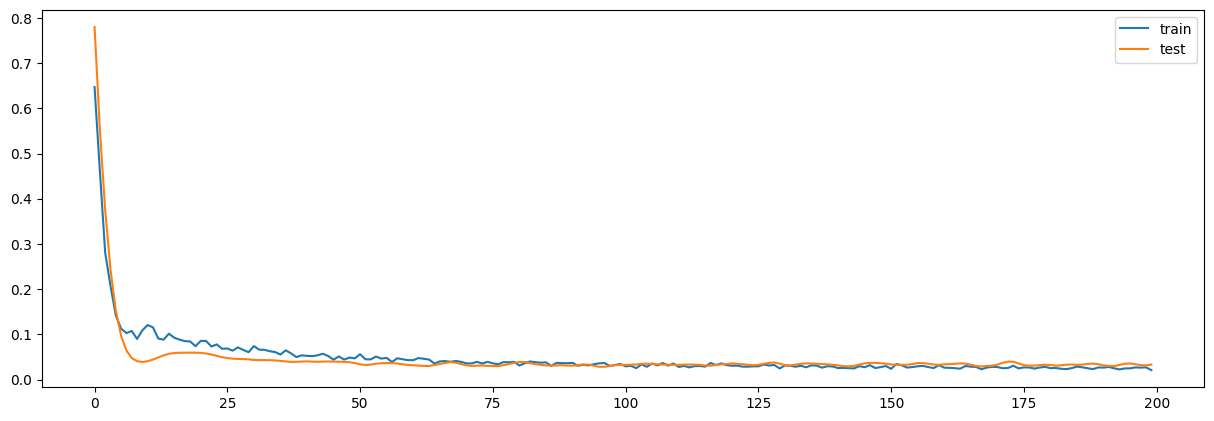

In [216]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [217]:
# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

Test RMSE: 35.820
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [271.92023008 249.4689612  230.65919296 168.56256413 171.91051118
 181.19562762 185.01824436 193.94969659 205.40663199 223.28891393
 244.94557079 258.69945077]


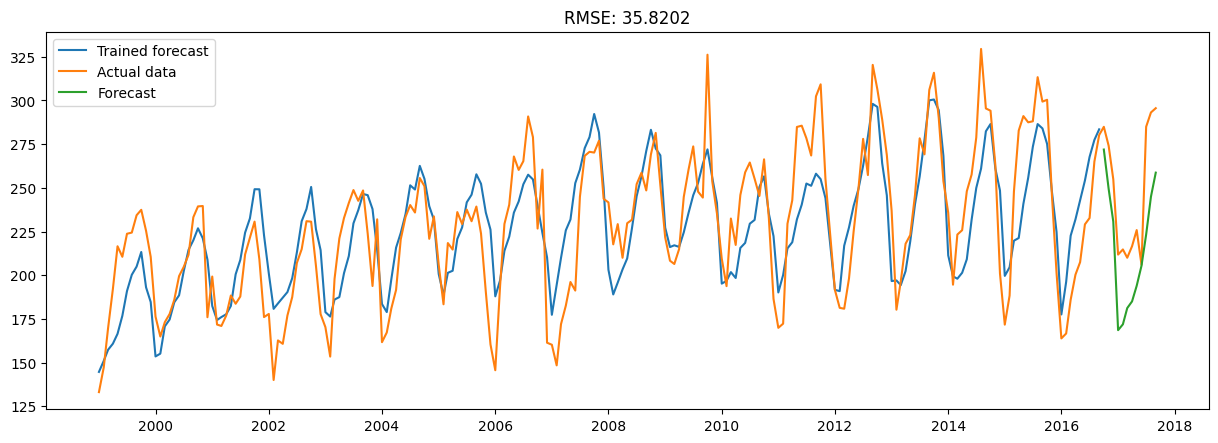

In [218]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse_rnn = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse_rnn)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.title('RMSE: %.4f'% rmse_rnn)
plt.legend()

### LSTM

In [219]:
values = np.concatenate((DATA['Johor'][0].values, DATA['Johor'][1].values.reshape((-1, 1))), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

VALIDATION_SHIFT = 12
EPOCHS = 200

train = values[:-VALIDATION_SHIFT, :]
test = values[-VALIDATION_SHIFT:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

optimizer = Adagrad(0.01)

In [220]:
# reshape input to be 3D [samples, features, timesteps]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

# model.compile(loss='mae', optimizer=optimizer)
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=EPOCHS, batch_size=64, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=False)

Epoch 1/200
4/4 - 1s - loss: 0.2318 - val_loss: 0.2642
Epoch 2/200
4/4 - 0s - loss: 0.1811 - val_loss: 0.2068
Epoch 3/200
4/4 - 0s - loss: 0.1425 - val_loss: 0.1577
Epoch 4/200
4/4 - 0s - loss: 0.1116 - val_loss: 0.1176
Epoch 5/200
4/4 - 0s - loss: 0.0782 - val_loss: 0.0863
Epoch 6/200
4/4 - 0s - loss: 0.0618 - val_loss: 0.0630
Epoch 7/200
4/4 - 0s - loss: 0.0472 - val_loss: 0.0470
Epoch 8/200
4/4 - 0s - loss: 0.0428 - val_loss: 0.0367
Epoch 9/200
4/4 - 0s - loss: 0.0416 - val_loss: 0.0307
Epoch 10/200
4/4 - 0s - loss: 0.0404 - val_loss: 0.0278
Epoch 11/200
4/4 - 0s - loss: 0.0385 - val_loss: 0.0265
Epoch 12/200
4/4 - 0s - loss: 0.0419 - val_loss: 0.0263
Epoch 13/200
4/4 - 0s - loss: 0.0421 - val_loss: 0.0268
Epoch 14/200
4/4 - 0s - loss: 0.0392 - val_loss: 0.0278
Epoch 15/200
4/4 - 0s - loss: 0.0367 - val_loss: 0.0291
Epoch 16/200
4/4 - 0s - loss: 0.0390 - val_loss: 0.0304
Epoch 17/200
4/4 - 0s - loss: 0.0357 - val_loss: 0.0312
Epoch 18/200
4/4 - 0s - loss: 0.0356 - val_loss: 0.0312
E

Epoch 147/200
4/4 - 0s - loss: 0.0180 - val_loss: 0.0274
Epoch 148/200
4/4 - 0s - loss: 0.0175 - val_loss: 0.0261
Epoch 149/200
4/4 - 0s - loss: 0.0190 - val_loss: 0.0246
Epoch 150/200
4/4 - 0s - loss: 0.0183 - val_loss: 0.0240
Epoch 151/200
4/4 - 0s - loss: 0.0181 - val_loss: 0.0255
Epoch 152/200
4/4 - 0s - loss: 0.0172 - val_loss: 0.0270
Epoch 153/200
4/4 - 0s - loss: 0.0177 - val_loss: 0.0275
Epoch 154/200
4/4 - 0s - loss: 0.0174 - val_loss: 0.0277
Epoch 155/200
4/4 - 0s - loss: 0.0160 - val_loss: 0.0271
Epoch 156/200
4/4 - 0s - loss: 0.0180 - val_loss: 0.0269
Epoch 157/200
4/4 - 0s - loss: 0.0183 - val_loss: 0.0269
Epoch 158/200
4/4 - 0s - loss: 0.0178 - val_loss: 0.0265
Epoch 159/200
4/4 - 0s - loss: 0.0188 - val_loss: 0.0264
Epoch 160/200
4/4 - 0s - loss: 0.0180 - val_loss: 0.0267
Epoch 161/200
4/4 - 0s - loss: 0.0172 - val_loss: 0.0277
Epoch 162/200
4/4 - 0s - loss: 0.0176 - val_loss: 0.0288
Epoch 163/200
4/4 - 0s - loss: 0.0188 - val_loss: 0.0283
Epoch 164/200
4/4 - 0s - loss: 

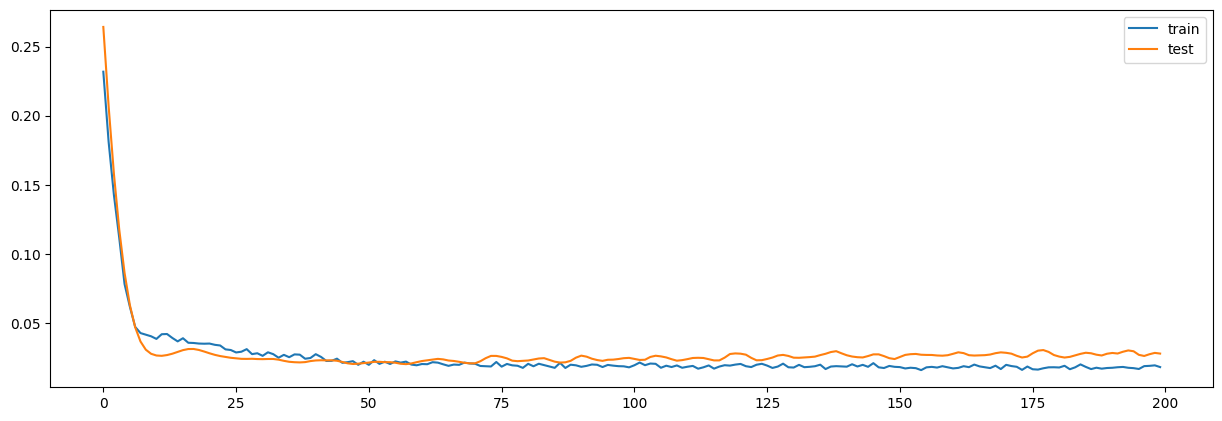

In [221]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [222]:
# make a prediction
yhat = model.predict(test_X)
yhat[yhat<0] = 0
yhat_train = model.predict(train_X)
yhat_train[yhat_train<0] = 0

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

Test RMSE: 32.816
Actual data:  [284.922 274.107 254.881 211.81  214.747 210.002 216.574 225.834 205.989
 284.963 293.14  295.578]
Forecast:  [274.18616247 251.35587652 225.64431874 181.0798396  181.24795154
 183.65357924 188.23713295 195.59900199 206.92727104 227.21747193
 246.85073408 257.11856063]


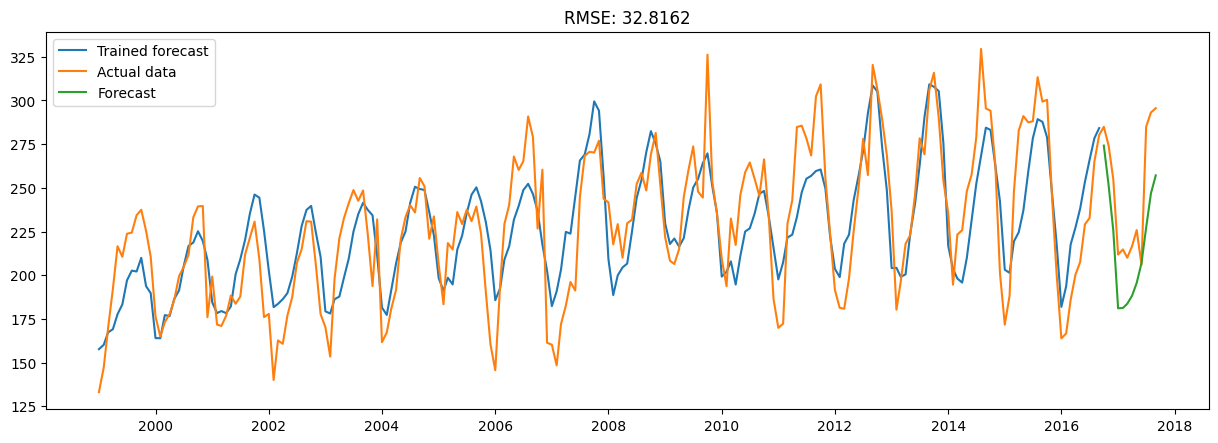

In [223]:
# invert scaling for training
inv_yhat_train = np.concatenate((train_X, yhat_train), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,-1]


# invert scaling for forecast
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse_lstm)
print("Actual data: ", inv_y)
print("Forecast: ",inv_yhat)

plt.plot(pd.Series(inv_yhat_train, index=DATA['Johor'][1].index[:-VALIDATION_SHIFT]), label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(pd.Series(inv_yhat, index=DATA['Johor'][1].index[-VALIDATION_SHIFT:]), label="Forecast")
plt.title('RMSE: %.4f'% rmse_lstm)
plt.legend()

# Facebook Prophet validation

**В мене не вийшло поставити Facebook Prophet на Windows, тому продублюю тут весь код з колабу і скіншоти з резульататами. А також ділюся посиланням на колаб.**
### Colaboratory  https://colab.research.google.com/drive/14-XSgWmZUsPoUXrIRtGk2PkfD5U7a7Zj?usp=sharing

In [ ]:
from fbprophet import Prophet

In [ ]:
ts = DATA['Johor'][1]
ts.plot()

![title](fb_screens/2.png)

**multiplicative model**

In [ ]:
from fbprophet import Prophet

m = Prophet(seasonality_mode='multiplicative',
            growth='logistic',
            yearly_seasonality=True,
            daily_seasonality=True)

# m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=4, fourier_order=5)

val_interval = 12

train_index = ts.index[:-val_interval]
test_index = ts.index[-val_interval:]

train_val = ts.values[:-val_interval]
test_val = ts.values[-val_interval:]

ptrain = pd.DataFrame()
ptrain["ds"] = train_index
ptrain["y"] = train_val

ptrain['floor'] = ptrain['y'].min()
ptrain['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

# ptrain['floor']=0
# ptrain['cap']=8000

m.fit(ptrain)

In [ ]:
future = m.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
future['floor'] = ptrain['y'].min()
future['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

![title](fb_screens/1.png)

In [ ]:
fig = m.plot_components(forecast)

![title](fb_screens/3.png)

![title](fb_screens/4.png)

In [ ]:
forecast[["ds", "yhat"]]

![title](fb_screens/6.png)

In [ ]:
y = forecast[["yhat"]]
y = y.values[-val_interval:].transpose()
y.shape = [1, val_interval]
test_val.shape = [1, val_interval]
rmse = np.square(mean_squared_error(test_val, y))
rmse

In [224]:
import math
a = [216.574, 225.834, 205.989, 284.963, 293.14 , 295.578]
b = [159.34420892, 190.41009873, 182.75403343, 228.19703392,
        250.39892905, 250.33980613]

fb_r_m = math.sqrt(mean_squared_error(a, b))
fb_r_m

45.02894194353324

**additive model**

In [ ]:
m = Prophet(seasonality_mode='additive',
            growth='logistic',
            yearly_seasonality=True,
            daily_seasonality=True)

# m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=4, fourier_order=5)

val_interval = 12

train_index = ts.index[:-val_interval]
test_index = ts.index[-val_interval:]

train_val = ts.values[:-val_interval]
test_val = ts.values[-val_interval:]

ptrain = pd.DataFrame()
ptrain["ds"] = train_index
ptrain["y"] = train_val

ptrain['floor'] = ptrain['y'].min()
ptrain['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

# ptrain['floor']=0
# ptrain['cap']=8000

m.fit(ptrain)

In [ ]:
future = m.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
future['floor'] = ptrain['y'].min()
future['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

![title](fb_screens/7.png)

In [ ]:
fig = m.plot_components(forecast)

![title](fb_screens/8.png)

In [ ]:
forecast[["ds", "yhat"]]

![title](fb_screens/9.png)

In [ ]:
y = forecast[["yhat"]]
y = y.values[-val_interval:].transpose()
y.shape = [1, val_interval]
test_val.shape = [1, val_interval]
rmse = np.square(mean_squared_error(test_val, y))
rmse

In [225]:
test_val = [284.922, 274.107, 254.881, 211.81 , 214.747, 210.002, 216.574,
        225.834, 205.989, 284.963, 293.14 , 295.578]
y = [314.22118669, 285.26699245, 260.62709188, 237.95121542,
        222.04533894, 246.86078129, 259.66753262, 281.81297818,
        282.69508991, 304.48608209, 312.39105807, 316.21950964]

In [226]:
fb_r_a = math.sqrt(mean_squared_error(test_val, y))
fb_r_a

35.54756516454335

# Conclusions. Which model is the best

In [245]:
#make dataframe with all rmse
data_dict = {'RMSE':[rmse_ma_decomp, rmse_ma_diff, rmse_ar_decomp, rmse_ar_differ, rmse_arma_decomp, rmse_arma_differ,
                    rmse_arima_decompose, rmse_arima_differ, rmse_sarima_decomp, rmse_sarima_diff, rmse_sarima_raw,
                    rmse_lg, rmse_rigle, 
                    rmse_cnn, rmse_rnn, rmse_lstm, fb_r_a, fb_r_m,
                    single_rmse, double_rmse, triple_rmse]}
df = pd.DataFrame(data_dict, index=['MA decompose', 'MA differenced', 'AR decompose', 'AR differenced',
                                    'ARMA decompose', 'ARMA differenced', 'ARIMA decompose', 'ARIMA differenced',
                                    'SARIMA decompose', 'SARIMA differenced', 'SARIMA raw',
                                    'LINEAR Regresion', 'RIGLE', 
                                    'CNN', 'RNN', 'LSTM', 'FB additive', 'FB multiplicative',
                                   'Single exponential sm', 'Double exponential sm', 'Triple exponential sm'])
df

RMSE
MA decompose           11.894575
MA differenced         25.270683
AR decompose           12.872676
AR differenced         23.206805
ARMA decompose         12.182835
ARMA differenced       21.611231
ARIMA decompose        12.182835
ARIMA differenced      22.969286
SARIMA decompose        9.606984
SARIMA differenced     23.617148
SARIMA raw             21.523720
LINEAR Regresion       35.855779
RIGLE                  25.631484
CNN                    25.339556
RNN                    35.820181
LSTM                   32.816164
FB additive            35.547565
FB multiplicative      45.028942
Single exponential sm  47.927713
Double exponential sm  51.743986
Triple exponential sm  21.931920

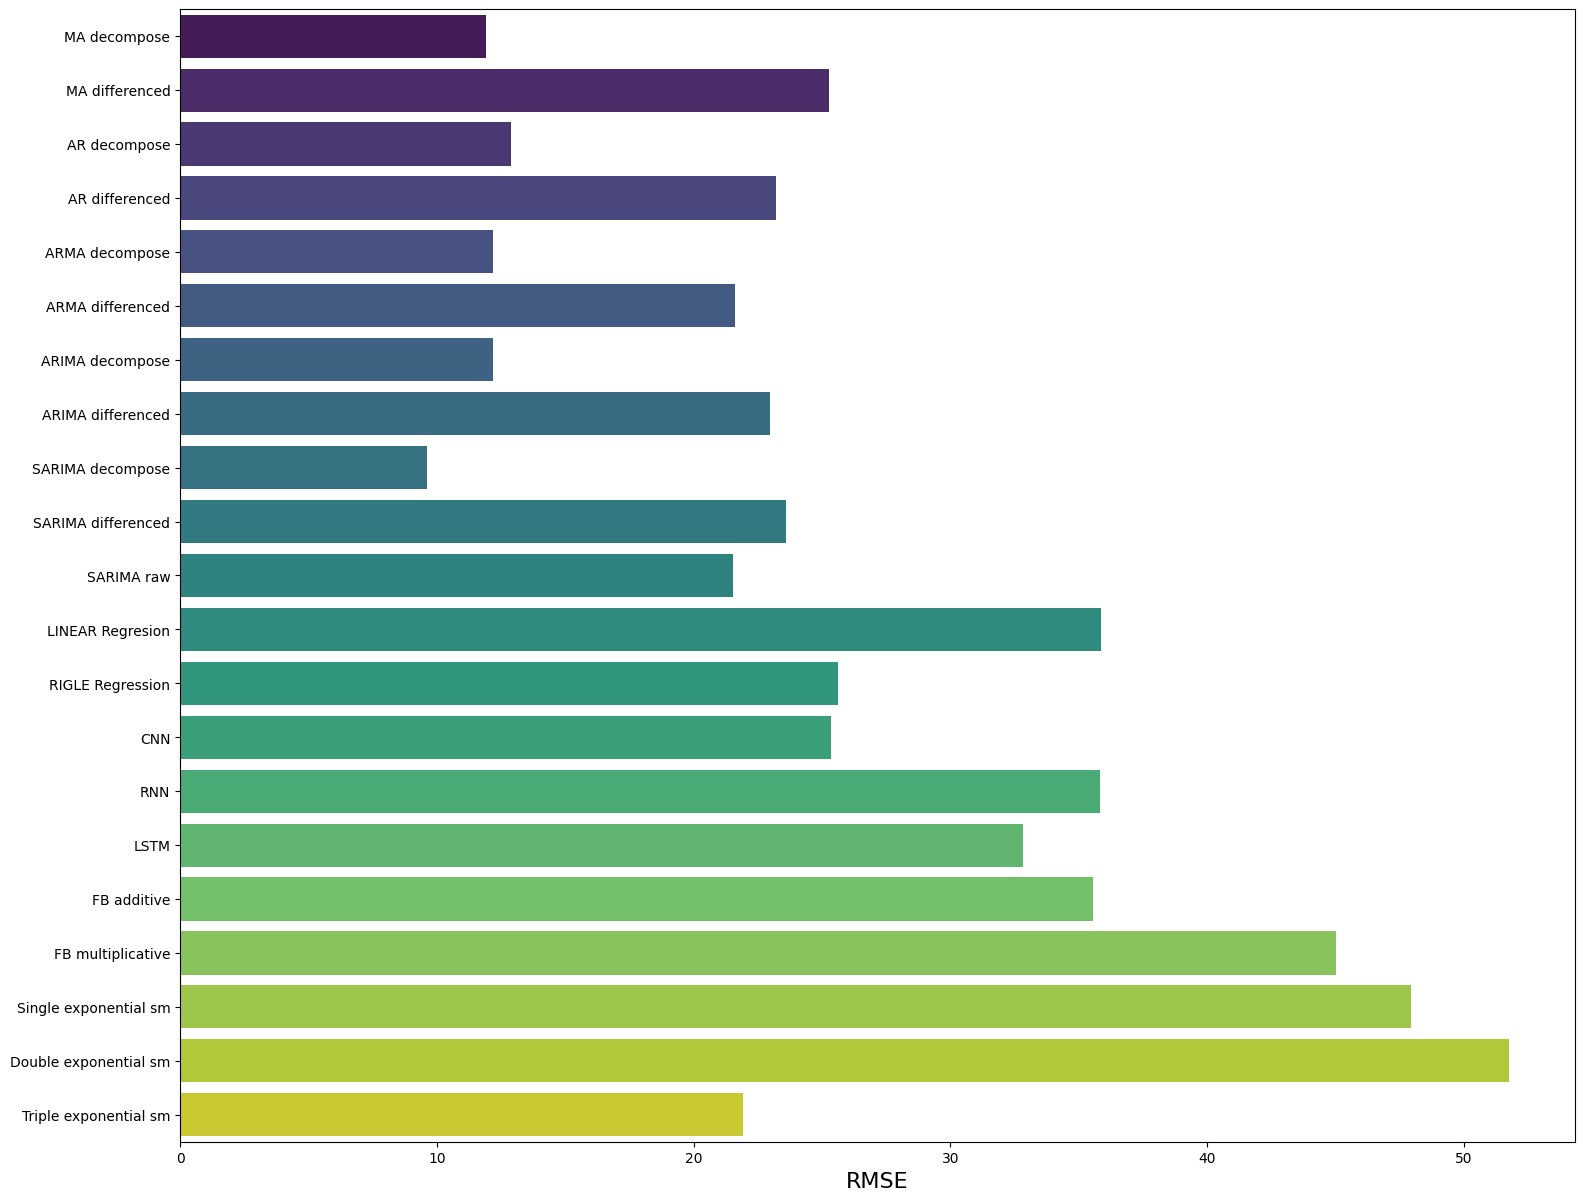

In [228]:
f, axe = plt.subplots(1,1, figsize=(18,15))
sns.barplot(x=data_dict["MSE"], y=['MA decompose', 'MA differenced', 'AR decompose', 'AR differenced',
                                    'ARMA decompose', 'ARMA differenced', 'ARIMA decompose', 'ARIMA differenced',
                                    'SARIMA decompose', 'SARIMA differenced', 'SARIMA raw',
                                    'LINEAR Regresion', 'RIGLE Regression', 
                                    'CNN', 'RNN', 'LSTM', 'FB additive', 'FB multiplicative', 'Single exponential sm', 'Double exponential sm', 'Triple exponential sm'],
                                    palette='viridis')
axe.set_xlabel('RMSE', size=16)
# axe.set_ylabel('Model and ts', size=16)
plt.show()

**I compare different models, which I train on decomposed, differenced and non-stationary raw time-series(where it is possible) and I desided to use SARIMA model for the future forcast.**
* **SARIMA on decomposed time series gave the best result, with the smallest RMSE.**
* **If take suitable parameters, SARIMA model is very comfortable, I can also train it on the raw, non-stationary data.**
* **We can also see that forecast on the decompose data gives smaller RMSE that on differenced.**

# Forecast for next year

(225,)

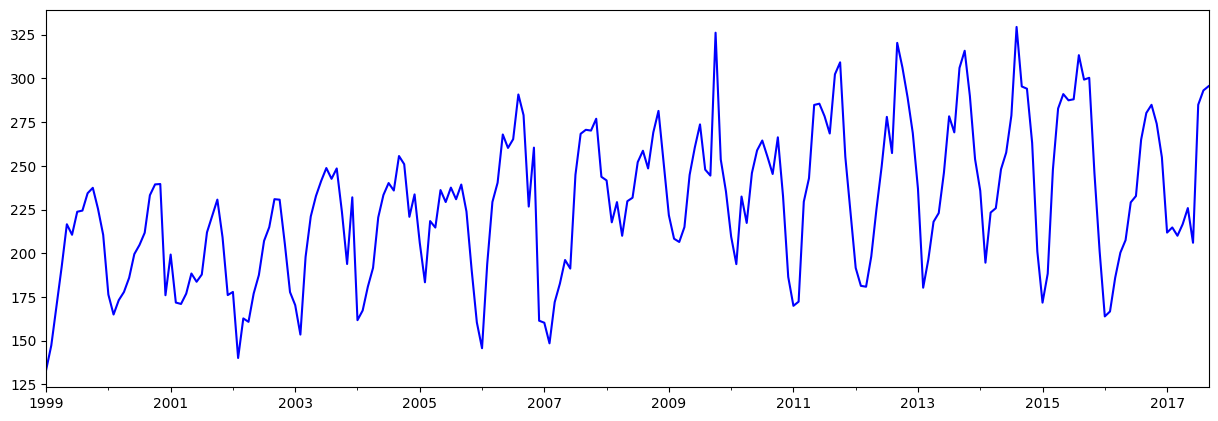

In [230]:
production = DATA['Johor'][1]
production.plot(color='blue')
production.shape

In [232]:
params = validate(production, pdq, seasonal_pdq)

ARIMA(0, 0, 0),(0, 0, 0, 12)12, t5 - AIC:2722.4765041122932
ARIMA(0, 0, 0),(0, 0, 0, 12)12, c5 - AIC:2304.751698596817
ARIMA(0, 0, 0),(0, 0, 0, 12)12, n5 - AIC:3078.3607658131223
ARIMA(0, 0, 0),(0, 0, 0, 12)12, ct5 - AIC:2255.7510740919215
ARIMA(0, 0, 0),(0, 0, 1, 12)12, t5 - AIC:2366.1337898909505
ARIMA(0, 0, 0),(0, 0, 1, 12)12, c5 - AIC:2100.8649326899717
ARIMA(0, 0, 0),(0, 0, 1, 12)12, n5 - AIC:2683.394465935207
ARIMA(0, 0, 0),(0, 0, 1, 12)12, ct5 - AIC:2069.7870785939544
ARIMA(0, 0, 0),(0, 0, 2, 12)12, t5 - AIC:2152.2339751404998
ARIMA(0, 0, 0),(0, 0, 2, 12)12, c5 - AIC:1970.3784771249343
ARIMA(0, 0, 0),(0, 0, 2, 12)12, n5 - AIC:2405.6455802556593
ARIMA(0, 0, 0),(0, 0, 2, 12)12, ct5 - AIC:1950.022883621752
ARIMA(0, 0, 0),(0, 1, 0, 12)12, t5 - AIC:2068.5147295836277
ARIMA(0, 0, 0),(0, 1, 0, 12)12, c5 - AIC:2068.0951520813474
ARIMA(0, 0, 0),(0, 1, 0, 12)12, n5 - AIC:2067.301928384412
ARIMA(0, 0, 0),(0, 1, 0, 12)12, ct5 - AIC:2070.070615003985
ARIMA(0, 0, 0),(0, 1, 1, 12)12, t5 - AIC:

ARIMA(0, 0, 1),(2, 1, 1, 12)12, c5 - AIC:1719.4803844768528
ARIMA(0, 0, 1),(2, 1, 1, 12)12, n5 - AIC:1744.5694837432407
ARIMA(0, 0, 1),(2, 1, 1, 12)12, ct5 - AIC:1712.997888029547
ARIMA(0, 0, 1),(2, 1, 2, 12)12, t5 - AIC:1714.1507105627406
ARIMA(0, 0, 1),(2, 1, 2, 12)12, c5 - AIC:1702.4003190555932
ARIMA(0, 0, 1),(2, 1, 2, 12)12, n5 - AIC:1723.8348104240138
ARIMA(0, 0, 1),(2, 1, 2, 12)12, ct5 - AIC:1699.707634712539
ARIMA(0, 0, 2),(0, 0, 0, 12)12, t5 - AIC:2330.7465117682445
ARIMA(0, 0, 2),(0, 0, 0, 12)12, c5 - AIC:2088.3794569928996
ARIMA(0, 0, 2),(0, 0, 0, 12)12, n5 - AIC:2589.977384958045
ARIMA(0, 0, 2),(0, 0, 0, 12)12, ct5 - AIC:2066.905522334117
ARIMA(0, 0, 2),(0, 0, 1, 12)12, t5 - AIC:2104.8947057231344
ARIMA(0, 0, 2),(0, 0, 1, 12)12, c5 - AIC:1936.3476843714923
ARIMA(0, 0, 2),(0, 0, 1, 12)12, n5 - AIC:2333.6249668683936
ARIMA(0, 0, 2),(0, 0, 1, 12)12, ct5 - AIC:1921.8705964195742
ARIMA(0, 0, 2),(0, 0, 2, 12)12, t5 - AIC:1921.6352879668789
ARIMA(0, 0, 2),(0, 0, 2, 12)12, c5 - AIC

ARIMA(0, 1, 0),(2, 0, 2, 12)12, n5 - AIC:1807.726522943569
ARIMA(0, 1, 0),(2, 0, 2, 12)12, ct5 - AIC:1811.8453263549359
ARIMA(0, 1, 0),(2, 1, 0, 12)12, t5 - AIC:1754.8483663127236
ARIMA(0, 1, 0),(2, 1, 0, 12)12, c5 - AIC:1754.8473435610836
ARIMA(0, 1, 0),(2, 1, 0, 12)12, n5 - AIC:1752.849426665401
ARIMA(0, 1, 0),(2, 1, 0, 12)12, ct5 - AIC:1756.890837316475
ARIMA(0, 1, 0),(2, 1, 1, 12)12, t5 - AIC:1710.1961284111546
ARIMA(0, 1, 0),(2, 1, 1, 12)12, c5 - AIC:1710.1850760991956
ARIMA(0, 1, 0),(2, 1, 1, 12)12, n5 - AIC:1708.2125841700004
ARIMA(0, 1, 0),(2, 1, 1, 12)12, ct5 - AIC:1712.1543586148819
ARIMA(0, 1, 0),(2, 1, 2, 12)12, t5 - AIC:1703.7572281881269
ARIMA(0, 1, 0),(2, 1, 2, 12)12, c5 - AIC:1706.4913688812512
ARIMA(0, 1, 0),(2, 1, 2, 12)12, n5 - AIC:1700.9240649546005
ARIMA(0, 1, 0),(2, 1, 2, 12)12, ct5 - AIC:1708.557291540969
ARIMA(0, 1, 1),(0, 0, 0, 12)12, t5 - AIC:2086.8326622699915
ARIMA(0, 1, 1),(0, 0, 0, 12)12, c5 - AIC:2086.821131835457
ARIMA(0, 1, 1),(0, 0, 0, 12)12, n5 - AIC:

ARIMA(0, 1, 2),(2, 0, 0, 12)12, ct5 - AIC:1826.565906885008
ARIMA(0, 1, 2),(2, 0, 1, 12)12, t5 - AIC:1825.9279231562564
ARIMA(0, 1, 2),(2, 0, 1, 12)12, c5 - AIC:1825.9392843021687
ARIMA(0, 1, 2),(2, 0, 1, 12)12, n5 - AIC:1823.9584593741856
ARIMA(0, 1, 2),(2, 0, 1, 12)12, ct5 - AIC:1827.9350549329438
ARIMA(0, 1, 2),(2, 0, 2, 12)12, t5 - AIC:1782.1632178628893
ARIMA(0, 1, 2),(2, 0, 2, 12)12, c5 - AIC:1781.2938985631563
ARIMA(0, 1, 2),(2, 0, 2, 12)12, n5 - AIC:1779.2973672529365
ARIMA(0, 1, 2),(2, 0, 2, 12)12, ct5 - AIC:1784.0431745850585
ARIMA(0, 1, 2),(2, 1, 0, 12)12, t5 - AIC:1740.8378459372634
ARIMA(0, 1, 2),(2, 1, 0, 12)12, c5 - AIC:1740.8355695338041
ARIMA(0, 1, 2),(2, 1, 0, 12)12, n5 - AIC:1738.8400421996637
ARIMA(0, 1, 2),(2, 1, 0, 12)12, ct5 - AIC:1742.8342336459878
ARIMA(0, 1, 2),(2, 1, 1, 12)12, t5 - AIC:1700.3312973212778
ARIMA(0, 1, 2),(2, 1, 1, 12)12, c5 - AIC:1700.3152937647828
ARIMA(0, 1, 2),(2, 1, 1, 12)12, n5 - AIC:1698.366869906314
ARIMA(0, 1, 2),(2, 1, 1, 12)12, ct5 - 

ARIMA(1, 0, 1),(1, 1, 2, 12)12, t5 - AIC:1672.8425636709608
ARIMA(1, 0, 1),(1, 1, 2, 12)12, c5 - AIC:1669.9858387719332
ARIMA(1, 0, 1),(1, 1, 2, 12)12, n5 - AIC:1677.7033226045696
ARIMA(1, 0, 1),(1, 1, 2, 12)12, ct5 - AIC:1670.3169144509397
ARIMA(1, 0, 1),(2, 0, 0, 12)12, t5 - AIC:1814.5299656359011
ARIMA(1, 0, 1),(2, 0, 0, 12)12, c5 - AIC:1800.2009526203478
ARIMA(1, 0, 1),(2, 0, 0, 12)12, n5 - AIC:1822.9633885118944
ARIMA(1, 0, 1),(2, 0, 0, 12)12, ct5 - AIC:1800.582195210278
ARIMA(1, 0, 1),(2, 0, 1, 12)12, t5 - AIC:1809.7949490503343
ARIMA(1, 0, 1),(2, 0, 1, 12)12, c5 - AIC:1802.827078975665
ARIMA(1, 0, 1),(2, 0, 1, 12)12, n5 - AIC:1787.9805387348486
ARIMA(1, 0, 1),(2, 0, 1, 12)12, ct5 - AIC:1806.9260057626584
ARIMA(1, 0, 1),(2, 0, 2, 12)12, t5 - AIC:1791.6101093530815
ARIMA(1, 0, 1),(2, 0, 2, 12)12, c5 - AIC:1799.4809051924822
ARIMA(1, 0, 1),(2, 0, 2, 12)12, n5 - AIC:1771.0435915360904
ARIMA(1, 0, 1),(2, 0, 2, 12)12, ct5 - AIC:1800.410772758561
ARIMA(1, 0, 1),(2, 1, 0, 12)12, t5 - AI

ARIMA(1, 1, 0),(1, 1, 0, 12)12, c5 - AIC:1842.8558641038846
ARIMA(1, 1, 0),(1, 1, 0, 12)12, n5 - AIC:1840.856144869782
ARIMA(1, 1, 0),(1, 1, 0, 12)12, ct5 - AIC:1844.8380803406676
ARIMA(1, 1, 0),(1, 1, 1, 12)12, t5 - AIC:1798.2543531791137
ARIMA(1, 1, 0),(1, 1, 1, 12)12, c5 - AIC:1798.2540155604722
ARIMA(1, 1, 0),(1, 1, 1, 12)12, n5 - AIC:1796.254552309115
ARIMA(1, 1, 0),(1, 1, 1, 12)12, ct5 - AIC:1800.2563541366803
ARIMA(1, 1, 0),(1, 1, 2, 12)12, t5 - AIC:1692.4506375864762
ARIMA(1, 1, 0),(1, 1, 2, 12)12, c5 - AIC:1692.446841235231
ARIMA(1, 1, 0),(1, 1, 2, 12)12, n5 - AIC:1690.4548474423555
ARIMA(1, 1, 0),(1, 1, 2, 12)12, ct5 - AIC:1694.4931664402186
ARIMA(1, 1, 0),(2, 0, 0, 12)12, t5 - AIC:1814.8851802336053
ARIMA(1, 1, 0),(2, 0, 0, 12)12, c5 - AIC:1814.8950542967902
ARIMA(1, 1, 0),(2, 0, 0, 12)12, n5 - AIC:1812.9262558611122
ARIMA(1, 1, 0),(2, 0, 0, 12)12, ct5 - AIC:1816.923116647788
ARIMA(1, 1, 0),(2, 0, 1, 12)12, t5 - AIC:1816.8776598299041
ARIMA(1, 1, 0),(2, 0, 1, 12)12, c5 - AIC

ARIMA(1, 1, 2),(1, 0, 1, 12)12, n5 - AIC:1872.448998862544
ARIMA(1, 1, 2),(1, 0, 1, 12)12, ct5 - AIC:1903.0905413223159
ARIMA(1, 1, 2),(1, 0, 2, 12)12, t5 - AIC:1796.608296055541
ARIMA(1, 1, 2),(1, 0, 2, 12)12, c5 - AIC:1765.113270549265
ARIMA(1, 1, 2),(1, 0, 2, 12)12, n5 - AIC:1765.1385657962555
ARIMA(1, 1, 2),(1, 0, 2, 12)12, ct5 - AIC:1793.8151713089128
ARIMA(1, 1, 2),(1, 1, 0, 12)12, t5 - AIC:1846.4241126793672
ARIMA(1, 1, 2),(1, 1, 0, 12)12, c5 - AIC:1846.4252651845736
ARIMA(1, 1, 2),(1, 1, 0, 12)12, n5 - AIC:1844.4255370159767
ARIMA(1, 1, 2),(1, 1, 0, 12)12, ct5 - AIC:1848.409369440266
ARIMA(1, 1, 2),(1, 1, 1, 12)12, t5 - AIC:1785.7755746494759
ARIMA(1, 1, 2),(1, 1, 1, 12)12, c5 - AIC:1785.560980405541
ARIMA(1, 1, 2),(1, 1, 1, 12)12, n5 - AIC:1783.5614583495685
ARIMA(1, 1, 2),(1, 1, 1, 12)12, ct5 - AIC:1787.6020014013668
ARIMA(1, 1, 2),(1, 1, 2, 12)12, t5 - AIC:1680.378606559729
ARIMA(1, 1, 2),(1, 1, 2, 12)12, c5 - AIC:1680.0699793262434
ARIMA(1, 1, 2),(1, 1, 2, 12)12, n5 - AIC:1

ARIMA(2, 0, 1),(0, 1, 2, 12)12, ct5 - AIC:1670.652629216469
ARIMA(2, 0, 1),(1, 0, 0, 12)12, t5 - AIC:1916.3137675514304
ARIMA(2, 0, 1),(1, 0, 0, 12)12, c5 - AIC:1937.0924565553528
ARIMA(2, 0, 1),(1, 0, 0, 12)12, n5 - AIC:1916.127910804225
ARIMA(2, 0, 1),(1, 0, 0, 12)12, ct5 - AIC:1977.3853890589821
ARIMA(2, 0, 1),(1, 0, 1, 12)12, t5 - AIC:1915.2092164116239
ARIMA(2, 0, 1),(1, 0, 1, 12)12, c5 - AIC:1953.5380498053182
ARIMA(2, 0, 1),(1, 0, 1, 12)12, n5 - AIC:1879.52363836341
ARIMA(2, 0, 1),(1, 0, 1, 12)12, ct5 - AIC:1948.4854154724733
ARIMA(2, 0, 1),(1, 0, 2, 12)12, t5 - AIC:1804.8010057262447
ARIMA(2, 0, 1),(1, 0, 2, 12)12, c5 - AIC:1819.0403275509916
ARIMA(2, 0, 1),(1, 0, 2, 12)12, n5 - AIC:1789.1066423837017
ARIMA(2, 0, 1),(1, 0, 2, 12)12, ct5 - AIC:1841.973031712815
ARIMA(2, 0, 1),(1, 1, 0, 12)12, t5 - AIC:1823.765505279477
ARIMA(2, 0, 1),(1, 1, 0, 12)12, c5 - AIC:1823.5325862364184
ARIMA(2, 0, 1),(1, 1, 0, 12)12, n5 - AIC:1821.9454680883812
ARIMA(2, 0, 1),(1, 1, 0, 12)12, ct5 - AIC:

ARIMA(2, 1, 0),(0, 1, 1, 12)12, t5 - AIC:1798.2553430505302
ARIMA(2, 1, 0),(0, 1, 1, 12)12, c5 - AIC:1798.2550750283708
ARIMA(2, 1, 0),(0, 1, 1, 12)12, n5 - AIC:1796.2554865839647
ARIMA(2, 1, 0),(0, 1, 1, 12)12, ct5 - AIC:1800.2543150905244
ARIMA(2, 1, 0),(0, 1, 2, 12)12, t5 - AIC:1692.874344446569
ARIMA(2, 1, 0),(0, 1, 2, 12)12, c5 - AIC:1692.862406920453
ARIMA(2, 1, 0),(0, 1, 2, 12)12, n5 - AIC:1690.8839253952751
ARIMA(2, 1, 0),(0, 1, 2, 12)12, ct5 - AIC:1694.8583080145677
ARIMA(2, 1, 0),(1, 0, 0, 12)12, t5 - AIC:1913.6217073236724
ARIMA(2, 1, 0),(1, 0, 0, 12)12, c5 - AIC:1913.6257588807239
ARIMA(2, 1, 0),(1, 0, 0, 12)12, n5 - AIC:1911.6670013714547
ARIMA(2, 1, 0),(1, 0, 0, 12)12, ct5 - AIC:1915.6222176394092
ARIMA(2, 1, 0),(1, 0, 1, 12)12, t5 - AIC:1899.1789248890373
ARIMA(2, 1, 0),(1, 0, 1, 12)12, c5 - AIC:1899.1737379022393
ARIMA(2, 1, 0),(1, 0, 1, 12)12, n5 - AIC:1897.198468671742
ARIMA(2, 1, 0),(1, 0, 1, 12)12, ct5 - AIC:1901.1707423365096
ARIMA(2, 1, 0),(1, 0, 2, 12)12, t5 - AI

ARIMA(2, 1, 2),(0, 0, 2, 12)12, c5 - AIC:1787.6978961318173
ARIMA(2, 1, 2),(0, 0, 2, 12)12, n5 - AIC:1788.8105412756372
ARIMA(2, 1, 2),(0, 0, 2, 12)12, ct5 - AIC:1802.5617370368564
ARIMA(2, 1, 2),(0, 1, 0, 12)12, t5 - AIC:1946.9699092349458
ARIMA(2, 1, 2),(0, 1, 0, 12)12, c5 - AIC:1946.9695157447977
ARIMA(2, 1, 2),(0, 1, 0, 12)12, n5 - AIC:1942.985743519101
ARIMA(2, 1, 2),(0, 1, 0, 12)12, ct5 - AIC:1948.9668767775477
ARIMA(2, 1, 2),(0, 1, 1, 12)12, t5 - AIC:1782.7724818827692
ARIMA(2, 1, 2),(0, 1, 1, 12)12, c5 - AIC:1782.750974937668
ARIMA(2, 1, 2),(0, 1, 1, 12)12, n5 - AIC:1780.7533010868192
ARIMA(2, 1, 2),(0, 1, 1, 12)12, ct5 - AIC:1787.610923336425
ARIMA(2, 1, 2),(0, 1, 2, 12)12, t5 - AIC:1677.3601166131052
ARIMA(2, 1, 2),(0, 1, 2, 12)12, c5 - AIC:1677.3524741039464
ARIMA(2, 1, 2),(0, 1, 2, 12)12, n5 - AIC:1675.3663735426367
ARIMA(2, 1, 2),(0, 1, 2, 12)12, ct5 - AIC:1680.4862752023905
ARIMA(2, 1, 2),(1, 0, 0, 12)12, t5 - AIC:1910.2784228284218
ARIMA(2, 1, 2),(1, 0, 0, 12)12, c5 - AI

Text(0.5, 1.0, 'RMSE: 23.2326')

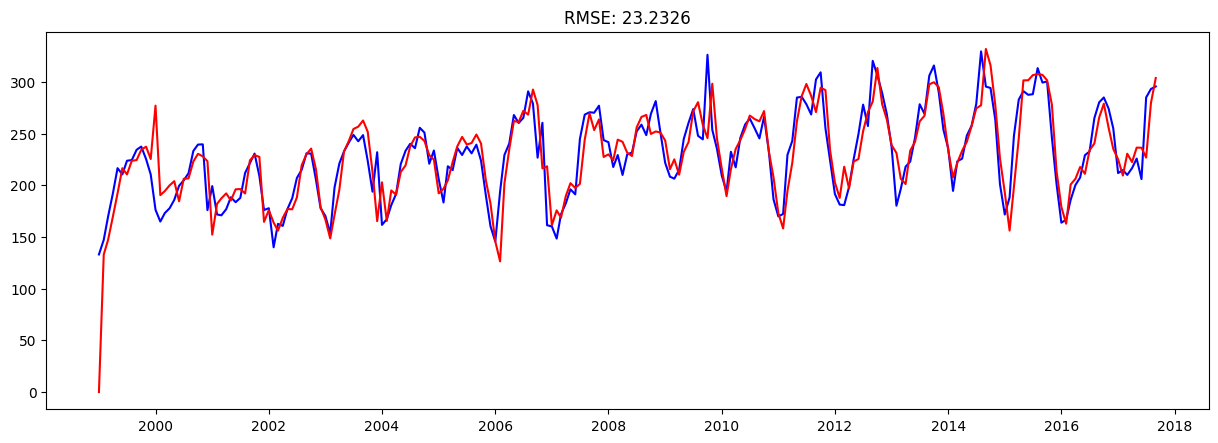

In [241]:
order, sorder, t = [(2,1,2), (0,1,2,12), 'c']
# order, sorder, t = [(2, 0, 2), (0, 1, 2, 12), 'n']
# order, sorder, t = params
model = SARIMAX(production, 
            order=order, 
            seasonal_order=sorder, 
            trend=t)
# model_fit.summary()
model_fit = model.fit(disp=0)
rmse_sarima = np.sqrt(mean_squared_error(model_fit.fittedvalues, production))
plt.plot(production, color='blue')
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RMSE: %.4f'% rmse_sarima)

In [ ]:
# history = [x for x in production]
# predictions = list()
# for t in range(12):
#     model = SARIMAX(history, 
#             order=order, 
#             seasonal_order=sorder, 
#             trend='c')
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     history.append(yhat)
# forecast = pd.Series(predictions, index=test.index)

In [242]:
start_index = len(production)
end_index = start_index + 11
forecast = model_fit.predict(start=start_index, end=end_index)

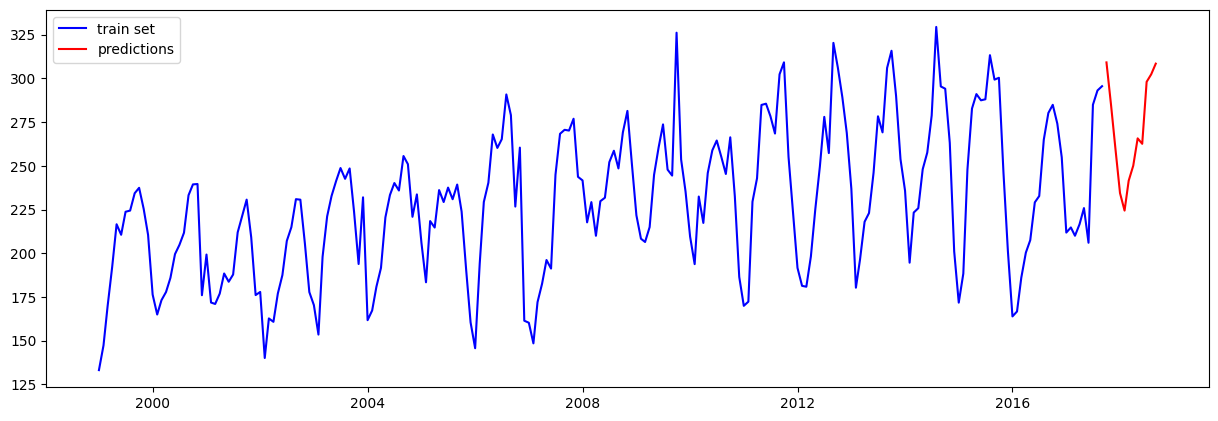

In [243]:
plt.plot(production, color='blue', label="train set")
plt.plot(forecast, color='red', label="predictions")
plt.legend(loc='upper left')
plt.show()

In [244]:
forecast

2017-10-01    309.191369
2017-11-01    284.903280
2017-12-01    259.736828
2018-01-01    234.424177
2018-02-01    224.386887
2018-03-01    241.511760
2018-04-01    250.088411
2018-05-01    265.726641
2018-06-01    262.606300
2018-07-01    298.074115
2018-08-01    302.367941
2018-09-01    308.476907
Freq: MS, Name: predicted_mean, dtype: float64